<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 2207, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 2207 (delta 35), reused 34 (delta 16), pack-reused 2142 (from 1)
Receiving objects: 100% (2207/2207), 23.20 MiB | 27.59 MiB/s, done.
Resolving deltas: 100% (1530/1530), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json
import gc

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage2
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results_stage_2

In [4]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.10% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
0.10% complete (down: 3447.9 kB/s up: 92.2 kB/s peers: 4) downloading LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
0.66% complete (down: 8161.8 kB/s up: 238.3 kB/s peers: 11) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unr

## Model

In [ ]:
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
model_stage_1 = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)
model_stage_1.load_state_dict(torch.load(weight_path, map_location=device))

<All keys matched successfully>

In [ ]:
model = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)

## Load data

In [ ]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=3, mode="tumor", model_stage_1=model_stage_1, device=device)
print(len(full_train_dataset), len(val_dataset))

105 26


In [ ]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

## visualize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch

def visualize_from_loader(image_tensor, label_tensor, liver_mask):
    """
    Hiển thị 3 ảnh: Volume, Liver Mask, và Liver Mask + Segmentation

    Args:
        image_tensor: Tensor, shape [1, 1, D, H, W]
        label_tensor: Tensor, shape [1, 1, D, H, W]
        liver_mask: Tensor, shape [1, 1, D, H, W]
    Notes:
        - Chuyển đổi sang numpy
        - Hiển thị 3 ảnh: volume, liver mask, và liver mask + segmentation
    """

    # Chuyển đổi sang numpy, nén tensor về dạng [D, H, W]
    image = image_tensor.detach().cpu().numpy().squeeze()
    label = label_tensor.detach().cpu().numpy().squeeze()
    liver_mask = liver_mask.detach().cpu().numpy().squeeze()


    # Chọn độ sâu (ví dụ: độ sâu 40% của chiều sâu ảnh)
    depth = image.shape[0] // 2

    # Bảng màu cho mask khối u
    cmap1 = mcolors.ListedColormap(["black", "red"])
    cmap2 = mcolors.ListedColormap(["black", "yellow"])

    # Vẽ hình
    plt.figure(figsize=(18, 6))

    # Ảnh đầu tiên: Volume (Ảnh gốc)
    plt.subplot(1, 3, 1)
    plt.title("Volume")
    plt.imshow(image[depth, :, :], cmap='gray')
    plt.axis("off")

    # Ảnh thứ ba: Liver Mask + Segmentation
    plt.subplot(1, 3, 2)
    plt.title("Liver Mask + volume")
    plt.imshow(image[depth, :, :], cmap='gray')
    plt.imshow(np.max(liver_mask,0), cmap=cmap2, alpha=0.5)
    plt.axis("off")


    plt.subplot(1, 3, 3)
    plt.title("tumor Mask + volume")
    plt.imshow(image[depth, :, :], cmap='gray')
    plt.imshow(np.max(label, 0), cmap=cmap1, alpha=0.5)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

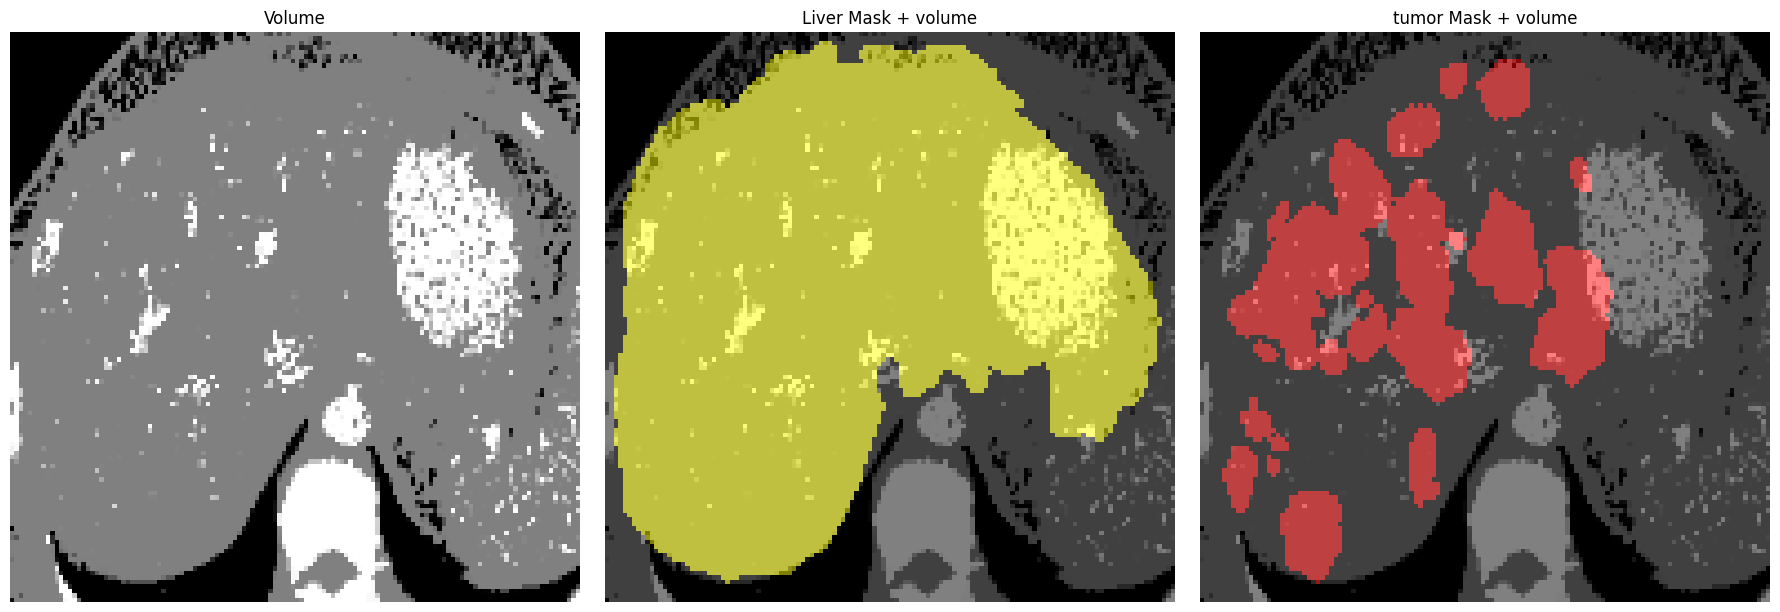

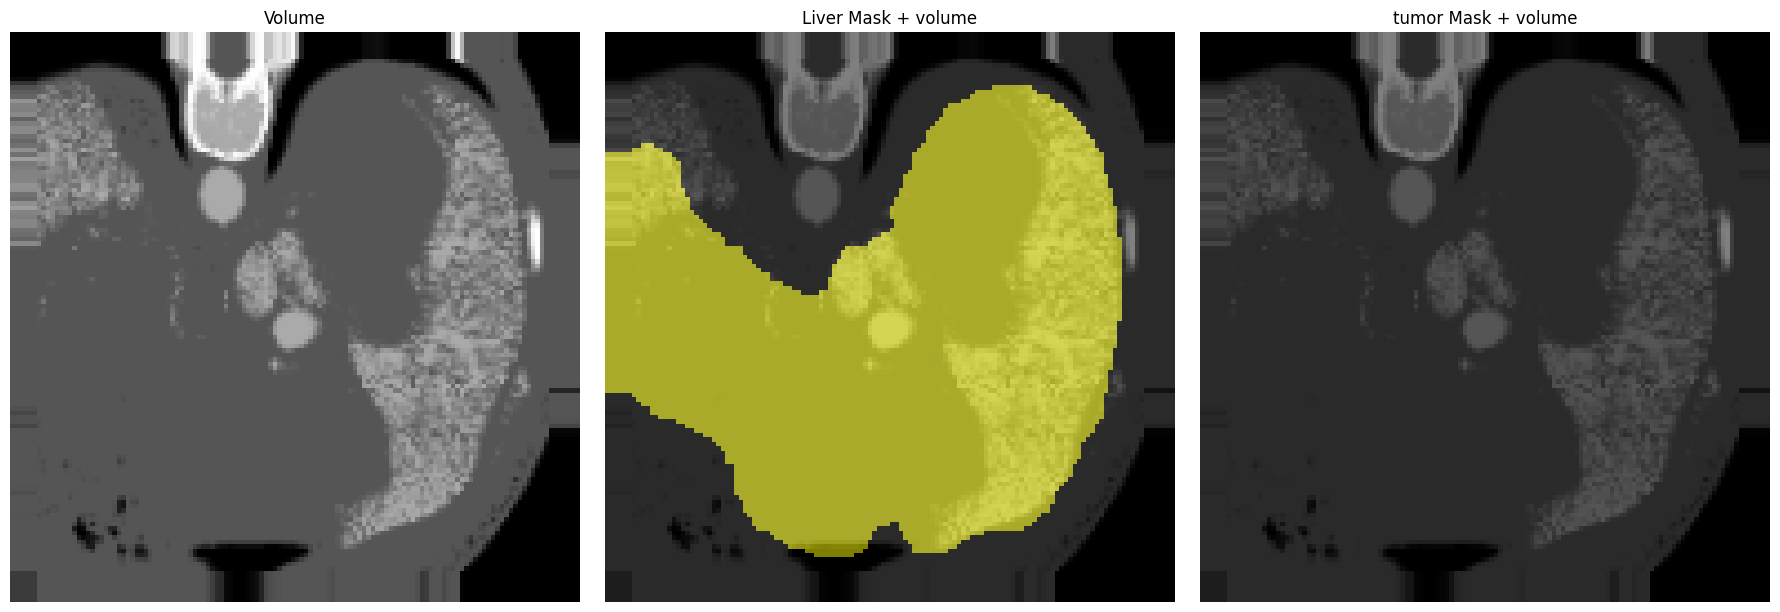

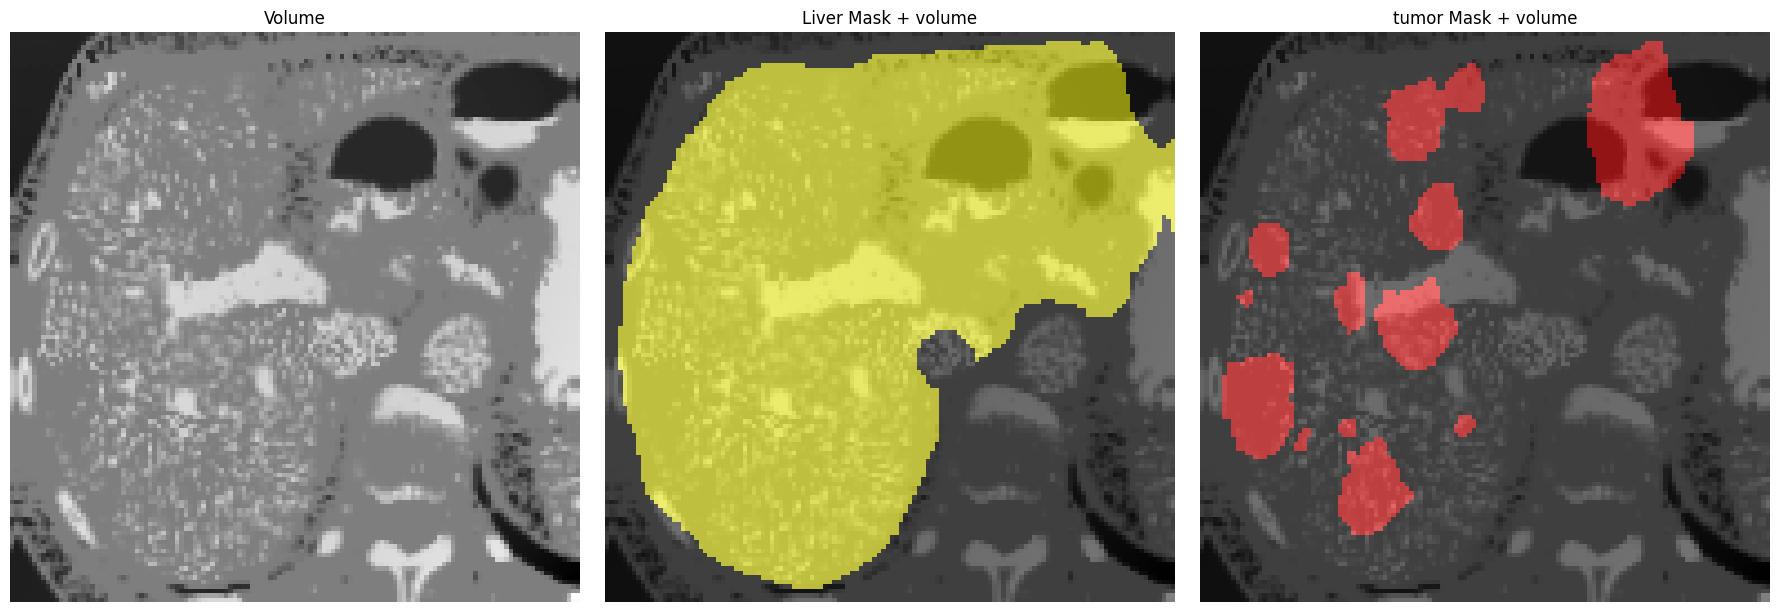

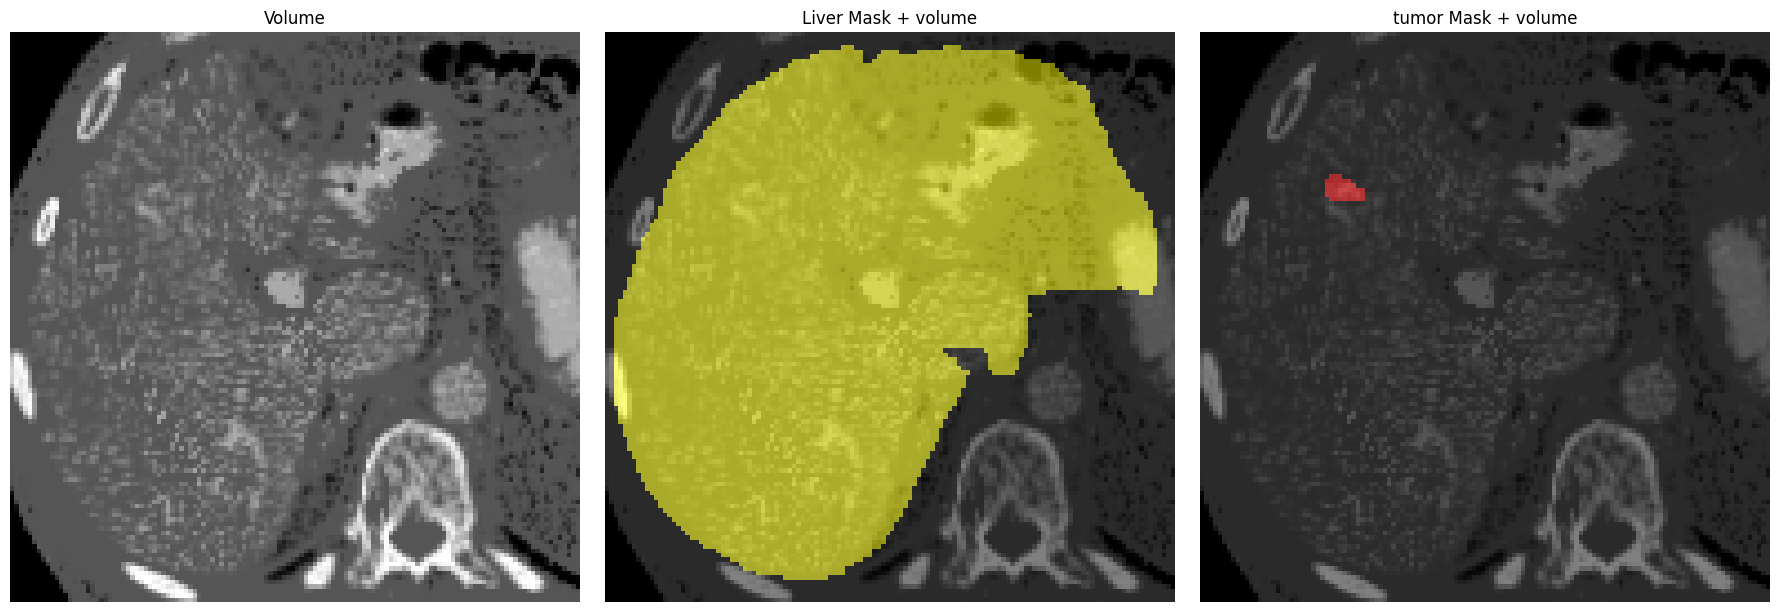

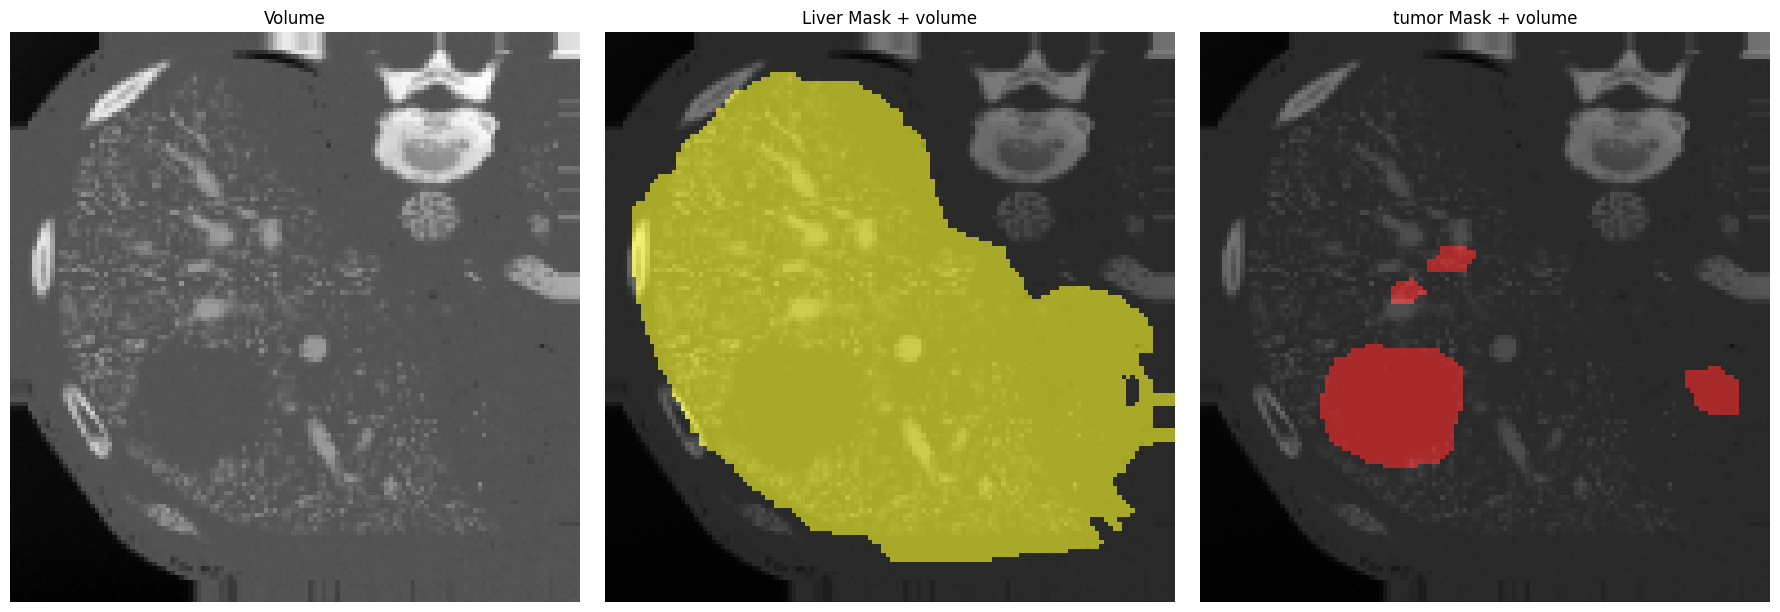

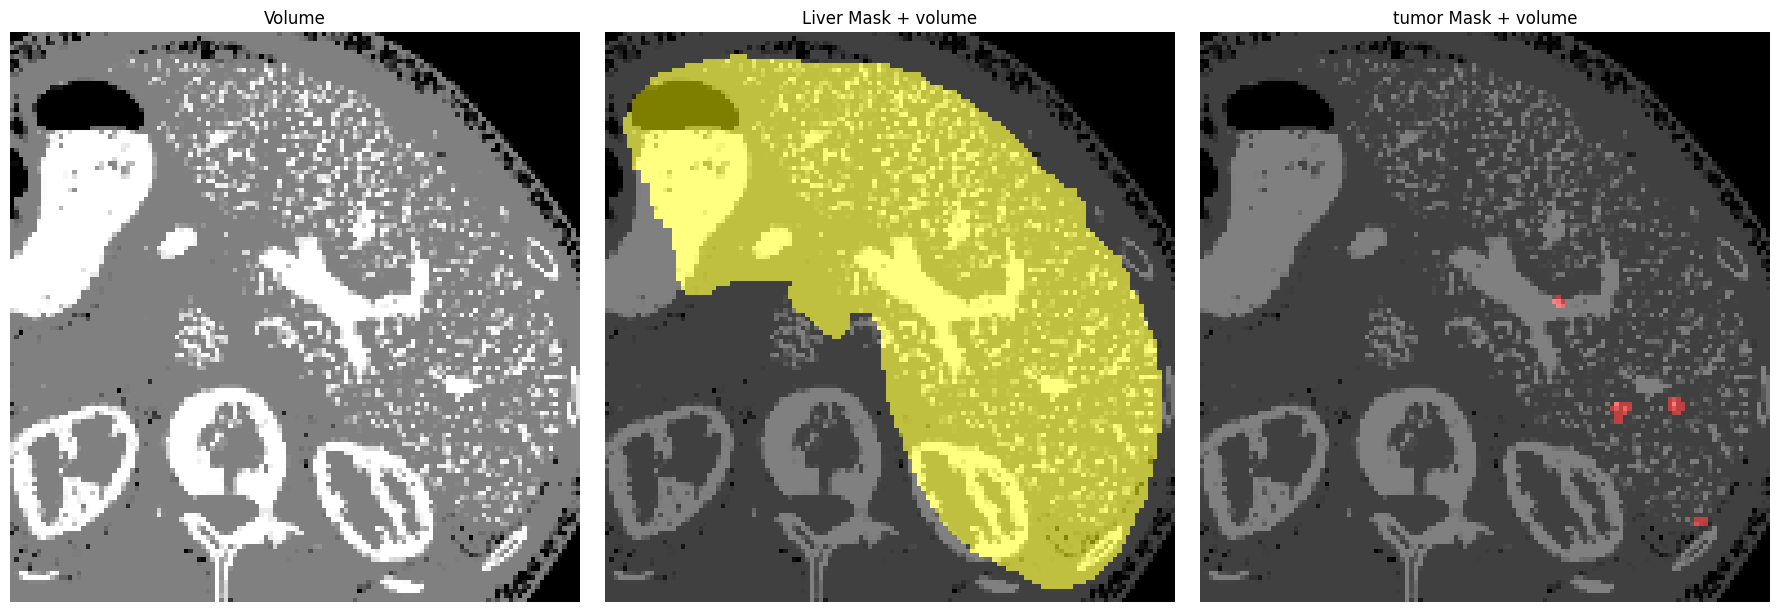

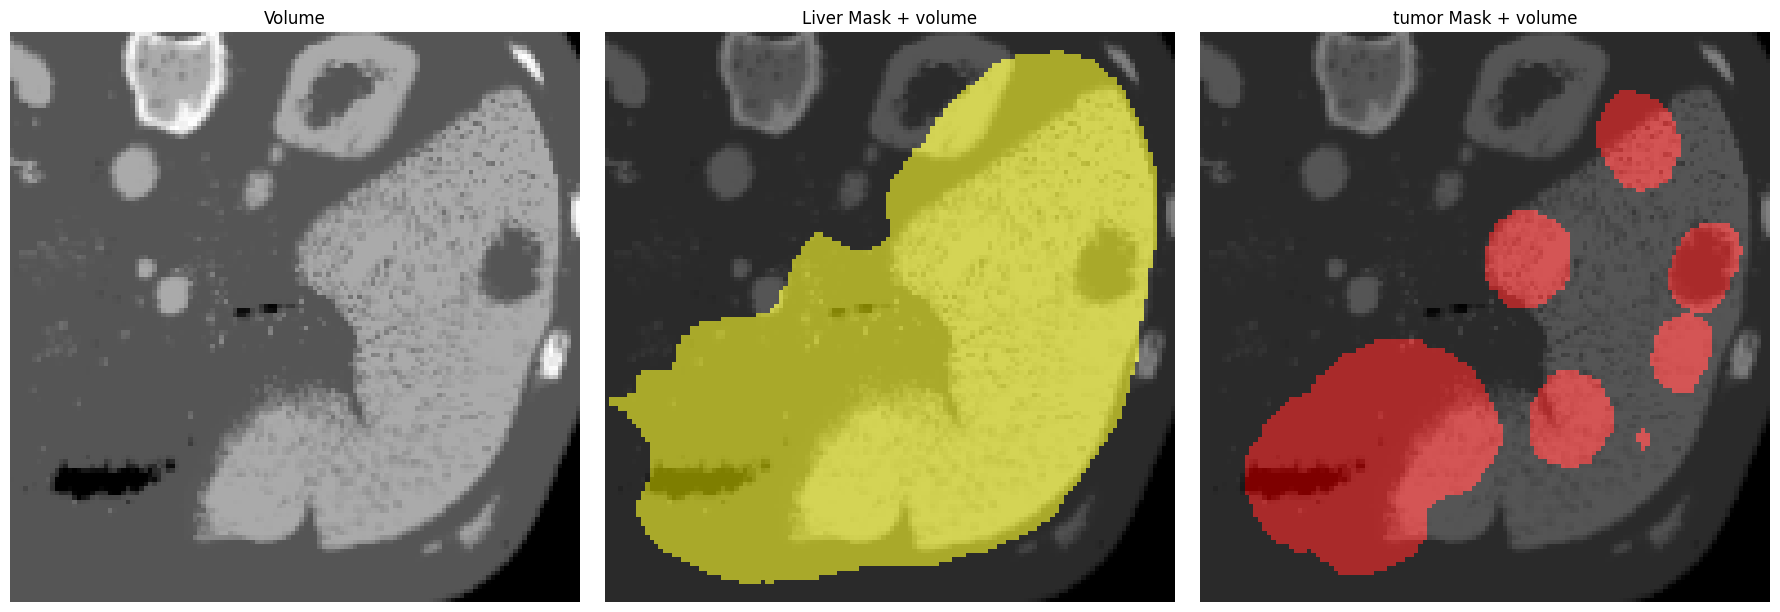

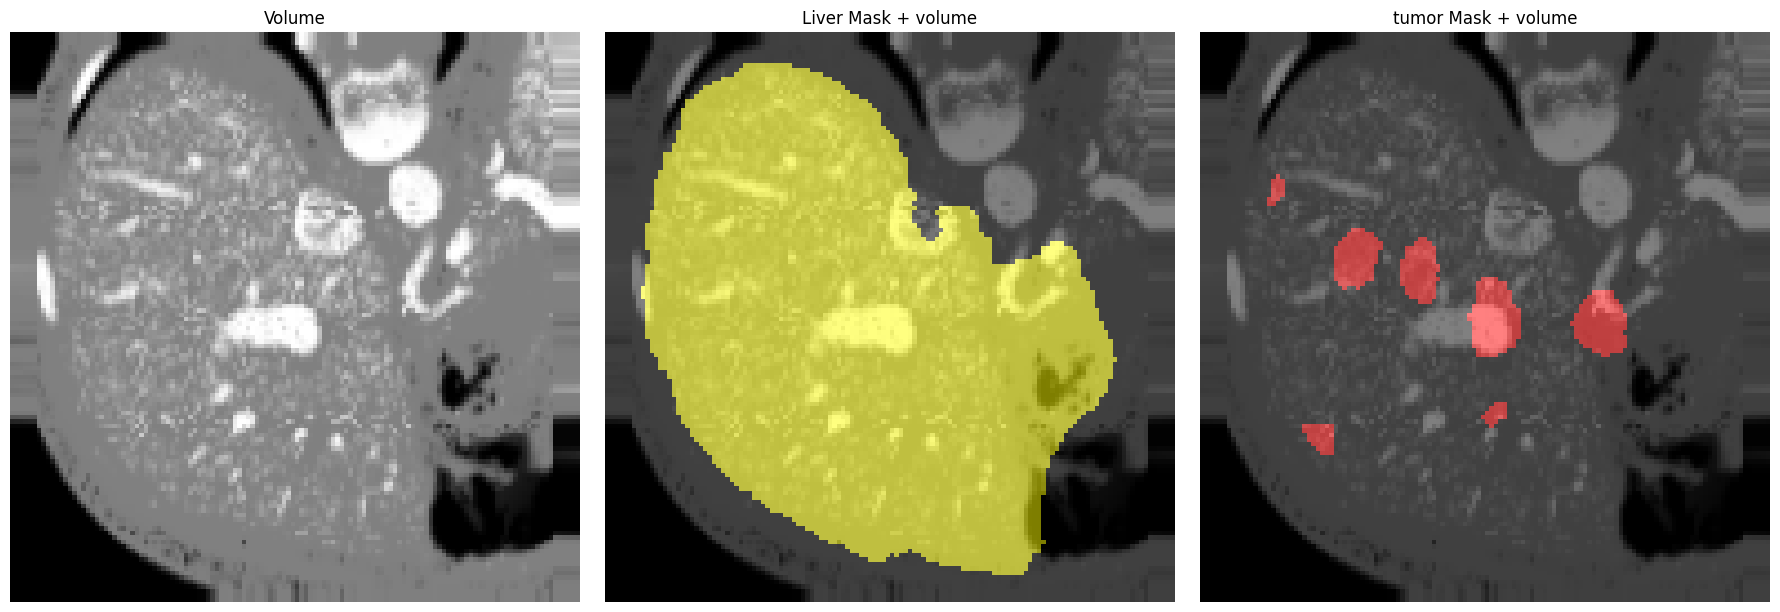

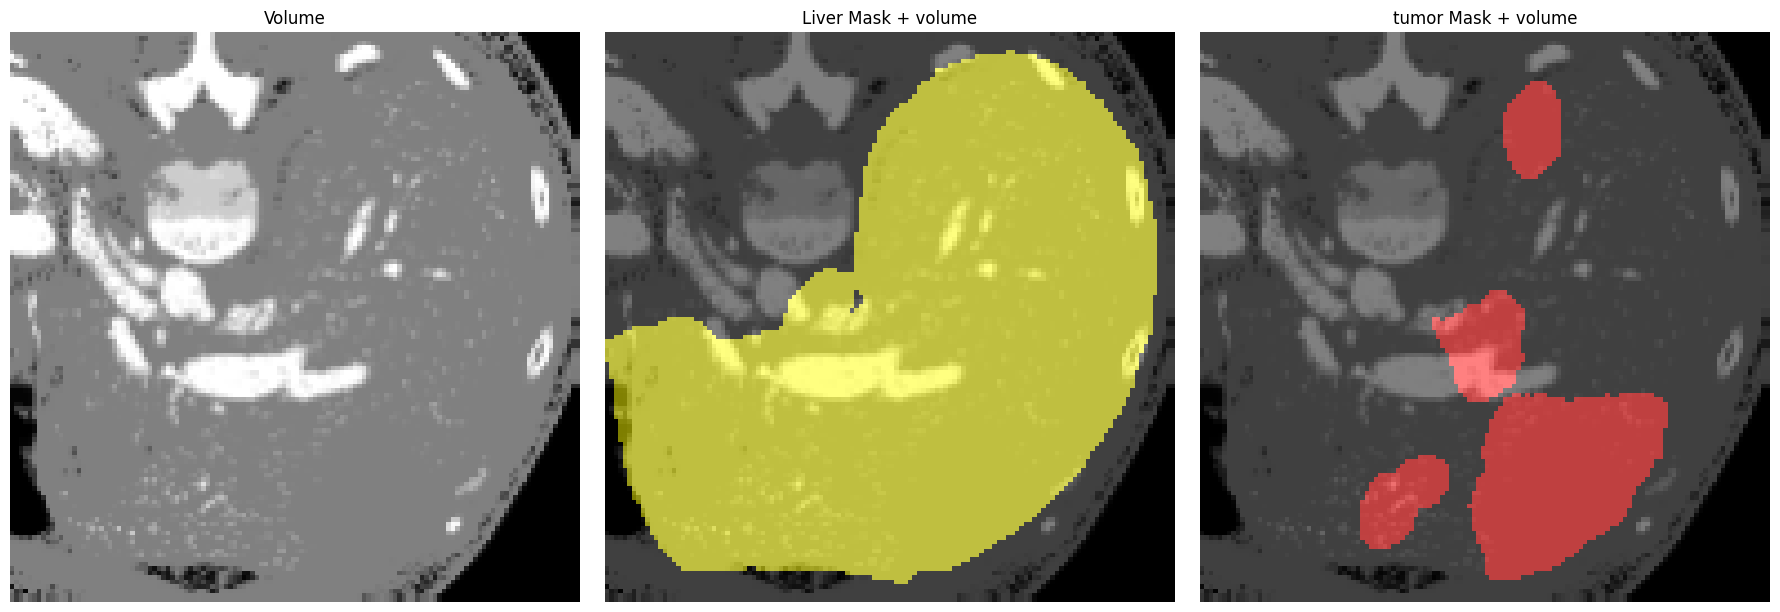

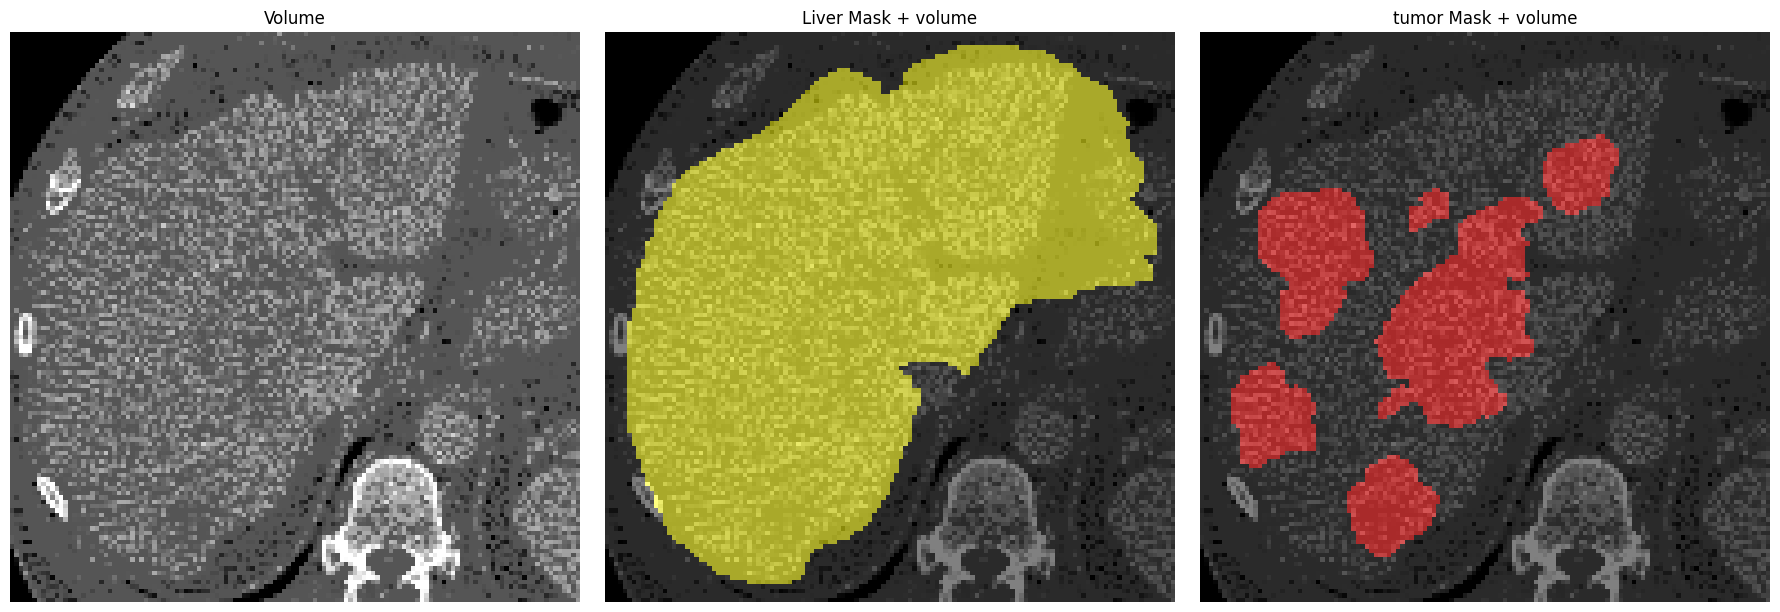

In [ ]:
i = 0
for train_data in train_loader:
    i+= 1
    image = train_data["image"]
    label = train_data["label"]
    liver_mask = train_data["liver_mask"]
    visualize_from_loader(image, label, liver_mask)
    # print(image.shape, label.shape, liver_mask.shape)
    if i == 10:
      break


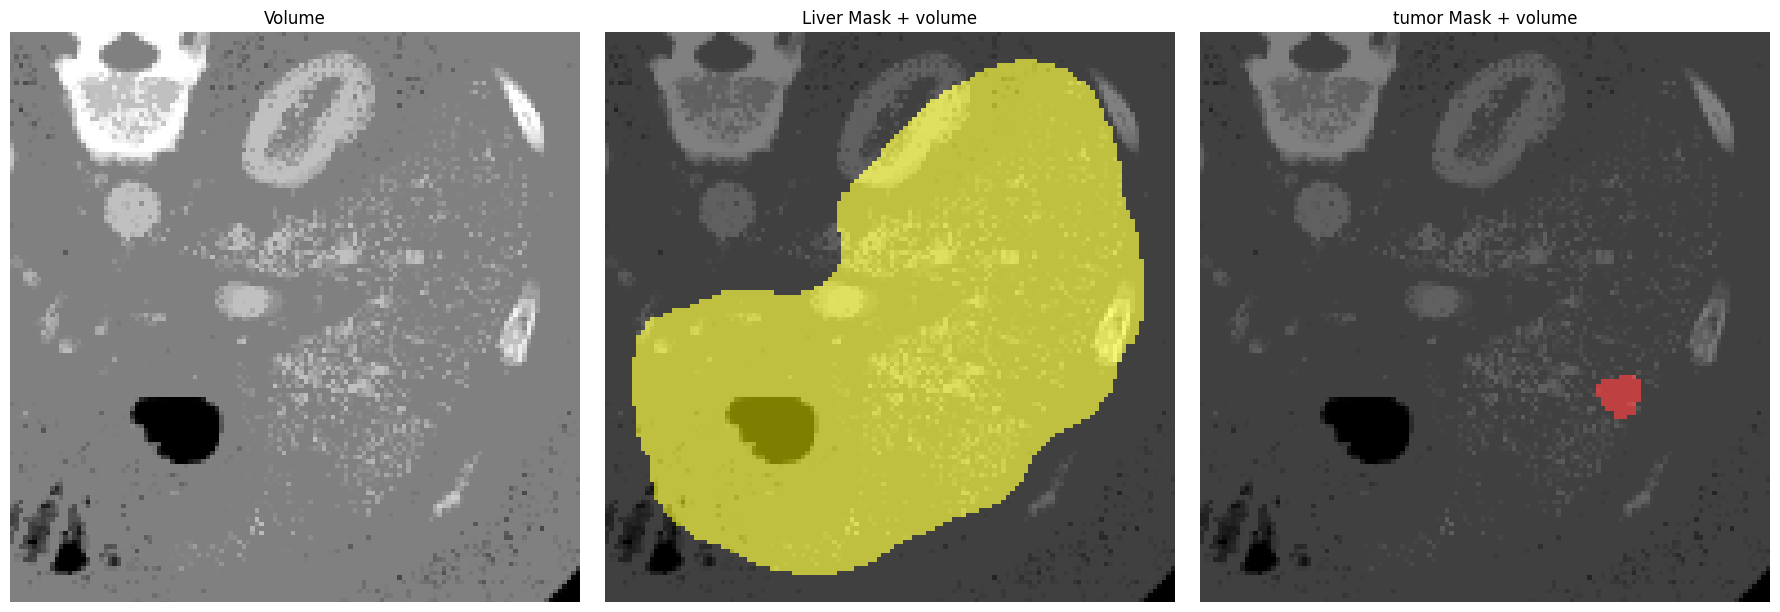

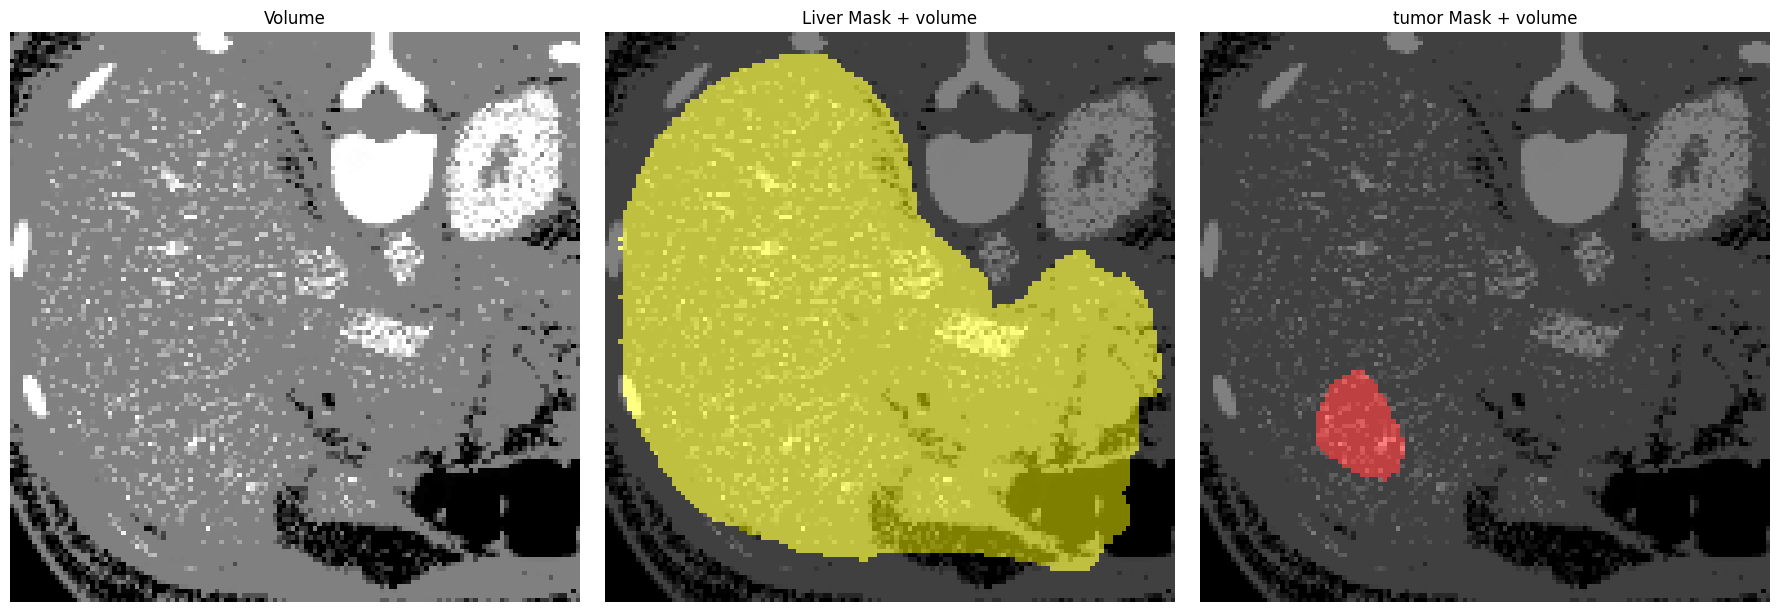

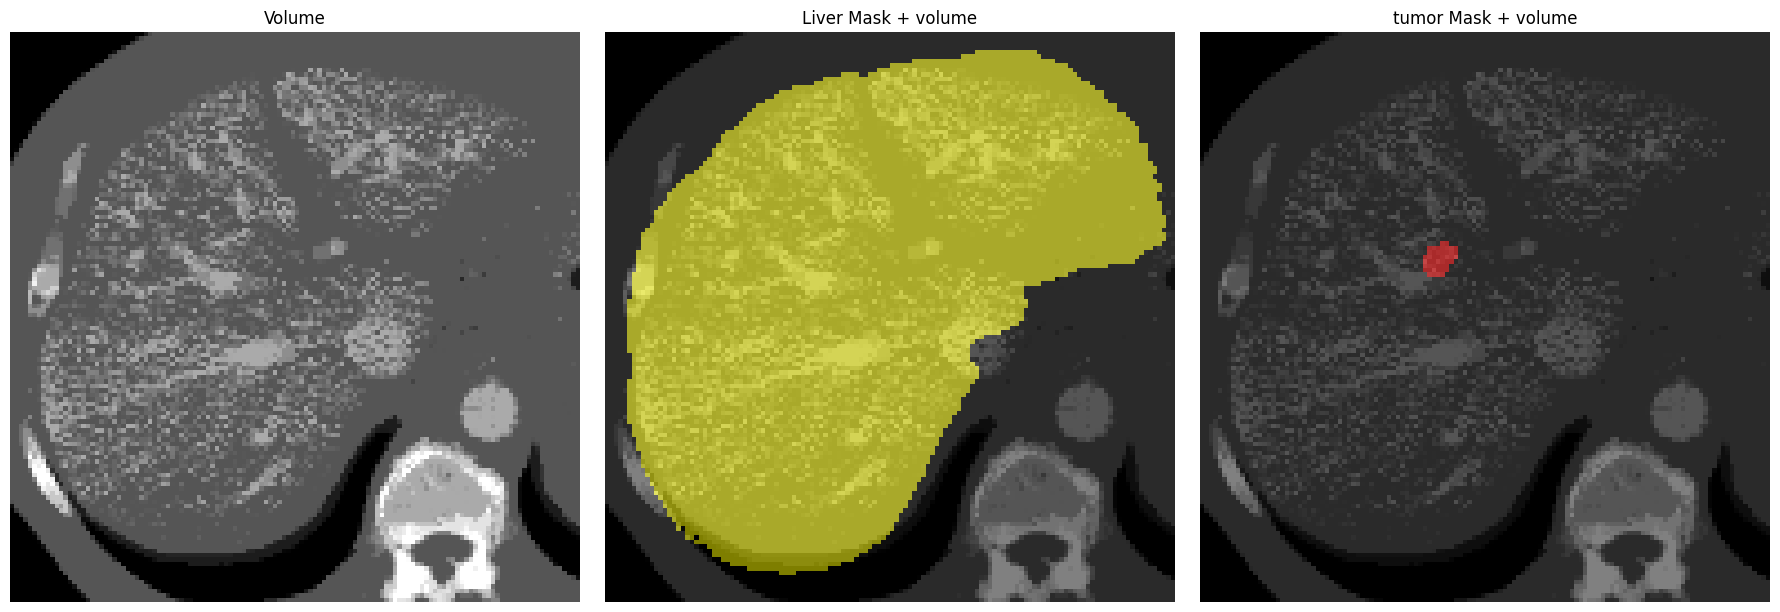

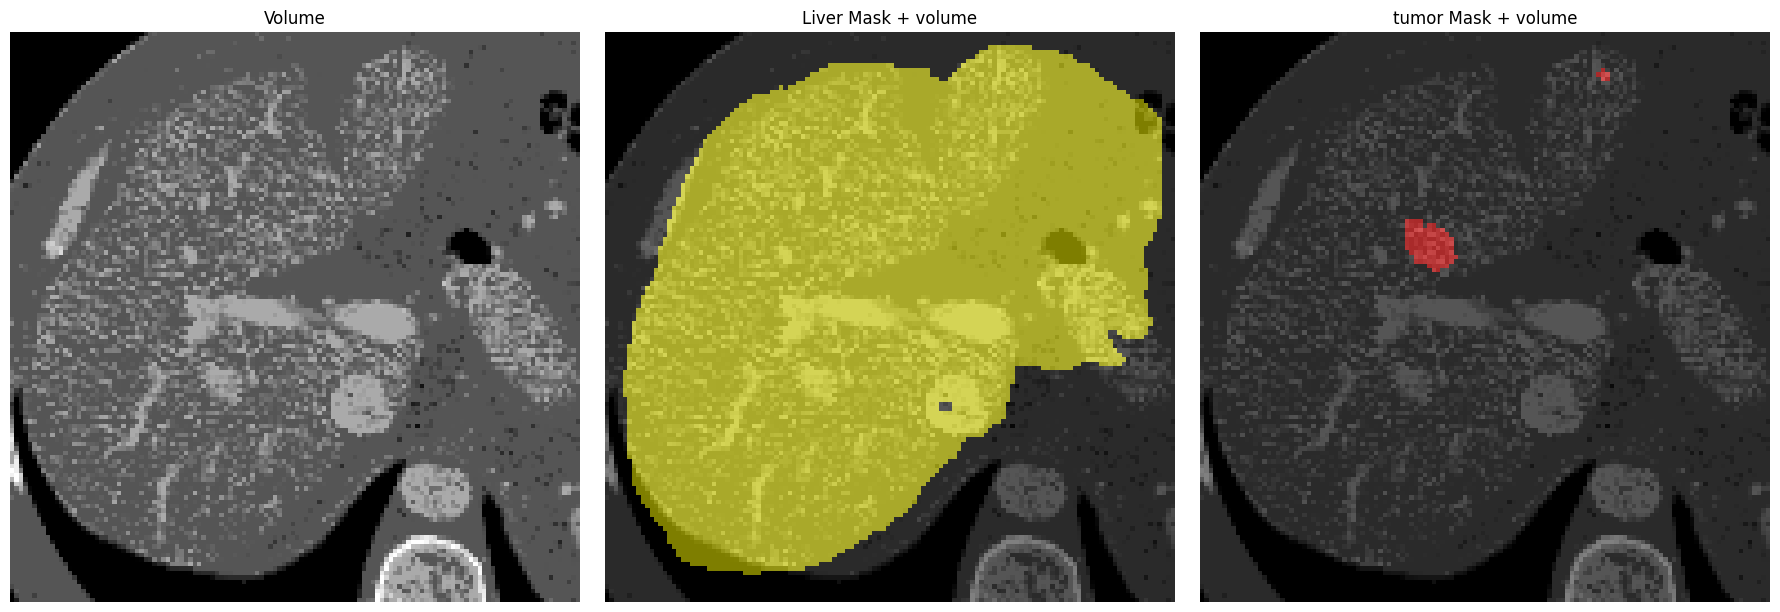

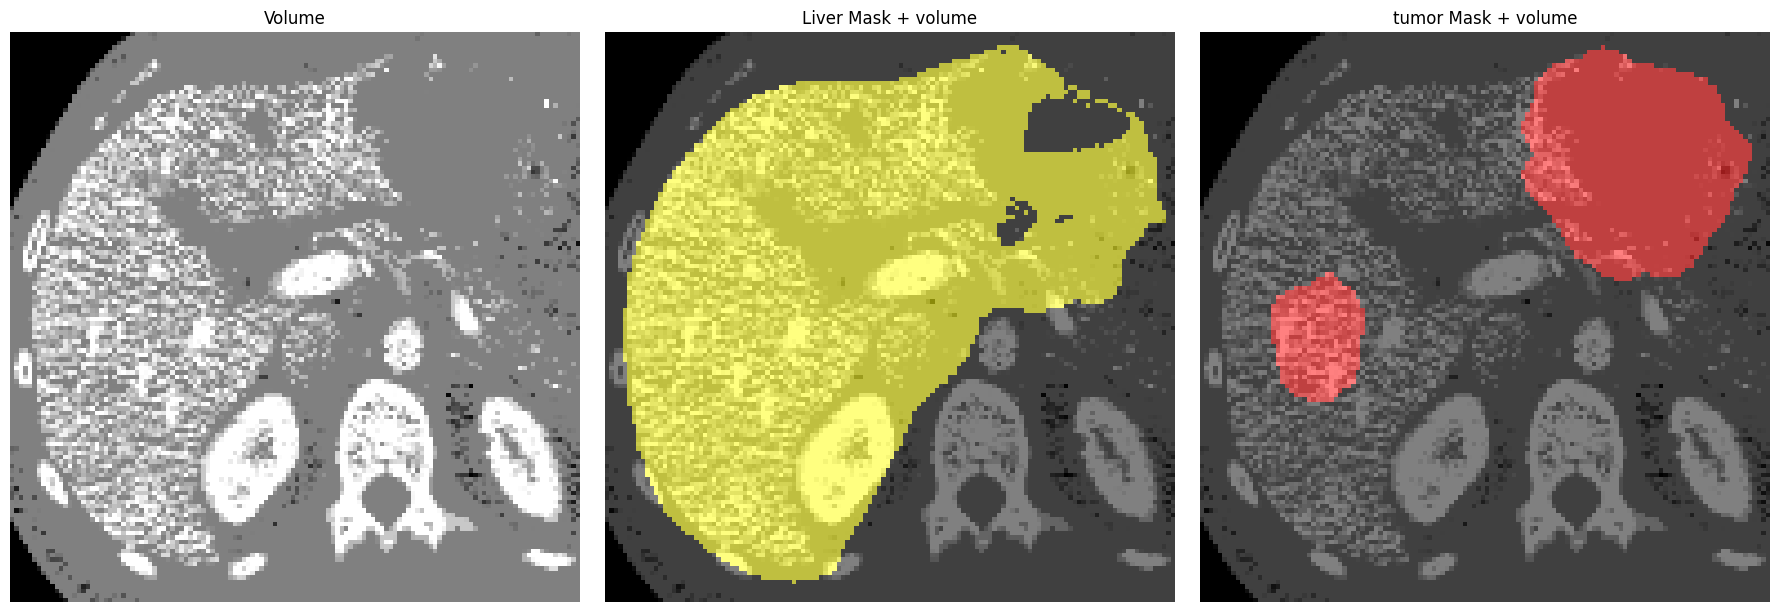

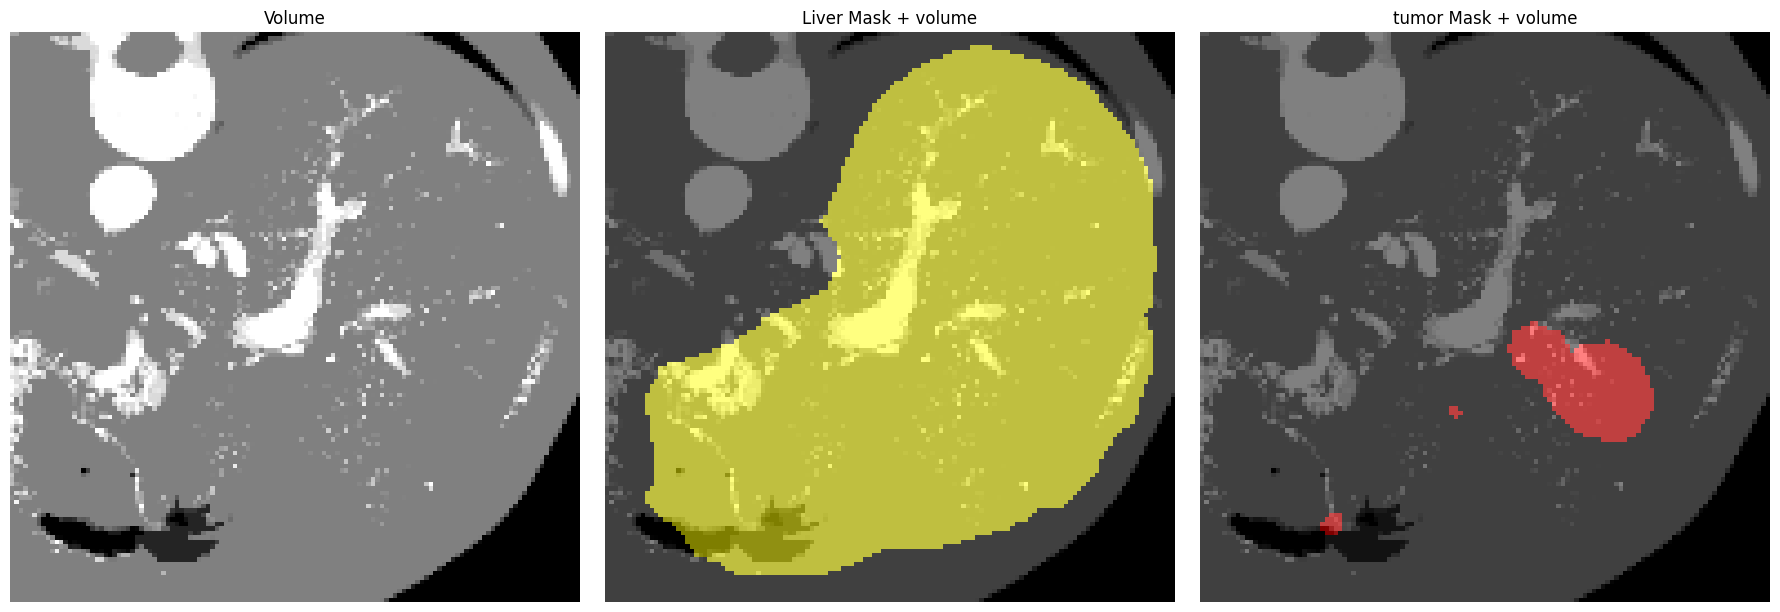

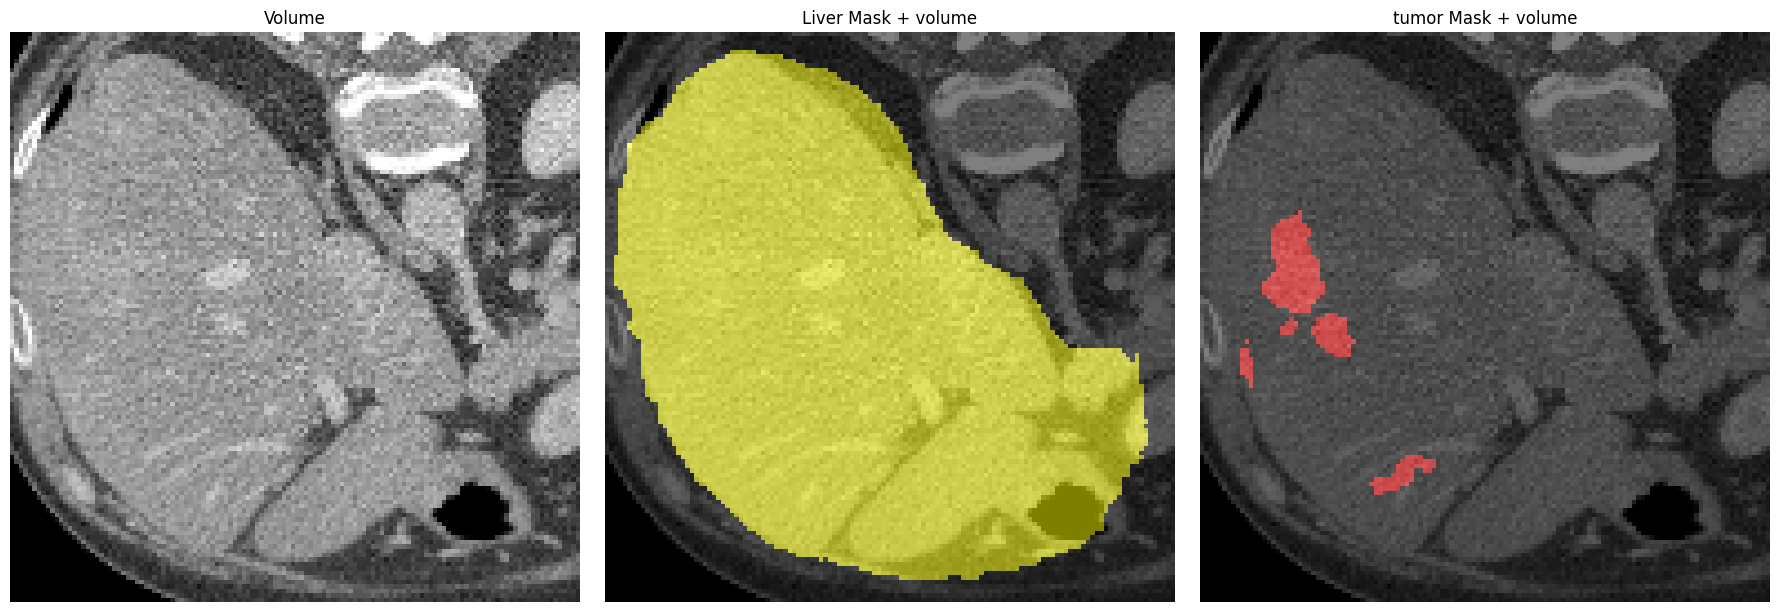

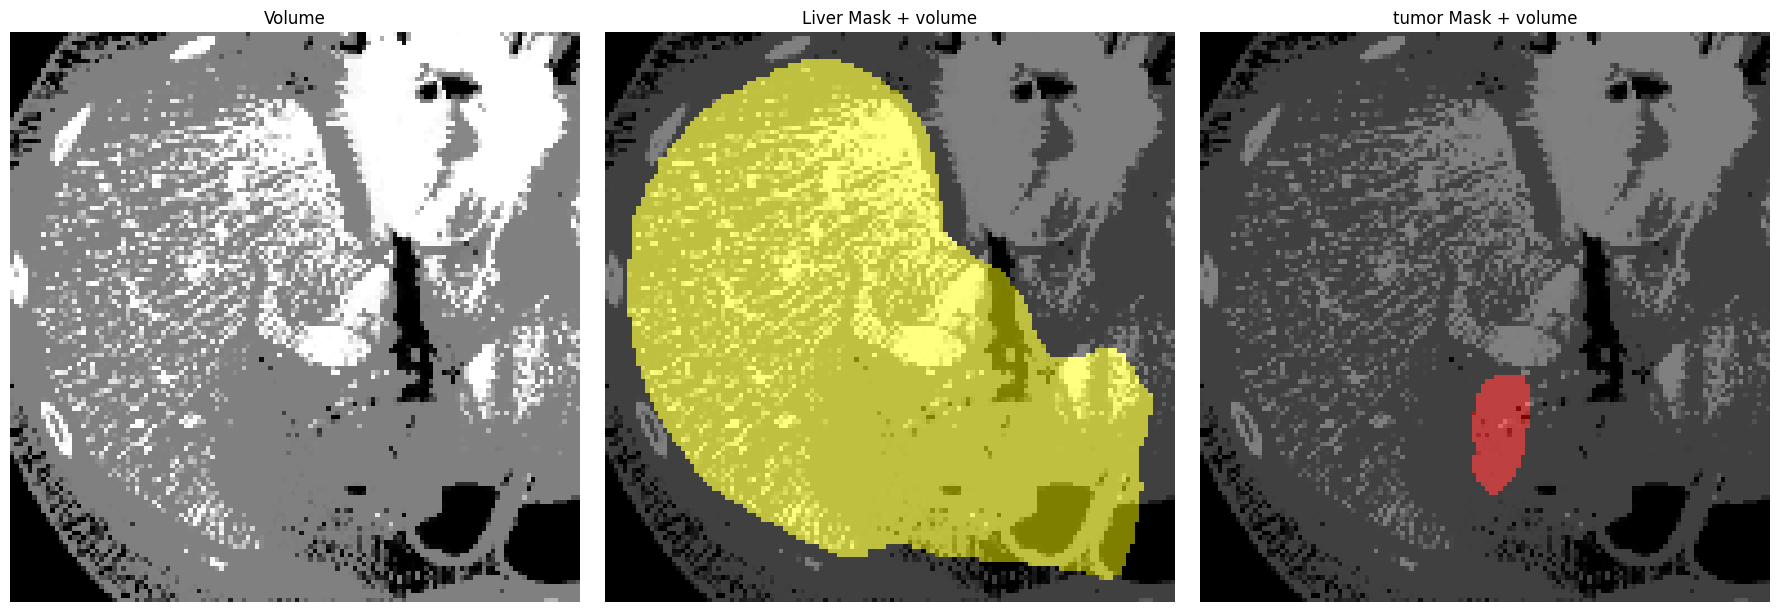

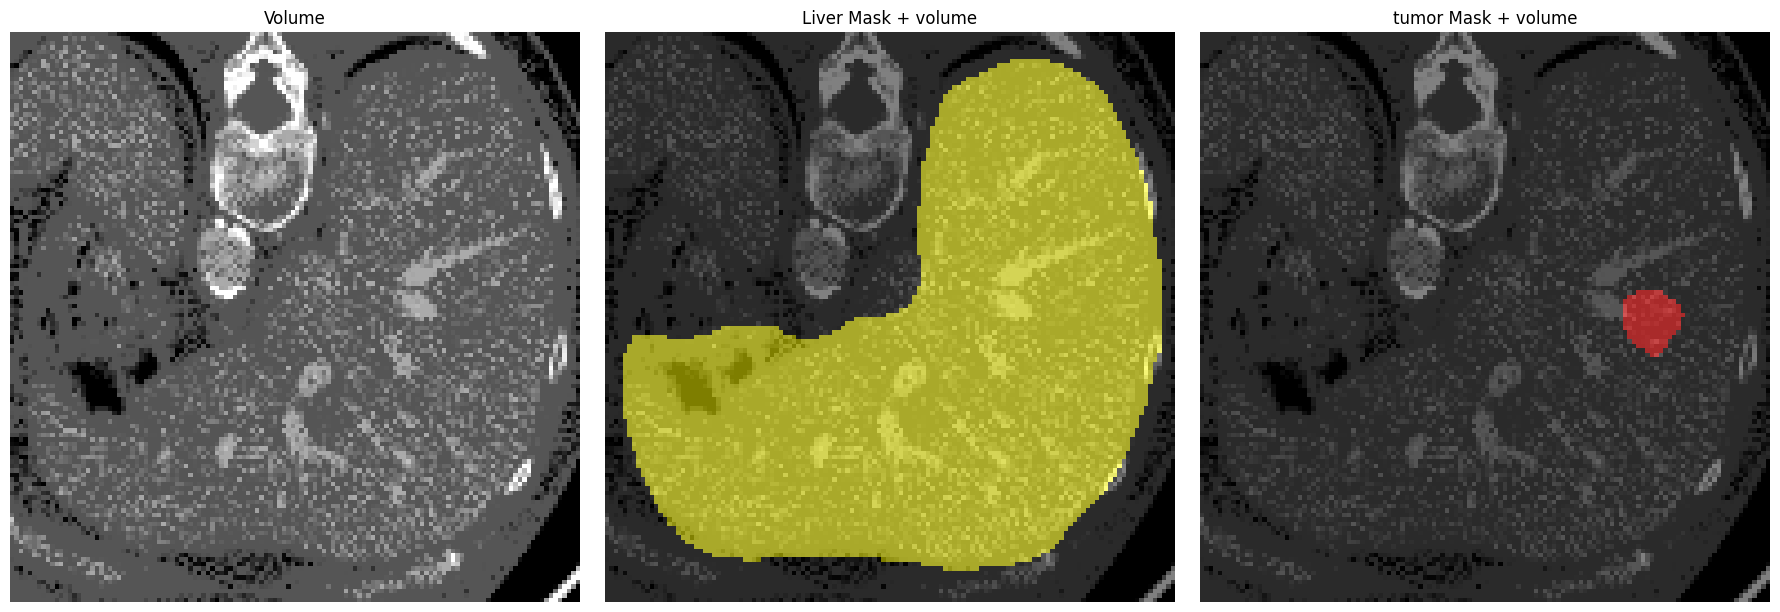

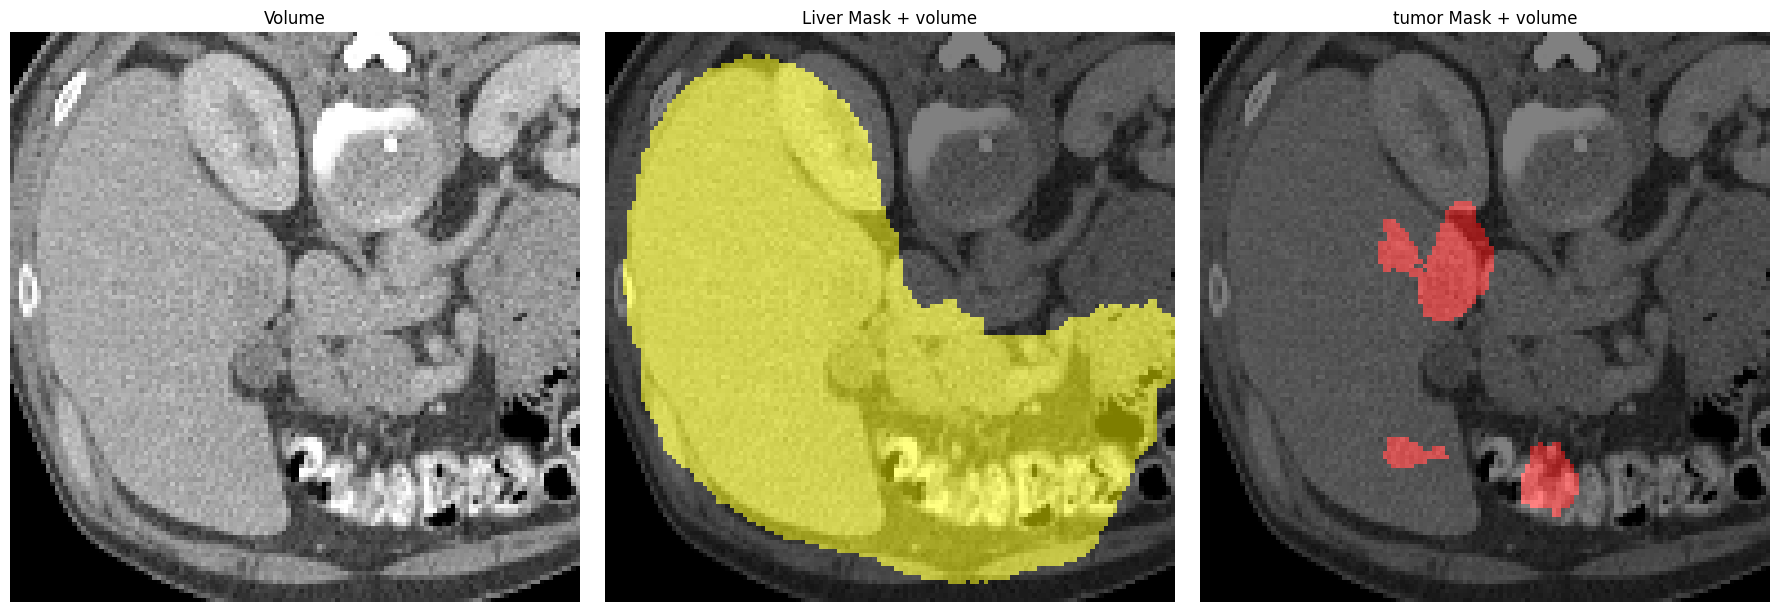

In [ ]:
i = 0
for val_data in val_loader:
    i+= 1

    image = val_data["image"]
    label = val_data["label"]
    liver_mask = val_data["liver_mask"]
    visualize_from_loader(image, label, liver_mask)

    if i == 10:
      break

## Training

In [ ]:
criterion = DiceLossWSigmoid().to(device)
# criterion = TverskyLossWSigmoid(use_fc=True).to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [ ]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_tumor,
    loss_epochs,
    trains_epoch,
    ious_tumor,
    precisions_tumor,
    recalls_tumor,
    time_tmp
) = trainer_stage2(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
    post_fix="tumor"
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.9933 time 6.67s
Epoch 1/100 2/105 loss: 0.9460 time 2.95s
Epoch 1/100 3/105 loss: 0.9389 time 4.68s
Epoch 1/100 4/105 loss: 0.9284 time 2.30s
Epoch 1/100 5/105 loss: 0.9230 time 4.73s
Epoch 1/100 6/105 loss: 0.9183 time 1.91s
Epoch 1/100 7/105 loss: 0.9113 time 1.53s
Epoch 1/100 8/105 loss: 0.9063 time 4.56s
Epoch 1/100 9/105 loss: 0.9021 time 0.80s
Epoch 1/100 10/105 loss: 0.8983 time 0.89s
Epoch 1/100 11/105 loss: 0.8946 time 2.80s
Epoch 1/100 12/105 loss: 0.8919 time 5.84s
Epoch 1/100 13/105 loss: 0.8881 time 1.13s
Epoch 1/100 14/105 loss: 0.8853 time 5.29s
Epoch 1/100 15/105 loss: 0.8820 time 4.76s
Epoch 1/100 16/105 loss: 0.8788 time 4.40s
Epoch 1/100 17/105 loss: 0.8759 time 4.63s
Epoch 1/100 18/105 loss: 0.8732 time 4.52s
Epoch 1/100 19/105 loss: 0.8707 time 2.71s
Epoch 1/100 20/105 loss: 0.8681 time 4.30s
Epoch 1/100 21/105 loss: 0.8657 time 4.68s
Epoch 1/100 22/105 loss: 0.8633 time 1.07s
Epoch 1/100 23/105 loss: 0.8612 time 4.91s
Epoch 1/100 24/105 l

Final training epochs: 1/100 ---[loss: 0.7649] ---[time 359.21s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.7649] ---[time 359.21s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.7649 time 3.68s


Val 1/100 1/26, Dice_Tumor: 0.000000, time 3.39s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Tumor: 0.000000, time 3.39s
Val 1/100 2/26, Dice_Tumor: 0.000000, time 1.07s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Tumor: 0.000000, time 1.07s
Val 1/100 3/26, Dice_Tumor: 0.000000, time 0.97s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Tumor: 0.000000, time 0.97s
Val 1/100 4/26, Dice_Tumor: 0.000000, time 2.35s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Tumor: 0.000000, time 2.35s
Val 1/100 5/26, Dice_Tumor: 0.000000, time 1.66s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Tumor: 0.000000, time 1.66s
Val 1/100 6/26, Dice_Tumor: 0.000000, time 1.88s
INFO:kltn.utils.logger:Val 1/100 6/26, Dice_Tumor: 0.000000, time 1.88s
Val 1/100 7/26, Dice_Tumor: 0.000000, time 3.98s
INFO:kltn.utils.logger:Val 1/100 7/26, Dice_Tumor: 0.000000, time 3.98s
Val 1/100 8/26, Dice_Tumor: 0.000000, time 1.02s
INFO:kltn.utils.logger:Val 1/100 8/26, Dice_Tumor: 0.000000, time 1.02s
Val 1/100 9/26, Dice_Tumor: 0.00

Epoch 2/100 1/105 loss: 0.7248 time 1.44s
Epoch 2/100 2/105 loss: 0.3729 time 4.96s
Epoch 2/100 3/105 loss: 0.4890 time 4.19s
Epoch 2/100 4/105 loss: 0.5466 time 4.22s
Epoch 2/100 5/105 loss: 0.5813 time 5.76s
Epoch 2/100 6/105 loss: 0.6082 time 4.46s
Epoch 2/100 7/105 loss: 0.6250 time 4.27s
Epoch 2/100 8/105 loss: 0.6389 time 1.89s
Epoch 2/100 9/105 loss: 0.6486 time 0.71s
Epoch 2/100 10/105 loss: 0.6557 time 5.22s
Epoch 2/100 11/105 loss: 0.6613 time 4.20s
Epoch 2/100 12/105 loss: 0.6671 time 4.42s
Epoch 2/100 13/105 loss: 0.6710 time 0.83s
Epoch 2/100 14/105 loss: 0.6744 time 4.24s
Epoch 2/100 15/105 loss: 0.6772 time 5.98s
Epoch 2/100 16/105 loss: 0.6801 time 4.00s
Epoch 2/100 17/105 loss: 0.6832 time 1.05s
Epoch 2/100 18/105 loss: 0.6851 time 3.13s
Epoch 2/100 19/105 loss: 0.6874 time 4.58s
Epoch 2/100 20/105 loss: 0.6889 time 4.02s
Epoch 2/100 21/105 loss: 0.6902 time 5.49s
Epoch 2/100 22/105 loss: 0.6915 time 2.07s
Epoch 2/100 23/105 loss: 0.6931 time 1.89s
Epoch 2/100 24/105 l

Final training epochs: 2/100 ---[loss: 0.6382] ---[time 349.68s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.6382] ---[time 349.68s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.6382 time 1.01s


Val 2/100 1/26, Dice_Tumor: 0.000000, time 3.15s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Tumor: 0.000000, time 3.15s
Val 2/100 2/26, Dice_Tumor: 0.000000, time 0.80s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Tumor: 0.000000, time 0.80s
Val 2/100 3/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Tumor: 0.000000, time 0.84s
Val 2/100 4/26, Dice_Tumor: 0.000000, time 2.54s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Tumor: 0.000000, time 2.54s
Val 2/100 5/26, Dice_Tumor: 0.000000, time 1.61s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Tumor: 0.000000, time 1.61s
Val 2/100 6/26, Dice_Tumor: 0.000000, time 1.89s
INFO:kltn.utils.logger:Val 2/100 6/26, Dice_Tumor: 0.000000, time 1.89s
Val 2/100 7/26, Dice_Tumor: 0.000000, time 4.80s
INFO:kltn.utils.logger:Val 2/100 7/26, Dice_Tumor: 0.000000, time 4.80s
Val 2/100 8/26, Dice_Tumor: 0.000000, time 0.86s
INFO:kltn.utils.logger:Val 2/100 8/26, Dice_Tumor: 0.000000, time 0.86s
Val 2/100 9/26, Dice_Tumor: 0.00

Epoch 3/100 1/105 loss: 0.7188 time 6.84s
Epoch 3/100 2/105 loss: 0.7151 time 5.39s
Epoch 3/100 3/105 loss: 0.7177 time 2.18s
Epoch 3/100 4/105 loss: 0.7220 time 2.33s
Epoch 3/100 5/105 loss: 0.5788 time 5.73s
Epoch 3/100 6/105 loss: 0.4834 time 0.93s
Epoch 3/100 7/105 loss: 0.5156 time 3.74s
Epoch 3/100 8/105 loss: 0.5395 time 3.88s
Epoch 3/100 9/105 loss: 0.4802 time 1.34s
Epoch 3/100 10/105 loss: 0.5028 time 5.12s
Epoch 3/100 11/105 loss: 0.5213 time 4.34s
Epoch 3/100 12/105 loss: 0.5369 time 4.03s
Epoch 3/100 13/105 loss: 0.5503 time 4.62s
Epoch 3/100 14/105 loss: 0.5114 time 4.63s
Epoch 3/100 15/105 loss: 0.4777 time 5.39s
Epoch 3/100 16/105 loss: 0.4923 time 3.92s
Epoch 3/100 17/105 loss: 0.5049 time 4.00s
Epoch 3/100 18/105 loss: 0.5178 time 4.30s
Epoch 3/100 19/105 loss: 0.5277 time 6.31s
Epoch 3/100 20/105 loss: 0.5366 time 2.12s
Epoch 3/100 21/105 loss: 0.5456 time 0.85s
Epoch 3/100 22/105 loss: 0.5529 time 4.98s
Epoch 3/100 23/105 loss: 0.5596 time 2.01s
Epoch 3/100 24/105 l

Final training epochs: 3/100 ---[loss: 0.6331] ---[time 352.05s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.6331] ---[time 352.05s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.6331 time 2.51s


Val 3/100 1/26, Dice_Tumor: 0.000000, time 2.90s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Tumor: 0.000000, time 2.90s
Val 3/100 2/26, Dice_Tumor: 0.000000, time 0.90s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Tumor: 0.000000, time 0.90s
Val 3/100 3/26, Dice_Tumor: 0.000000, time 0.71s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Tumor: 0.000000, time 0.71s
Val 3/100 4/26, Dice_Tumor: 0.000000, time 2.50s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Tumor: 0.000000, time 2.50s
Val 3/100 5/26, Dice_Tumor: 0.000000, time 1.60s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Tumor: 0.000000, time 1.60s
Val 3/100 6/26, Dice_Tumor: 0.000000, time 1.87s
INFO:kltn.utils.logger:Val 3/100 6/26, Dice_Tumor: 0.000000, time 1.87s
Val 3/100 7/26, Dice_Tumor: 0.000000, time 4.73s
INFO:kltn.utils.logger:Val 3/100 7/26, Dice_Tumor: 0.000000, time 4.73s
Val 3/100 8/26, Dice_Tumor: 0.000000, time 1.05s
INFO:kltn.utils.logger:Val 3/100 8/26, Dice_Tumor: 0.000000, time 1.05s
Val 3/100 9/26, Dice_Tumor: 0.00

Epoch 4/100 1/105 loss: 0.7090 time 5.83s
Epoch 4/100 2/105 loss: 0.7105 time 3.55s
Epoch 4/100 3/105 loss: 0.7086 time 4.59s
Epoch 4/100 4/105 loss: 0.7075 time 3.63s
Epoch 4/100 5/105 loss: 0.7071 time 1.27s
Epoch 4/100 6/105 loss: 0.7067 time 1.59s
Epoch 4/100 7/105 loss: 0.7064 time 6.15s
Epoch 4/100 8/105 loss: 0.7063 time 4.22s
Epoch 4/100 9/105 loss: 0.7064 time 2.00s
Epoch 4/100 10/105 loss: 0.7061 time 4.16s
Epoch 4/100 11/105 loss: 0.7060 time 0.67s
Epoch 4/100 12/105 loss: 0.7059 time 3.92s
Epoch 4/100 13/105 loss: 0.7058 time 1.96s
Epoch 4/100 14/105 loss: 0.7058 time 1.21s
Epoch 4/100 15/105 loss: 0.6590 time 1.69s
Epoch 4/100 16/105 loss: 0.6624 time 1.53s
Epoch 4/100 17/105 loss: 0.6649 time 6.62s
Epoch 4/100 18/105 loss: 0.6671 time 2.58s
Epoch 4/100 19/105 loss: 0.6321 time 5.77s
Epoch 4/100 20/105 loss: 0.6357 time 4.52s
Epoch 4/100 21/105 loss: 0.6056 time 5.57s
Epoch 4/100 22/105 loss: 0.6101 time 1.27s
Epoch 4/100 23/105 loss: 0.6142 time 1.57s
Epoch 4/100 24/105 l

Final training epochs: 4/100 ---[loss: 0.6315] ---[time 354.69s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.6315] ---[time 354.69s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.6315 time 5.14s


Val 4/100 1/26, Dice_Tumor: 0.000000, time 2.95s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Tumor: 0.000000, time 2.95s
Val 4/100 2/26, Dice_Tumor: 0.000000, time 0.85s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Tumor: 0.000000, time 0.85s
Val 4/100 3/26, Dice_Tumor: 0.000000, time 0.80s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Tumor: 0.000000, time 0.80s
Val 4/100 4/26, Dice_Tumor: 0.000000, time 2.58s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Tumor: 0.000000, time 2.58s
Val 4/100 5/26, Dice_Tumor: 0.000000, time 1.79s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Tumor: 0.000000, time 1.79s
Val 4/100 6/26, Dice_Tumor: 0.000000, time 2.52s
INFO:kltn.utils.logger:Val 4/100 6/26, Dice_Tumor: 0.000000, time 2.52s
Val 4/100 7/26, Dice_Tumor: 0.000000, time 3.66s
INFO:kltn.utils.logger:Val 4/100 7/26, Dice_Tumor: 0.000000, time 3.66s
Val 4/100 8/26, Dice_Tumor: 0.000000, time 1.07s
INFO:kltn.utils.logger:Val 4/100 8/26, Dice_Tumor: 0.000000, time 1.07s
Val 4/100 9/26, Dice_Tumor: 0.00

Epoch 5/100 1/105 loss: 0.7124 time 1.93s
Epoch 5/100 2/105 loss: 0.3579 time 1.19s
Epoch 5/100 3/105 loss: 0.4731 time 6.26s
Epoch 5/100 4/105 loss: 0.5314 time 1.55s
Epoch 5/100 5/105 loss: 0.5659 time 4.56s
Epoch 5/100 6/105 loss: 0.5889 time 4.40s
Epoch 5/100 7/105 loss: 0.6052 time 3.63s
Epoch 5/100 8/105 loss: 0.5299 time 4.13s
Epoch 5/100 9/105 loss: 0.5490 time 5.24s
Epoch 5/100 10/105 loss: 0.5645 time 3.90s
Epoch 5/100 11/105 loss: 0.5772 time 1.37s
Epoch 5/100 12/105 loss: 0.5879 time 5.23s
Epoch 5/100 13/105 loss: 0.5977 time 0.81s
Epoch 5/100 14/105 loss: 0.6057 time 4.81s
Epoch 5/100 15/105 loss: 0.6123 time 1.62s
Epoch 5/100 16/105 loss: 0.6201 time 1.89s
Epoch 5/100 17/105 loss: 0.6283 time 1.33s
Epoch 5/100 18/105 loss: 0.6327 time 5.13s
Epoch 5/100 19/105 loss: 0.6372 time 4.52s
Epoch 5/100 20/105 loss: 0.6408 time 2.84s
Epoch 5/100 21/105 loss: 0.6442 time 5.72s
Epoch 5/100 22/105 loss: 0.6469 time 0.67s
Epoch 5/100 23/105 loss: 0.6496 time 3.55s
Epoch 5/100 24/105 l

Final training epochs: 5/100 ---[loss: 0.6320] ---[time 353.15s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.6320] ---[time 353.15s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.6320 time 1.35s


Val 5/100 1/26, Dice_Tumor: 0.000000, time 3.01s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Tumor: 0.000000, time 3.01s
Val 5/100 2/26, Dice_Tumor: 0.000000, time 0.82s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Tumor: 0.000000, time 0.82s
Val 5/100 3/26, Dice_Tumor: 0.000000, time 0.83s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Tumor: 0.000000, time 0.83s
Val 5/100 4/26, Dice_Tumor: 0.000000, time 3.02s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Tumor: 0.000000, time 3.02s
Val 5/100 5/26, Dice_Tumor: 0.000000, time 1.98s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Tumor: 0.000000, time 1.98s
Val 5/100 6/26, Dice_Tumor: 0.000000, time 1.65s
INFO:kltn.utils.logger:Val 5/100 6/26, Dice_Tumor: 0.000000, time 1.65s
Val 5/100 7/26, Dice_Tumor: 0.000000, time 3.94s
INFO:kltn.utils.logger:Val 5/100 7/26, Dice_Tumor: 0.000000, time 3.94s
Val 5/100 8/26, Dice_Tumor: 0.000000, time 1.12s
INFO:kltn.utils.logger:Val 5/100 8/26, Dice_Tumor: 0.000000, time 1.12s
Val 5/100 9/26, Dice_Tumor: 0.00

Epoch 6/100 1/105 loss: 0.7098 time 5.14s
Epoch 6/100 2/105 loss: 0.7200 time 1.78s
Epoch 6/100 3/105 loss: 0.7145 time 5.47s
Epoch 6/100 4/105 loss: 0.7119 time 3.32s
Epoch 6/100 5/105 loss: 0.7139 time 4.34s
Epoch 6/100 6/105 loss: 0.7141 time 6.73s
Epoch 6/100 7/105 loss: 0.7140 time 3.94s
Epoch 6/100 8/105 loss: 0.7126 time 3.58s
Epoch 6/100 9/105 loss: 0.7128 time 1.21s
Epoch 6/100 10/105 loss: 0.6418 time 0.94s
Epoch 6/100 11/105 loss: 0.6483 time 0.67s
Epoch 6/100 12/105 loss: 0.6529 time 1.21s
Epoch 6/100 13/105 loss: 0.6568 time 4.22s
Epoch 6/100 14/105 loss: 0.6601 time 3.50s
Epoch 6/100 15/105 loss: 0.6630 time 1.14s
Epoch 6/100 16/105 loss: 0.6218 time 4.62s
Epoch 6/100 17/105 loss: 0.6266 time 3.84s
Epoch 6/100 18/105 loss: 0.6325 time 4.07s
Epoch 6/100 19/105 loss: 0.6363 time 3.72s
Epoch 6/100 20/105 loss: 0.6397 time 1.03s
Epoch 6/100 21/105 loss: 0.6429 time 4.96s
Epoch 6/100 22/105 loss: 0.6457 time 3.24s
Epoch 6/100 23/105 loss: 0.6481 time 2.03s
Epoch 6/100 24/105 l

Final training epochs: 6/100 ---[loss: 0.6372] ---[time 356.60s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.6372] ---[time 356.60s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.6372 time 1.71s


Val 6/100 1/26, Dice_Tumor: 0.000000, time 3.15s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Tumor: 0.000000, time 3.15s
Val 6/100 2/26, Dice_Tumor: 0.000000, time 0.80s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Tumor: 0.000000, time 0.80s
Val 6/100 3/26, Dice_Tumor: 0.000000, time 0.81s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Tumor: 0.000000, time 0.81s
Val 6/100 4/26, Dice_Tumor: 0.000000, time 2.55s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Tumor: 0.000000, time 2.55s
Val 6/100 5/26, Dice_Tumor: 0.000000, time 1.59s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Tumor: 0.000000, time 1.59s
Val 6/100 6/26, Dice_Tumor: 0.000000, time 1.92s
INFO:kltn.utils.logger:Val 6/100 6/26, Dice_Tumor: 0.000000, time 1.92s
Val 6/100 7/26, Dice_Tumor: 0.000000, time 4.74s
INFO:kltn.utils.logger:Val 6/100 7/26, Dice_Tumor: 0.000000, time 4.74s
Val 6/100 8/26, Dice_Tumor: 0.000000, time 0.86s
INFO:kltn.utils.logger:Val 6/100 8/26, Dice_Tumor: 0.000000, time 0.86s
Val 6/100 9/26, Dice_Tumor: 0.00

Epoch 7/100 1/105 loss: 0.0025 time 1.43s
Epoch 7/100 2/105 loss: 0.3533 time 0.79s
Epoch 7/100 3/105 loss: 0.4756 time 1.33s
Epoch 7/100 4/105 loss: 0.5322 time 4.80s
Epoch 7/100 5/105 loss: 0.5728 time 2.93s
Epoch 7/100 6/105 loss: 0.6001 time 2.58s
Epoch 7/100 7/105 loss: 0.6148 time 4.07s
Epoch 7/100 8/105 loss: 0.6259 time 3.96s
Epoch 7/100 9/105 loss: 0.6356 time 4.27s
Epoch 7/100 10/105 loss: 0.6432 time 4.43s
Epoch 7/100 11/105 loss: 0.6486 time 1.85s
Epoch 7/100 12/105 loss: 0.6533 time 1.15s
Epoch 7/100 13/105 loss: 0.6576 time 2.76s
Epoch 7/100 14/105 loss: 0.6609 time 3.62s
Epoch 7/100 15/105 loss: 0.6172 time 4.48s
Epoch 7/100 16/105 loss: 0.6227 time 1.13s
Epoch 7/100 17/105 loss: 0.5863 time 5.22s
Epoch 7/100 18/105 loss: 0.5937 time 0.67s
Epoch 7/100 19/105 loss: 0.5627 time 1.37s
Epoch 7/100 20/105 loss: 0.5697 time 0.67s
Epoch 7/100 21/105 loss: 0.5761 time 5.64s
Epoch 7/100 22/105 loss: 0.5832 time 5.22s
Epoch 7/100 23/105 loss: 0.5897 time 4.67s
Epoch 7/100 24/105 l

Final training epochs: 7/100 ---[loss: 0.6325] ---[time 351.44s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.6325] ---[time 351.44s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.6325 time 1.45s


Val 7/100 1/26, Dice_Tumor: 0.000000, time 3.21s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Tumor: 0.000000, time 3.21s
Val 7/100 2/26, Dice_Tumor: 0.000000, time 0.82s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Tumor: 0.000000, time 0.82s
Val 7/100 3/26, Dice_Tumor: 0.000000, time 0.80s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Tumor: 0.000000, time 0.80s
Val 7/100 4/26, Dice_Tumor: 0.000000, time 2.57s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Tumor: 0.000000, time 2.57s
Val 7/100 5/26, Dice_Tumor: 0.053050, time 1.69s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Tumor: 0.053050, time 1.69s
Val 7/100 6/26, Dice_Tumor: 0.000000, time 1.82s
INFO:kltn.utils.logger:Val 7/100 6/26, Dice_Tumor: 0.000000, time 1.82s
Val 7/100 7/26, Dice_Tumor: 0.000000, time 4.68s
INFO:kltn.utils.logger:Val 7/100 7/26, Dice_Tumor: 0.000000, time 4.68s
Val 7/100 8/26, Dice_Tumor: 0.000000, time 0.95s
INFO:kltn.utils.logger:Val 7/100 8/26, Dice_Tumor: 0.000000, time 0.95s
Val 7/100 9/26, Dice_Tumor: 0.00

New best (0.000000 --> 0.002040). At epoch 7



==============================Training epoch 8==============================
INFO:kltn.utils.logger:
==============================Training epoch 8==============================


Epoch 8/100 1/105 loss: 0.7038 time 5.33s
Epoch 8/100 2/105 loss: 0.7156 time 2.01s
Epoch 8/100 3/105 loss: 0.6190 time 1.38s
Epoch 8/100 4/105 loss: 0.6405 time 4.56s
Epoch 8/100 5/105 loss: 0.6528 time 4.01s
Epoch 8/100 6/105 loss: 0.6620 time 2.66s
Epoch 8/100 7/105 loss: 0.6682 time 1.29s
Epoch 8/100 8/105 loss: 0.6726 time 4.30s
Epoch 8/100 9/105 loss: 0.6518 time 3.85s
Epoch 8/100 10/105 loss: 0.6570 time 1.58s
Epoch 8/100 11/105 loss: 0.6164 time 4.80s
Epoch 8/100 12/105 loss: 0.6238 time 1.25s
Epoch 8/100 13/105 loss: 0.6347 time 4.30s
Epoch 8/100 14/105 loss: 0.6415 time 5.00s
Epoch 8/100 15/105 loss: 0.6456 time 4.12s
Epoch 8/100 16/105 loss: 0.6493 time 0.86s
Epoch 8/100 17/105 loss: 0.6526 time 5.99s
Epoch 8/100 18/105 loss: 0.6383 time 3.59s
Epoch 8/100 19/105 loss: 0.6418 time 1.25s
Epoch 8/100 20/105 loss: 0.6449 time 1.71s
Epoch 8/100 21/105 loss: 0.6484 time 4.68s
Epoch 8/100 22/105 loss: 0.6509 time 3.43s
Epoch 8/100 23/105 loss: 0.6532 time 1.70s
Epoch 8/100 24/105 l

Final training epochs: 8/100 ---[loss: 0.6426] ---[time 358.94s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.6426] ---[time 358.94s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.6426 time 5.18s


Val 8/100 1/26, Dice_Tumor: 0.000000, time 2.95s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Tumor: 0.000000, time 2.95s
Val 8/100 2/26, Dice_Tumor: 0.000000, time 0.83s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Tumor: 0.000000, time 0.83s
Val 8/100 3/26, Dice_Tumor: 0.000000, time 0.81s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Tumor: 0.000000, time 0.81s
Val 8/100 4/26, Dice_Tumor: 0.000000, time 2.83s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Tumor: 0.000000, time 2.83s
Val 8/100 5/26, Dice_Tumor: 0.571283, time 1.81s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Tumor: 0.571283, time 1.81s
Val 8/100 6/26, Dice_Tumor: 0.000000, time 1.98s
INFO:kltn.utils.logger:Val 8/100 6/26, Dice_Tumor: 0.000000, time 1.98s
Val 8/100 7/26, Dice_Tumor: 0.000000, time 3.98s
INFO:kltn.utils.logger:Val 8/100 7/26, Dice_Tumor: 0.000000, time 3.98s
Val 8/100 8/26, Dice_Tumor: 0.000000, time 1.01s
INFO:kltn.utils.logger:Val 8/100 8/26, Dice_Tumor: 0.000000, time 1.01s
Val 8/100 9/26, Dice_Tumor: 0.06

New best (0.002040 --> 0.055920). At epoch 8
Epoch 9/100 1/105 loss: 0.1980 time 2.15s
Epoch 9/100 2/105 loss: 0.1008 time 4.80s
Epoch 9/100 3/105 loss: 0.3015 time 6.72s
Epoch 9/100 4/105 loss: 0.4023 time 1.30s
Epoch 9/100 5/105 loss: 0.4665 time 1.69s
Epoch 9/100 6/105 loss: 0.3892 time 0.92s
Epoch 9/100 7/105 loss: 0.4341 time 1.09s
Epoch 9/100 8/105 loss: 0.4676 time 3.64s
Epoch 9/100 9/105 loss: 0.4937 time 2.45s
Epoch 9/100 10/105 loss: 0.5201 time 3.62s
Epoch 9/100 11/105 loss: 0.5368 time 4.27s
Epoch 9/100 12/105 loss: 0.5505 time 4.22s
Epoch 9/100 13/105 loss: 0.5623 time 1.50s
Epoch 9/100 14/105 loss: 0.5728 time 0.77s
Epoch 9/100 15/105 loss: 0.5824 time 4.93s
Epoch 9/100 16/105 loss: 0.5900 time 2.42s
Epoch 9/100 17/105 loss: 0.5976 time 4.34s
Epoch 9/100 18/105 loss: 0.6037 time 5.05s
Epoch 9/100 19/105 loss: 0.6089 time 3.74s
Epoch 9/100 20/105 loss: 0.6145 time 2.27s
Epoch 9/100 21/105 loss: 0.6193 time 7.09s
Epoch 9/100 22/105 loss: 0.6183 time 2.21s
Epoch 9/100 23/105

Final training epochs: 9/100 ---[loss: 0.6320] ---[time 360.91s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.6320] ---[time 360.91s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.6320 time 5.75s


Val 9/100 1/26, Dice_Tumor: 0.000000, time 2.85s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Tumor: 0.000000, time 2.85s
Val 9/100 2/26, Dice_Tumor: 0.000000, time 0.87s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Tumor: 0.000000, time 0.87s
Val 9/100 3/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Tumor: 0.000000, time 0.84s
Val 9/100 4/26, Dice_Tumor: 0.000000, time 2.64s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Tumor: 0.000000, time 2.64s
Val 9/100 5/26, Dice_Tumor: 0.349808, time 1.80s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Tumor: 0.349808, time 1.80s
Val 9/100 6/26, Dice_Tumor: 0.000000, time 2.26s
INFO:kltn.utils.logger:Val 9/100 6/26, Dice_Tumor: 0.000000, time 2.26s
Val 9/100 7/26, Dice_Tumor: 0.000000, time 4.12s
INFO:kltn.utils.logger:Val 9/100 7/26, Dice_Tumor: 0.000000, time 4.12s
Val 9/100 8/26, Dice_Tumor: 0.000000, time 1.06s
INFO:kltn.utils.logger:Val 9/100 8/26, Dice_Tumor: 0.000000, time 1.06s
Val 9/100 9/26, Dice_Tumor: 0.00

Epoch 10/100 1/105 loss: 0.7229 time 3.15s
Epoch 10/100 2/105 loss: 0.6426 time 4.16s
Epoch 10/100 3/105 loss: 0.6659 time 1.13s
Epoch 10/100 4/105 loss: 0.6752 time 5.92s
Epoch 10/100 5/105 loss: 0.6247 time 4.07s
Epoch 10/100 6/105 loss: 0.5213 time 0.96s
Epoch 10/100 7/105 loss: 0.5483 time 4.20s
Epoch 10/100 8/105 loss: 0.5713 time 1.49s
Epoch 10/100 9/105 loss: 0.5821 time 4.96s
Epoch 10/100 10/105 loss: 0.5929 time 1.49s
Epoch 10/100 11/105 loss: 0.6033 time 5.21s
Epoch 10/100 12/105 loss: 0.6124 time 0.72s
Epoch 10/100 13/105 loss: 0.6196 time 1.19s
Epoch 10/100 14/105 loss: 0.6256 time 5.40s
Epoch 10/100 15/105 loss: 0.6307 time 4.19s
Epoch 10/100 16/105 loss: 0.6352 time 3.96s
Epoch 10/100 17/105 loss: 0.6391 time 1.12s
Epoch 10/100 18/105 loss: 0.6037 time 6.24s
Epoch 10/100 19/105 loss: 0.6088 time 4.02s
Epoch 10/100 20/105 loss: 0.6135 time 2.31s
Epoch 10/100 21/105 loss: 0.6177 time 0.66s
Epoch 10/100 22/105 loss: 0.6247 time 4.24s
Epoch 10/100 23/105 loss: 0.6301 time 5.2

Final training epochs: 10/100 ---[loss: 0.6070] ---[time 363.45s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.6070] ---[time 363.45s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.6070 time 4.22s


Val 10/100 1/26, Dice_Tumor: 0.000000, time 3.04s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Tumor: 0.000000, time 3.04s
Val 10/100 2/26, Dice_Tumor: 0.000000, time 0.87s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Tumor: 0.000000, time 0.87s
Val 10/100 3/26, Dice_Tumor: 0.000000, time 0.87s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Tumor: 0.000000, time 0.87s
Val 10/100 4/26, Dice_Tumor: 0.000000, time 2.57s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Tumor: 0.000000, time 2.57s
Val 10/100 5/26, Dice_Tumor: 0.620413, time 2.21s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Tumor: 0.620413, time 2.21s
Val 10/100 6/26, Dice_Tumor: 0.000000, time 1.95s
INFO:kltn.utils.logger:Val 10/100 6/26, Dice_Tumor: 0.000000, time 1.95s
Val 10/100 7/26, Dice_Tumor: 0.000000, time 4.11s
INFO:kltn.utils.logger:Val 10/100 7/26, Dice_Tumor: 0.000000, time 4.11s
Val 10/100 8/26, Dice_Tumor: 0.000000, time 1.06s
INFO:kltn.utils.logger:Val 10/100 8/26, Dice_Tumor: 0.000000, time 1.06s
Val 10/100 9/26,

Epoch 11/100 1/105 loss: 0.7030 time 1.57s
Epoch 11/100 2/105 loss: 0.3523 time 4.69s
Epoch 11/100 3/105 loss: 0.4686 time 4.35s
Epoch 11/100 4/105 loss: 0.5376 time 4.99s
Epoch 11/100 5/105 loss: 0.4304 time 1.15s
Epoch 11/100 6/105 loss: 0.4769 time 4.78s
Epoch 11/100 7/105 loss: 0.5090 time 4.80s
Epoch 11/100 8/105 loss: 0.5392 time 5.18s
Epoch 11/100 9/105 loss: 0.5574 time 3.78s
Epoch 11/100 10/105 loss: 0.5722 time 1.19s
Epoch 11/100 11/105 loss: 0.5799 time 4.42s
Epoch 11/100 12/105 loss: 0.5907 time 0.88s
Epoch 11/100 13/105 loss: 0.5898 time 4.69s
Epoch 11/100 14/105 loss: 0.5478 time 5.30s
Epoch 11/100 15/105 loss: 0.5584 time 4.06s
Epoch 11/100 16/105 loss: 0.5674 time 4.21s
Epoch 11/100 17/105 loss: 0.5754 time 1.08s
Epoch 11/100 18/105 loss: 0.5826 time 0.66s
Epoch 11/100 19/105 loss: 0.5796 time 4.26s
Epoch 11/100 20/105 loss: 0.5858 time 1.29s
Epoch 11/100 21/105 loss: 0.5915 time 4.50s
Epoch 11/100 22/105 loss: 0.5860 time 1.68s
Epoch 11/100 23/105 loss: 0.5914 time 2.7

Final training epochs: 11/100 ---[loss: 0.6071] ---[time 361.52s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.6071] ---[time 361.52s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.6071 time 4.41s


Val 11/100 1/26, Dice_Tumor: 0.000000, time 2.98s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Tumor: 0.000000, time 2.98s
Val 11/100 2/26, Dice_Tumor: 0.000000, time 0.80s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Tumor: 0.000000, time 0.80s
Val 11/100 3/26, Dice_Tumor: 0.000000, time 1.17s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Tumor: 0.000000, time 1.17s
Val 11/100 4/26, Dice_Tumor: 0.000000, time 2.70s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Tumor: 0.000000, time 2.70s
Val 11/100 5/26, Dice_Tumor: 0.314673, time 1.69s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Tumor: 0.314673, time 1.69s
Val 11/100 6/26, Dice_Tumor: 0.000000, time 1.86s
INFO:kltn.utils.logger:Val 11/100 6/26, Dice_Tumor: 0.000000, time 1.86s
Val 11/100 7/26, Dice_Tumor: 0.000000, time 4.00s
INFO:kltn.utils.logger:Val 11/100 7/26, Dice_Tumor: 0.000000, time 4.00s
Val 11/100 8/26, Dice_Tumor: 0.153846, time 1.11s
INFO:kltn.utils.logger:Val 11/100 8/26, Dice_Tumor: 0.153846, time 1.11s
Val 11/100 9/26,

New best (0.055920 --> 0.096052). At epoch 11
Epoch 12/100 1/105 loss: 0.4515 time 1.57s
Epoch 12/100 2/105 loss: 0.5781 time 1.14s
Epoch 12/100 3/105 loss: 0.6198 time 4.80s
Epoch 12/100 4/105 loss: 0.6409 time 5.90s
Epoch 12/100 5/105 loss: 0.6536 time 1.41s
Epoch 12/100 6/105 loss: 0.6533 time 1.83s
Epoch 12/100 7/105 loss: 0.6608 time 1.01s
Epoch 12/100 8/105 loss: 0.6556 time 3.08s
Epoch 12/100 9/105 loss: 0.6611 time 4.29s
Epoch 12/100 10/105 loss: 0.6654 time 5.16s
Epoch 12/100 11/105 loss: 0.6052 time 4.33s
Epoch 12/100 12/105 loss: 0.6140 time 4.94s
Epoch 12/100 13/105 loss: 0.6209 time 0.95s
Epoch 12/100 14/105 loss: 0.6267 time 1.25s
Epoch 12/100 15/105 loss: 0.6318 time 4.82s
Epoch 12/100 16/105 loss: 0.6362 time 1.19s
Epoch 12/100 17/105 loss: 0.6404 time 5.39s
Epoch 12/100 18/105 loss: 0.6439 time 4.36s
Epoch 12/100 19/105 loss: 0.6101 time 1.29s
Epoch 12/100 20/105 loss: 0.6153 time 1.74s
Epoch 12/100 21/105 loss: 0.6194 time 4.74s
Epoch 12/100 22/105 loss: 0.6231 time 5

Final training epochs: 12/100 ---[loss: 0.5994] ---[time 357.82s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.5994] ---[time 357.82s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.5994 time 0.99s


Val 12/100 1/26, Dice_Tumor: 0.000000, time 2.99s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Tumor: 0.000000, time 2.99s
Val 12/100 2/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Tumor: 0.000000, time 0.84s
Val 12/100 3/26, Dice_Tumor: 0.000000, time 0.87s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Tumor: 0.000000, time 0.87s
Val 12/100 4/26, Dice_Tumor: 0.000000, time 3.02s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Tumor: 0.000000, time 3.02s
Val 12/100 5/26, Dice_Tumor: 0.443563, time 1.95s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Tumor: 0.443563, time 1.95s
Val 12/100 6/26, Dice_Tumor: 0.000000, time 1.74s
INFO:kltn.utils.logger:Val 12/100 6/26, Dice_Tumor: 0.000000, time 1.74s
Val 12/100 7/26, Dice_Tumor: 0.000000, time 4.04s
INFO:kltn.utils.logger:Val 12/100 7/26, Dice_Tumor: 0.000000, time 4.04s
Val 12/100 8/26, Dice_Tumor: 0.000000, time 1.09s
INFO:kltn.utils.logger:Val 12/100 8/26, Dice_Tumor: 0.000000, time 1.09s
Val 12/100 9/26,

Epoch 13/100 1/105 loss: 0.6682 time 1.53s
Epoch 13/100 2/105 loss: 0.7075 time 3.98s
Epoch 13/100 3/105 loss: 0.7058 time 4.58s
Epoch 13/100 4/105 loss: 0.6579 time 0.78s
Epoch 13/100 5/105 loss: 0.6669 time 2.75s
Epoch 13/100 6/105 loss: 0.5562 time 1.74s
Epoch 13/100 7/105 loss: 0.5238 time 1.68s
Epoch 13/100 8/105 loss: 0.5462 time 4.88s
Epoch 13/100 9/105 loss: 0.5648 time 0.84s
Epoch 13/100 10/105 loss: 0.5786 time 1.23s
Epoch 13/100 11/105 loss: 0.5619 time 4.22s
Epoch 13/100 12/105 loss: 0.5153 time 5.60s
Epoch 13/100 13/105 loss: 0.5261 time 4.09s
Epoch 13/100 14/105 loss: 0.4974 time 1.61s
Epoch 13/100 15/105 loss: 0.4951 time 4.99s
Epoch 13/100 16/105 loss: 0.4987 time 4.40s
Epoch 13/100 17/105 loss: 0.4895 time 4.20s
Epoch 13/100 18/105 loss: 0.5015 time 1.32s
Epoch 13/100 19/105 loss: 0.5122 time 1.33s
Epoch 13/100 20/105 loss: 0.5195 time 3.66s
Epoch 13/100 21/105 loss: 0.5282 time 4.61s
Epoch 13/100 22/105 loss: 0.5357 time 5.35s
Epoch 13/100 23/105 loss: 0.5430 time 4.7

Final training epochs: 13/100 ---[loss: 0.5851] ---[time 358.59s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.5851] ---[time 358.59s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.5851 time 5.44s


Val 13/100 1/26, Dice_Tumor: 0.000000, time 2.93s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Tumor: 0.000000, time 2.93s
Val 13/100 2/26, Dice_Tumor: 0.000000, time 0.82s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Tumor: 0.000000, time 0.82s
Val 13/100 3/26, Dice_Tumor: 0.000000, time 0.81s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Tumor: 0.000000, time 0.81s
Val 13/100 4/26, Dice_Tumor: 0.000000, time 2.61s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Tumor: 0.000000, time 2.61s
Val 13/100 5/26, Dice_Tumor: 0.363095, time 1.57s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Tumor: 0.363095, time 1.57s
Val 13/100 6/26, Dice_Tumor: 0.000000, time 2.22s
INFO:kltn.utils.logger:Val 13/100 6/26, Dice_Tumor: 0.000000, time 2.22s
Val 13/100 7/26, Dice_Tumor: 0.000000, time 4.07s
INFO:kltn.utils.logger:Val 13/100 7/26, Dice_Tumor: 0.000000, time 4.07s
Val 13/100 8/26, Dice_Tumor: 0.000000, time 1.09s
INFO:kltn.utils.logger:Val 13/100 8/26, Dice_Tumor: 0.000000, time 1.09s
Val 13/100 9/26,

Epoch 14/100 1/105 loss: 0.7012 time 1.76s
Epoch 14/100 2/105 loss: 0.7018 time 5.48s
Epoch 14/100 3/105 loss: 0.7066 time 2.55s
Epoch 14/100 4/105 loss: 0.7053 time 3.79s
Epoch 14/100 5/105 loss: 0.7044 time 4.46s
Epoch 14/100 6/105 loss: 0.7041 time 3.98s
Epoch 14/100 7/105 loss: 0.6787 time 6.39s
Epoch 14/100 8/105 loss: 0.6817 time 4.12s
Epoch 14/100 9/105 loss: 0.6913 time 3.81s
Epoch 14/100 10/105 loss: 0.6849 time 0.76s
Epoch 14/100 11/105 loss: 0.6386 time 1.77s
Epoch 14/100 12/105 loss: 0.6141 time 1.29s
Epoch 14/100 13/105 loss: 0.5671 time 1.29s
Epoch 14/100 14/105 loss: 0.5768 time 6.17s
Epoch 14/100 15/105 loss: 0.5852 time 4.21s
Epoch 14/100 16/105 loss: 0.5489 time 2.63s
Epoch 14/100 17/105 loss: 0.5526 time 2.42s
Epoch 14/100 18/105 loss: 0.5531 time 9.17s
Epoch 14/100 19/105 loss: 0.5610 time 1.84s
Epoch 14/100 20/105 loss: 0.5628 time 4.84s
Epoch 14/100 21/105 loss: 0.5552 time 3.79s
Epoch 14/100 22/105 loss: 0.5557 time 4.96s
Epoch 14/100 23/105 loss: 0.5621 time 5.1

Final training epochs: 14/100 ---[loss: 0.6046] ---[time 372.15s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.6046] ---[time 372.15s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.6046 time 2.57s


Val 14/100 1/26, Dice_Tumor: 0.000000, time 3.01s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Tumor: 0.000000, time 3.01s
Val 14/100 2/26, Dice_Tumor: 0.000000, time 1.09s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Tumor: 0.000000, time 1.09s
Val 14/100 3/26, Dice_Tumor: 0.000000, time 0.98s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Tumor: 0.000000, time 0.98s
Val 14/100 4/26, Dice_Tumor: 0.000000, time 2.58s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Tumor: 0.000000, time 2.58s
Val 14/100 5/26, Dice_Tumor: 0.682630, time 1.66s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Tumor: 0.682630, time 1.66s
Val 14/100 6/26, Dice_Tumor: 0.000000, time 1.79s
INFO:kltn.utils.logger:Val 14/100 6/26, Dice_Tumor: 0.000000, time 1.79s
Val 14/100 7/26, Dice_Tumor: 0.000000, time 4.03s
INFO:kltn.utils.logger:Val 14/100 7/26, Dice_Tumor: 0.000000, time 4.03s
Val 14/100 8/26, Dice_Tumor: 0.220233, time 1.06s
INFO:kltn.utils.logger:Val 14/100 8/26, Dice_Tumor: 0.220233, time 1.06s
Val 14/100 9/26,

New best (0.096052 --> 0.114152). At epoch 14
Epoch 15/100 1/105 loss: 0.7019 time 4.72s
Epoch 15/100 2/105 loss: 0.5420 time 6.98s
Epoch 15/100 3/105 loss: 0.5966 time 3.92s
Epoch 15/100 4/105 loss: 0.6231 time 0.77s
Epoch 15/100 5/105 loss: 0.5497 time 2.84s
Epoch 15/100 6/105 loss: 0.5757 time 1.65s
Epoch 15/100 7/105 loss: 0.5941 time 6.05s
Epoch 15/100 8/105 loss: 0.5465 time 3.71s
Epoch 15/100 9/105 loss: 0.5642 time 4.48s
Epoch 15/100 10/105 loss: 0.5237 time 3.97s
Epoch 15/100 11/105 loss: 0.5359 time 5.26s
Epoch 15/100 12/105 loss: 0.5161 time 8.27s
Epoch 15/100 13/105 loss: 0.5268 time 3.22s
Epoch 15/100 14/105 loss: 0.4984 time 1.46s
Epoch 15/100 15/105 loss: 0.5122 time 0.95s
Epoch 15/100 16/105 loss: 0.5065 time 2.28s
Epoch 15/100 17/105 loss: 0.4768 time 0.96s
Epoch 15/100 18/105 loss: 0.4884 time 4.98s
Epoch 15/100 19/105 loss: 0.4997 time 1.69s
Epoch 15/100 20/105 loss: 0.5111 time 5.14s
Epoch 15/100 21/105 loss: 0.5202 time 0.97s
Epoch 15/100 22/105 loss: 0.5285 time 4

Final training epochs: 15/100 ---[loss: 0.5965] ---[time 356.62s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.5965] ---[time 356.62s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.5965 time 5.09s


Val 15/100 1/26, Dice_Tumor: 0.000000, time 3.02s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Tumor: 0.000000, time 3.02s
Val 15/100 2/26, Dice_Tumor: 0.000000, time 0.87s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Tumor: 0.000000, time 0.87s
Val 15/100 3/26, Dice_Tumor: 0.000000, time 0.76s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Tumor: 0.000000, time 0.76s
Val 15/100 4/26, Dice_Tumor: 0.000000, time 2.61s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Tumor: 0.000000, time 2.61s
Val 15/100 5/26, Dice_Tumor: 0.084786, time 1.57s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Tumor: 0.084786, time 1.57s
Val 15/100 6/26, Dice_Tumor: 0.000000, time 1.93s
INFO:kltn.utils.logger:Val 15/100 6/26, Dice_Tumor: 0.000000, time 1.93s
Val 15/100 7/26, Dice_Tumor: 0.000000, time 4.76s
INFO:kltn.utils.logger:Val 15/100 7/26, Dice_Tumor: 0.000000, time 4.76s
Val 15/100 8/26, Dice_Tumor: 0.000000, time 0.96s
INFO:kltn.utils.logger:Val 15/100 8/26, Dice_Tumor: 0.000000, time 0.96s
Val 15/100 9/26,

Epoch 16/100 1/105 loss: 0.7014 time 2.89s
Epoch 16/100 2/105 loss: 0.7075 time 1.24s
Epoch 16/100 3/105 loss: 0.7059 time 3.07s
Epoch 16/100 4/105 loss: 0.5297 time 0.82s
Epoch 16/100 5/105 loss: 0.5641 time 4.21s
Epoch 16/100 6/105 loss: 0.5869 time 3.58s
Epoch 16/100 7/105 loss: 0.6034 time 5.95s
Epoch 16/100 8/105 loss: 0.6171 time 5.82s
Epoch 16/100 9/105 loss: 0.6287 time 4.11s
Epoch 16/100 10/105 loss: 0.6359 time 4.11s
Epoch 16/100 11/105 loss: 0.6424 time 4.93s
Epoch 16/100 12/105 loss: 0.6474 time 3.85s
Epoch 16/100 13/105 loss: 0.5977 time 1.05s
Epoch 16/100 14/105 loss: 0.6053 time 4.44s
Epoch 16/100 15/105 loss: 0.6117 time 4.60s
Epoch 16/100 16/105 loss: 0.6173 time 3.94s
Epoch 16/100 17/105 loss: 0.6223 time 4.75s
Epoch 16/100 18/105 loss: 0.6267 time 3.59s
Epoch 16/100 19/105 loss: 0.6307 time 1.65s
Epoch 16/100 20/105 loss: 0.6342 time 1.11s
Epoch 16/100 21/105 loss: 0.6383 time 0.83s
Epoch 16/100 22/105 loss: 0.6094 time 5.49s
Epoch 16/100 23/105 loss: 0.6138 time 3.6

Final training epochs: 16/100 ---[loss: 0.5881] ---[time 353.54s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.5881] ---[time 353.54s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.5881 time 4.28s


Val 16/100 1/26, Dice_Tumor: 0.000000, time 3.22s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Tumor: 0.000000, time 3.22s
Val 16/100 2/26, Dice_Tumor: 0.000000, time 0.75s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Tumor: 0.000000, time 0.75s
Val 16/100 3/26, Dice_Tumor: 0.000000, time 0.80s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Tumor: 0.000000, time 0.80s
Val 16/100 4/26, Dice_Tumor: 0.000000, time 2.61s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Tumor: 0.000000, time 2.61s
Val 16/100 5/26, Dice_Tumor: 0.333693, time 1.59s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Tumor: 0.333693, time 1.59s
Val 16/100 6/26, Dice_Tumor: 0.000000, time 1.89s
INFO:kltn.utils.logger:Val 16/100 6/26, Dice_Tumor: 0.000000, time 1.89s
Val 16/100 7/26, Dice_Tumor: 0.000000, time 4.86s
INFO:kltn.utils.logger:Val 16/100 7/26, Dice_Tumor: 0.000000, time 4.86s
Val 16/100 8/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 16/100 8/26, Dice_Tumor: 0.000000, time 0.84s
Val 16/100 9/26,

Epoch 17/100 1/105 loss: 0.7126 time 3.09s
Epoch 17/100 2/105 loss: 0.7071 time 4.63s
Epoch 17/100 3/105 loss: 0.4718 time 5.19s
Epoch 17/100 4/105 loss: 0.5330 time 4.67s
Epoch 17/100 5/105 loss: 0.5667 time 1.02s
Epoch 17/100 6/105 loss: 0.5891 time 4.40s
Epoch 17/100 7/105 loss: 0.5929 time 8.63s
Epoch 17/100 8/105 loss: 0.6069 time 5.00s
Epoch 17/100 9/105 loss: 0.6175 time 3.64s
Epoch 17/100 10/105 loss: 0.6153 time 3.76s
Epoch 17/100 11/105 loss: 0.6072 time 4.72s
Epoch 17/100 12/105 loss: 0.6151 time 1.15s
Epoch 17/100 13/105 loss: 0.6218 time 2.79s
Epoch 17/100 14/105 loss: 0.6232 time 1.68s
Epoch 17/100 15/105 loss: 0.6285 time 0.72s
Epoch 17/100 16/105 loss: 0.5892 time 4.26s
Epoch 17/100 17/105 loss: 0.5969 time 5.02s
Epoch 17/100 18/105 loss: 0.5857 time 1.04s
Epoch 17/100 19/105 loss: 0.5550 time 1.07s
Epoch 17/100 20/105 loss: 0.5624 time 0.75s
Epoch 17/100 21/105 loss: 0.5706 time 1.78s
Epoch 17/100 22/105 loss: 0.5769 time 4.42s
Epoch 17/100 23/105 loss: 0.5718 time 6.2

Final training epochs: 17/100 ---[loss: 0.5716] ---[time 352.85s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.5716] ---[time 352.85s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.5716 time 3.28s


Val 17/100 1/26, Dice_Tumor: 0.000000, time 3.11s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Tumor: 0.000000, time 3.11s
Val 17/100 2/26, Dice_Tumor: 0.000000, time 0.79s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Tumor: 0.000000, time 0.79s
Val 17/100 3/26, Dice_Tumor: 0.000000, time 0.80s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Tumor: 0.000000, time 0.80s
Val 17/100 4/26, Dice_Tumor: 0.000000, time 2.58s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Tumor: 0.000000, time 2.58s
Val 17/100 5/26, Dice_Tumor: 0.759141, time 1.65s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Tumor: 0.759141, time 1.65s
Val 17/100 6/26, Dice_Tumor: 0.000000, time 2.43s
INFO:kltn.utils.logger:Val 17/100 6/26, Dice_Tumor: 0.000000, time 2.43s
Val 17/100 7/26, Dice_Tumor: 0.240252, time 3.98s
INFO:kltn.utils.logger:Val 17/100 7/26, Dice_Tumor: 0.240252, time 3.98s
Val 17/100 8/26, Dice_Tumor: 0.176613, time 1.04s
INFO:kltn.utils.logger:Val 17/100 8/26, Dice_Tumor: 0.176613, time 1.04s
Val 17/100 9/26,

New best (0.114152 --> 0.182956). At epoch 17
Epoch 18/100 1/105 loss: 0.7101 time 1.88s
Epoch 18/100 2/105 loss: 0.7061 time 4.05s
Epoch 18/100 3/105 loss: 0.7144 time 5.53s
Epoch 18/100 4/105 loss: 0.5731 time 3.76s
Epoch 18/100 5/105 loss: 0.5980 time 4.20s
Epoch 18/100 6/105 loss: 0.6153 time 1.22s
Epoch 18/100 7/105 loss: 0.6198 time 0.75s
Epoch 18/100 8/105 loss: 0.6168 time 2.75s
Epoch 18/100 9/105 loss: 0.6192 time 3.76s
Epoch 18/100 10/105 loss: 0.6274 time 4.64s
Epoch 18/100 11/105 loss: 0.6263 time 4.26s
Epoch 18/100 12/105 loss: 0.6088 time 4.25s
Epoch 18/100 13/105 loss: 0.6160 time 1.04s
Epoch 18/100 14/105 loss: 0.6157 time 1.73s
Epoch 18/100 15/105 loss: 0.6214 time 2.83s
Epoch 18/100 16/105 loss: 0.5975 time 1.15s
Epoch 18/100 17/105 loss: 0.5907 time 0.67s
Epoch 18/100 18/105 loss: 0.5969 time 4.70s
Epoch 18/100 19/105 loss: 0.5833 time 2.27s
Epoch 18/100 20/105 loss: 0.5884 time 5.67s
Epoch 18/100 21/105 loss: 0.5938 time 5.55s
Epoch 18/100 22/105 loss: 0.5898 time 1

Final training epochs: 18/100 ---[loss: 0.5638] ---[time 357.05s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.5638] ---[time 357.05s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.5638 time 5.23s


Val 18/100 1/26, Dice_Tumor: 0.000000, time 2.96s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Tumor: 0.000000, time 2.96s
Val 18/100 2/26, Dice_Tumor: 0.000000, time 1.25s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Tumor: 0.000000, time 1.25s
Val 18/100 3/26, Dice_Tumor: 0.000000, time 0.97s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Tumor: 0.000000, time 0.97s
Val 18/100 4/26, Dice_Tumor: 0.000000, time 2.56s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Tumor: 0.000000, time 2.56s
Val 18/100 5/26, Dice_Tumor: 0.739582, time 1.55s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Tumor: 0.739582, time 1.55s
Val 18/100 6/26, Dice_Tumor: 0.084475, time 1.90s
INFO:kltn.utils.logger:Val 18/100 6/26, Dice_Tumor: 0.084475, time 1.90s
Val 18/100 7/26, Dice_Tumor: 0.284814, time 3.94s
INFO:kltn.utils.logger:Val 18/100 7/26, Dice_Tumor: 0.284814, time 3.94s
Val 18/100 8/26, Dice_Tumor: 0.155869, time 1.03s
INFO:kltn.utils.logger:Val 18/100 8/26, Dice_Tumor: 0.155869, time 1.03s
Val 18/100 9/26,

New best (0.182956 --> 0.211418). At epoch 18
Epoch 19/100 1/105 loss: 0.6419 time 4.00s
Epoch 19/100 2/105 loss: 0.6732 time 1.39s
Epoch 19/100 3/105 loss: 0.4799 time 1.30s
Epoch 19/100 4/105 loss: 0.5354 time 5.72s
Epoch 19/100 5/105 loss: 0.4906 time 3.80s
Epoch 19/100 6/105 loss: 0.5258 time 2.61s
Epoch 19/100 7/105 loss: 0.5509 time 1.02s
Epoch 19/100 8/105 loss: 0.5487 time 5.93s
Epoch 19/100 9/105 loss: 0.5461 time 4.77s
Epoch 19/100 10/105 loss: 0.5596 time 0.75s
Epoch 19/100 11/105 loss: 0.5725 time 5.46s
Epoch 19/100 12/105 loss: 0.5832 time 3.99s
Epoch 19/100 13/105 loss: 0.5861 time 4.54s
Epoch 19/100 14/105 loss: 0.5807 time 9.05s
Epoch 19/100 15/105 loss: 0.5888 time 2.42s
Epoch 19/100 16/105 loss: 0.5958 time 3.51s
Epoch 19/100 17/105 loss: 0.6022 time 5.99s
Epoch 19/100 18/105 loss: 0.6084 time 0.69s
Epoch 19/100 19/105 loss: 0.5764 time 5.60s
Epoch 19/100 20/105 loss: 0.5826 time 4.09s
Epoch 19/100 21/105 loss: 0.5883 time 0.75s
Epoch 19/100 22/105 loss: 0.5936 time 4

Final training epochs: 19/100 ---[loss: 0.5646] ---[time 361.59s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.5646] ---[time 361.59s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.5646 time 4.45s


Val 19/100 1/26, Dice_Tumor: 0.000000, time 3.06s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Tumor: 0.000000, time 3.06s
Val 19/100 2/26, Dice_Tumor: 0.000000, time 0.78s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Tumor: 0.000000, time 0.78s
Val 19/100 3/26, Dice_Tumor: 0.000000, time 0.86s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Tumor: 0.000000, time 0.86s
Val 19/100 4/26, Dice_Tumor: 0.000000, time 3.16s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Tumor: 0.000000, time 3.16s
Val 19/100 5/26, Dice_Tumor: 0.423950, time 1.56s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Tumor: 0.423950, time 1.56s
Val 19/100 6/26, Dice_Tumor: 0.000000, time 2.02s
INFO:kltn.utils.logger:Val 19/100 6/26, Dice_Tumor: 0.000000, time 2.02s
Val 19/100 7/26, Dice_Tumor: 0.006545, time 4.07s
INFO:kltn.utils.logger:Val 19/100 7/26, Dice_Tumor: 0.006545, time 4.07s
Val 19/100 8/26, Dice_Tumor: 0.000000, time 1.13s
INFO:kltn.utils.logger:Val 19/100 8/26, Dice_Tumor: 0.000000, time 1.13s
Val 19/100 9/26,

Epoch 20/100 1/105 loss: 0.5590 time 5.44s
Epoch 20/100 2/105 loss: 0.6309 time 0.97s
Epoch 20/100 3/105 loss: 0.6354 time 5.50s
Epoch 20/100 4/105 loss: 0.5435 time 7.35s
Epoch 20/100 5/105 loss: 0.5750 time 4.40s
Epoch 20/100 6/105 loss: 0.5962 time 0.87s
Epoch 20/100 7/105 loss: 0.6113 time 0.86s
Epoch 20/100 8/105 loss: 0.6260 time 2.58s
Epoch 20/100 9/105 loss: 0.6344 time 3.54s
Epoch 20/100 10/105 loss: 0.6200 time 2.60s
Epoch 20/100 11/105 loss: 0.6275 time 1.60s
Epoch 20/100 12/105 loss: 0.6338 time 5.32s
Epoch 20/100 13/105 loss: 0.6127 time 1.25s
Epoch 20/100 14/105 loss: 0.6190 time 3.90s
Epoch 20/100 15/105 loss: 0.6247 time 2.71s
Epoch 20/100 16/105 loss: 0.5994 time 5.02s
Epoch 20/100 17/105 loss: 0.6054 time 3.91s
Epoch 20/100 18/105 loss: 0.6108 time 4.66s
Epoch 20/100 19/105 loss: 0.6001 time 1.71s
Epoch 20/100 20/105 loss: 0.6053 time 1.29s
Epoch 20/100 21/105 loss: 0.5988 time 6.69s
Epoch 20/100 22/105 loss: 0.6035 time 2.01s
Epoch 20/100 23/105 loss: 0.5773 time 1.3

Final training epochs: 20/100 ---[loss: 0.5592] ---[time 370.00s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.5592] ---[time 370.00s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.5592 time 0.90s


Val 20/100 1/26, Dice_Tumor: 0.000000, time 2.96s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Tumor: 0.000000, time 2.96s
Val 20/100 2/26, Dice_Tumor: 0.000000, time 0.82s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Tumor: 0.000000, time 0.82s
Val 20/100 3/26, Dice_Tumor: 0.000000, time 0.88s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Tumor: 0.000000, time 0.88s
Val 20/100 4/26, Dice_Tumor: 0.000000, time 2.59s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Tumor: 0.000000, time 2.59s
Val 20/100 5/26, Dice_Tumor: 0.809552, time 1.60s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Tumor: 0.809552, time 1.60s
Val 20/100 6/26, Dice_Tumor: 0.000000, time 2.46s
INFO:kltn.utils.logger:Val 20/100 6/26, Dice_Tumor: 0.000000, time 2.46s
Val 20/100 7/26, Dice_Tumor: 0.042235, time 3.96s
INFO:kltn.utils.logger:Val 20/100 7/26, Dice_Tumor: 0.042235, time 3.96s
Val 20/100 8/26, Dice_Tumor: 0.172035, time 1.05s
INFO:kltn.utils.logger:Val 20/100 8/26, Dice_Tumor: 0.172035, time 1.05s
Val 20/100 9/26,

Epoch 21/100 1/105 loss: 0.7023 time 5.88s
Epoch 21/100 2/105 loss: 0.7023 time 4.33s
Epoch 21/100 3/105 loss: 0.5563 time 3.72s
Epoch 21/100 4/105 loss: 0.5927 time 4.94s
Epoch 21/100 5/105 loss: 0.6153 time 1.76s
Epoch 21/100 6/105 loss: 0.5454 time 4.80s
Epoch 21/100 7/105 loss: 0.4678 time 3.06s
Epoch 21/100 8/105 loss: 0.4295 time 9.00s
Epoch 21/100 9/105 loss: 0.4593 time 3.04s
Epoch 21/100 10/105 loss: 0.4253 time 1.50s
Epoch 21/100 11/105 loss: 0.4504 time 1.97s
Epoch 21/100 12/105 loss: 0.4509 time 0.87s
Epoch 21/100 13/105 loss: 0.4702 time 2.77s
Epoch 21/100 14/105 loss: 0.4867 time 4.74s
Epoch 21/100 15/105 loss: 0.5012 time 0.93s
Epoch 21/100 16/105 loss: 0.5137 time 0.85s
Epoch 21/100 17/105 loss: 0.5137 time 4.08s
Epoch 21/100 18/105 loss: 0.5256 time 5.17s
Epoch 21/100 19/105 loss: 0.5348 time 0.67s
Epoch 21/100 20/105 loss: 0.5432 time 4.39s
Epoch 21/100 21/105 loss: 0.5507 time 4.19s
Epoch 21/100 22/105 loss: 0.5563 time 0.67s
Epoch 21/100 23/105 loss: 0.5526 time 0.7

Final training epochs: 21/100 ---[loss: 0.5705] ---[time 353.97s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.5705] ---[time 353.97s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.5705 time 3.81s


Val 21/100 1/26, Dice_Tumor: 0.000000, time 2.92s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Tumor: 0.000000, time 2.92s
Val 21/100 2/26, Dice_Tumor: 0.000000, time 1.09s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Tumor: 0.000000, time 1.09s
Val 21/100 3/26, Dice_Tumor: 0.000000, time 1.09s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Tumor: 0.000000, time 1.09s
Val 21/100 4/26, Dice_Tumor: 0.000000, time 2.60s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Tumor: 0.000000, time 2.60s
Val 21/100 5/26, Dice_Tumor: 0.570613, time 1.64s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Tumor: 0.570613, time 1.64s
Val 21/100 6/26, Dice_Tumor: 0.000000, time 1.91s
INFO:kltn.utils.logger:Val 21/100 6/26, Dice_Tumor: 0.000000, time 1.91s
Val 21/100 7/26, Dice_Tumor: 0.000000, time 4.01s
INFO:kltn.utils.logger:Val 21/100 7/26, Dice_Tumor: 0.000000, time 4.01s
Val 21/100 8/26, Dice_Tumor: 0.002272, time 1.10s
INFO:kltn.utils.logger:Val 21/100 8/26, Dice_Tumor: 0.002272, time 1.10s
Val 21/100 9/26,

Epoch 22/100 1/105 loss: 0.7040 time 4.67s
Epoch 22/100 2/105 loss: 0.7032 time 0.99s
Epoch 22/100 3/105 loss: 0.6253 time 4.06s
Epoch 22/100 4/105 loss: 0.6442 time 4.43s
Epoch 22/100 5/105 loss: 0.5868 time 2.91s
Epoch 22/100 6/105 loss: 0.6055 time 4.48s
Epoch 22/100 7/105 loss: 0.6096 time 4.94s
Epoch 22/100 8/105 loss: 0.5546 time 1.71s
Epoch 22/100 9/105 loss: 0.5710 time 1.25s
Epoch 22/100 10/105 loss: 0.5840 time 4.20s
Epoch 22/100 11/105 loss: 0.5899 time 0.77s
Epoch 22/100 12/105 loss: 0.5992 time 2.68s
Epoch 22/100 13/105 loss: 0.5612 time 1.44s
Epoch 22/100 14/105 loss: 0.5532 time 2.25s
Epoch 22/100 15/105 loss: 0.5469 time 4.31s
Epoch 22/100 16/105 loss: 0.5128 time 4.49s
Epoch 22/100 17/105 loss: 0.5240 time 1.23s
Epoch 22/100 18/105 loss: 0.5351 time 1.92s
Epoch 22/100 19/105 loss: 0.5439 time 5.26s
Epoch 22/100 20/105 loss: 0.5518 time 0.69s
Epoch 22/100 21/105 loss: 0.5589 time 2.00s
Epoch 22/100 22/105 loss: 0.5653 time 4.30s
Epoch 22/100 23/105 loss: 0.5711 time 3.7

Final training epochs: 22/100 ---[loss: 0.5545] ---[time 365.32s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.5545] ---[time 365.32s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.5545 time 2.66s


Val 22/100 1/26, Dice_Tumor: 0.000000, time 3.65s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Tumor: 0.000000, time 3.65s
Val 22/100 2/26, Dice_Tumor: 0.000000, time 0.69s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Tumor: 0.000000, time 0.69s
Val 22/100 3/26, Dice_Tumor: 0.041352, time 0.84s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Tumor: 0.041352, time 0.84s
Val 22/100 4/26, Dice_Tumor: 0.000000, time 2.66s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Tumor: 0.000000, time 2.66s
Val 22/100 5/26, Dice_Tumor: 0.205483, time 1.65s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Tumor: 0.205483, time 1.65s
Val 22/100 6/26, Dice_Tumor: 0.000000, time 1.99s
INFO:kltn.utils.logger:Val 22/100 6/26, Dice_Tumor: 0.000000, time 1.99s
Val 22/100 7/26, Dice_Tumor: 0.165465, time 4.59s
INFO:kltn.utils.logger:Val 22/100 7/26, Dice_Tumor: 0.165465, time 4.59s
Val 22/100 8/26, Dice_Tumor: 0.105540, time 1.13s
INFO:kltn.utils.logger:Val 22/100 8/26, Dice_Tumor: 0.105540, time 1.13s
Val 22/100 9/26,

Epoch 23/100 1/105 loss: 0.2686 time 4.19s
Epoch 23/100 2/105 loss: 0.4854 time 1.18s
Epoch 23/100 3/105 loss: 0.5575 time 4.39s
Epoch 23/100 4/105 loss: 0.5934 time 2.16s
Epoch 23/100 5/105 loss: 0.6150 time 1.31s
Epoch 23/100 6/105 loss: 0.6294 time 4.44s
Epoch 23/100 7/105 loss: 0.6397 time 5.43s
Epoch 23/100 8/105 loss: 0.6366 time 2.11s
Epoch 23/100 9/105 loss: 0.6438 time 0.85s
Epoch 23/100 10/105 loss: 0.6498 time 4.94s
Epoch 23/100 11/105 loss: 0.6545 time 4.34s
Epoch 23/100 12/105 loss: 0.6209 time 1.25s
Epoch 23/100 13/105 loss: 0.6061 time 2.50s
Epoch 23/100 14/105 loss: 0.6129 time 0.99s
Epoch 23/100 15/105 loss: 0.6188 time 4.60s
Epoch 23/100 16/105 loss: 0.6239 time 5.22s
Epoch 23/100 17/105 loss: 0.6244 time 5.22s
Epoch 23/100 18/105 loss: 0.6288 time 1.10s
Epoch 23/100 19/105 loss: 0.6326 time 1.21s
Epoch 23/100 20/105 loss: 0.6362 time 4.66s
Epoch 23/100 21/105 loss: 0.6328 time 0.71s
Epoch 23/100 22/105 loss: 0.6272 time 4.80s
Epoch 23/100 23/105 loss: 0.6174 time 4.4

Final training epochs: 23/100 ---[loss: 0.5420] ---[time 367.59s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.5420] ---[time 367.59s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.5420 time 4.98s


Val 23/100 1/26, Dice_Tumor: 0.000000, time 3.04s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Tumor: 0.000000, time 3.04s
Val 23/100 2/26, Dice_Tumor: 0.000000, time 0.80s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Tumor: 0.000000, time 0.80s
Val 23/100 3/26, Dice_Tumor: 0.000000, time 0.88s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Tumor: 0.000000, time 0.88s
Val 23/100 4/26, Dice_Tumor: 0.000000, time 2.62s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Tumor: 0.000000, time 2.62s
Val 23/100 5/26, Dice_Tumor: 0.688538, time 1.64s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Tumor: 0.688538, time 1.64s
Val 23/100 6/26, Dice_Tumor: 0.000000, time 2.49s
INFO:kltn.utils.logger:Val 23/100 6/26, Dice_Tumor: 0.000000, time 2.49s
Val 23/100 7/26, Dice_Tumor: 0.059145, time 3.60s
INFO:kltn.utils.logger:Val 23/100 7/26, Dice_Tumor: 0.059145, time 3.60s
Val 23/100 8/26, Dice_Tumor: 0.140204, time 1.10s
INFO:kltn.utils.logger:Val 23/100 8/26, Dice_Tumor: 0.140204, time 1.10s
Val 23/100 9/26,

Epoch 24/100 1/105 loss: 0.2985 time 6.45s
Epoch 24/100 2/105 loss: 0.5000 time 0.80s
Epoch 24/100 3/105 loss: 0.4958 time 0.68s
Epoch 24/100 4/105 loss: 0.4175 time 3.84s
Epoch 24/100 5/105 loss: 0.4757 time 1.21s
Epoch 24/100 6/105 loss: 0.5135 time 4.55s
Epoch 24/100 7/105 loss: 0.5406 time 1.12s
Epoch 24/100 8/105 loss: 0.5015 time 8.01s
Epoch 24/100 9/105 loss: 0.4847 time 2.27s
Epoch 24/100 10/105 loss: 0.4645 time 2.03s
Epoch 24/100 11/105 loss: 0.4861 time 1.61s
Epoch 24/100 12/105 loss: 0.5041 time 4.16s
Epoch 24/100 13/105 loss: 0.5041 time 1.19s
Epoch 24/100 14/105 loss: 0.5095 time 4.12s
Epoch 24/100 15/105 loss: 0.5222 time 2.16s
Epoch 24/100 16/105 loss: 0.5009 time 4.40s
Epoch 24/100 17/105 loss: 0.5127 time 5.02s
Epoch 24/100 18/105 loss: 0.5233 time 2.76s
Epoch 24/100 19/105 loss: 0.5110 time 1.03s
Epoch 24/100 20/105 loss: 0.5205 time 4.00s
Epoch 24/100 21/105 loss: 0.5297 time 4.81s
Epoch 24/100 22/105 loss: 0.5375 time 4.52s
Epoch 24/100 23/105 loss: 0.5142 time 0.8

Final training epochs: 24/100 ---[loss: 0.5094] ---[time 364.28s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.5094] ---[time 364.28s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.5094 time 6.49s


Val 24/100 1/26, Dice_Tumor: 0.000000, time 2.85s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Tumor: 0.000000, time 2.85s
Val 24/100 2/26, Dice_Tumor: 0.000000, time 0.83s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Tumor: 0.000000, time 0.83s
Val 24/100 3/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Tumor: 0.000000, time 0.84s
Val 24/100 4/26, Dice_Tumor: 0.000000, time 2.67s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Tumor: 0.000000, time 2.67s
Val 24/100 5/26, Dice_Tumor: 0.145503, time 1.61s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Tumor: 0.145503, time 1.61s
Val 24/100 6/26, Dice_Tumor: 0.000000, time 2.37s
INFO:kltn.utils.logger:Val 24/100 6/26, Dice_Tumor: 0.000000, time 2.37s
Val 24/100 7/26, Dice_Tumor: 0.087912, time 4.15s
INFO:kltn.utils.logger:Val 24/100 7/26, Dice_Tumor: 0.087912, time 4.15s
Val 24/100 8/26, Dice_Tumor: 0.000000, time 1.10s
INFO:kltn.utils.logger:Val 24/100 8/26, Dice_Tumor: 0.000000, time 1.10s
Val 24/100 9/26,

Epoch 25/100 1/105 loss: 0.5803 time 1.44s
Epoch 25/100 2/105 loss: 0.6414 time 1.49s
Epoch 25/100 3/105 loss: 0.6700 time 2.99s
Epoch 25/100 4/105 loss: 0.6778 time 4.70s
Epoch 25/100 5/105 loss: 0.6825 time 2.82s
Epoch 25/100 6/105 loss: 0.6216 time 4.04s
Epoch 25/100 7/105 loss: 0.5879 time 5.16s
Epoch 25/100 8/105 loss: 0.6021 time 5.54s
Epoch 25/100 9/105 loss: 0.6132 time 5.60s
Epoch 25/100 10/105 loss: 0.6220 time 4.95s
Epoch 25/100 11/105 loss: 0.6295 time 2.09s
Epoch 25/100 12/105 loss: 0.6355 time 1.07s
Epoch 25/100 13/105 loss: 0.6021 time 4.36s
Epoch 25/100 14/105 loss: 0.5755 time 0.81s
Epoch 25/100 15/105 loss: 0.5840 time 4.86s
Epoch 25/100 16/105 loss: 0.5915 time 1.25s
Epoch 25/100 17/105 loss: 0.5980 time 1.22s
Epoch 25/100 18/105 loss: 0.6031 time 4.11s
Epoch 25/100 19/105 loss: 0.6074 time 0.83s
Epoch 25/100 20/105 loss: 0.5864 time 4.36s
Epoch 25/100 21/105 loss: 0.5673 time 1.17s
Epoch 25/100 22/105 loss: 0.5734 time 1.51s
Epoch 25/100 23/105 loss: 0.5761 time 1.3

Final training epochs: 25/100 ---[loss: 0.5375] ---[time 354.99s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.5375] ---[time 354.99s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.5375 time 3.89s


Val 25/100 1/26, Dice_Tumor: 0.000000, time 3.04s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Tumor: 0.000000, time 3.04s
Val 25/100 2/26, Dice_Tumor: 0.000000, time 1.21s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Tumor: 0.000000, time 1.21s
Val 25/100 3/26, Dice_Tumor: 0.000000, time 1.04s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Tumor: 0.000000, time 1.04s
Val 25/100 4/26, Dice_Tumor: 0.000000, time 2.40s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Tumor: 0.000000, time 2.40s
Val 25/100 5/26, Dice_Tumor: 0.496760, time 1.62s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Tumor: 0.496760, time 1.62s
Val 25/100 6/26, Dice_Tumor: 0.000000, time 2.02s
INFO:kltn.utils.logger:Val 25/100 6/26, Dice_Tumor: 0.000000, time 2.02s
Val 25/100 7/26, Dice_Tumor: 0.084154, time 4.08s
INFO:kltn.utils.logger:Val 25/100 7/26, Dice_Tumor: 0.084154, time 4.08s
Val 25/100 8/26, Dice_Tumor: 0.027802, time 1.07s
INFO:kltn.utils.logger:Val 25/100 8/26, Dice_Tumor: 0.027802, time 1.07s
Val 25/100 9/26,

Epoch 26/100 1/105 loss: 0.5985 time 5.57s
Epoch 26/100 2/105 loss: 0.5761 time 6.72s
Epoch 26/100 3/105 loss: 0.3843 time 1.59s
Epoch 26/100 4/105 loss: 0.4636 time 2.11s
Epoch 26/100 5/105 loss: 0.4455 time 0.88s
Epoch 26/100 6/105 loss: 0.4881 time 2.37s
Epoch 26/100 7/105 loss: 0.4440 time 3.84s
Epoch 26/100 8/105 loss: 0.4289 time 4.72s
Epoch 26/100 9/105 loss: 0.3813 time 4.04s
Epoch 26/100 10/105 loss: 0.4133 time 5.40s
Epoch 26/100 11/105 loss: 0.4022 time 3.83s
Epoch 26/100 12/105 loss: 0.4207 time 4.60s
Epoch 26/100 13/105 loss: 0.4399 time 6.08s
Epoch 26/100 14/105 loss: 0.4587 time 4.42s
Epoch 26/100 15/105 loss: 0.4755 time 4.47s
Epoch 26/100 16/105 loss: 0.4753 time 3.97s
Epoch 26/100 17/105 loss: 0.4550 time 4.40s
Epoch 26/100 18/105 loss: 0.4689 time 4.03s
Epoch 26/100 19/105 loss: 0.4812 time 4.54s
Epoch 26/100 20/105 loss: 0.4873 time 2.72s
Epoch 26/100 21/105 loss: 0.4734 time 3.96s
Epoch 26/100 22/105 loss: 0.4664 time 1.23s
Epoch 26/100 23/105 loss: 0.4767 time 4.1

Final training epochs: 26/100 ---[loss: 0.5104] ---[time 350.00s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.5104] ---[time 350.00s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.5104 time 1.72s


Val 26/100 1/26, Dice_Tumor: 0.000000, time 3.23s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Tumor: 0.000000, time 3.23s
Val 26/100 2/26, Dice_Tumor: 0.000000, time 1.08s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Tumor: 0.000000, time 1.08s
Val 26/100 3/26, Dice_Tumor: 0.000000, time 0.99s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Tumor: 0.000000, time 0.99s
Val 26/100 4/26, Dice_Tumor: 0.000000, time 2.44s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Tumor: 0.000000, time 2.44s
Val 26/100 5/26, Dice_Tumor: 0.821495, time 1.55s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Tumor: 0.821495, time 1.55s
Val 26/100 6/26, Dice_Tumor: 0.000000, time 1.96s
INFO:kltn.utils.logger:Val 26/100 6/26, Dice_Tumor: 0.000000, time 1.96s
Val 26/100 7/26, Dice_Tumor: 0.215198, time 4.04s
INFO:kltn.utils.logger:Val 26/100 7/26, Dice_Tumor: 0.215198, time 4.04s
Val 26/100 8/26, Dice_Tumor: 0.090346, time 1.03s
INFO:kltn.utils.logger:Val 26/100 8/26, Dice_Tumor: 0.090346, time 1.03s
Val 26/100 9/26,

Epoch 27/100 1/105 loss: 0.7021 time 5.39s
Epoch 27/100 2/105 loss: 0.7020 time 3.62s
Epoch 27/100 3/105 loss: 0.6365 time 1.29s
Epoch 27/100 4/105 loss: 0.6332 time 9.26s
Epoch 27/100 5/105 loss: 0.6468 time 1.15s
Epoch 27/100 6/105 loss: 0.6147 time 4.52s
Epoch 27/100 7/105 loss: 0.5330 time 1.23s
Epoch 27/100 8/105 loss: 0.5541 time 0.67s
Epoch 27/100 9/105 loss: 0.5705 time 4.10s
Epoch 27/100 10/105 loss: 0.5836 time 2.24s
Epoch 27/100 11/105 loss: 0.5822 time 6.51s
Epoch 27/100 12/105 loss: 0.5922 time 1.10s
Epoch 27/100 13/105 loss: 0.6005 time 5.41s
Epoch 27/100 14/105 loss: 0.6077 time 0.98s
Epoch 27/100 15/105 loss: 0.6140 time 0.99s
Epoch 27/100 16/105 loss: 0.6160 time 5.46s
Epoch 27/100 17/105 loss: 0.6163 time 4.65s
Epoch 27/100 18/105 loss: 0.6209 time 5.68s
Epoch 27/100 19/105 loss: 0.5973 time 4.51s
Epoch 27/100 20/105 loss: 0.5836 time 2.49s
Epoch 27/100 21/105 loss: 0.5882 time 3.89s
Epoch 27/100 22/105 loss: 0.5615 time 0.67s
Epoch 27/100 23/105 loss: 0.5676 time 2.5

Final training epochs: 27/100 ---[loss: 0.5225] ---[time 351.78s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.5225] ---[time 351.78s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.5225 time 0.81s


Val 27/100 1/26, Dice_Tumor: 0.001809, time 3.65s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Tumor: 0.001809, time 3.65s
Val 27/100 2/26, Dice_Tumor: 0.000000, time 0.86s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Tumor: 0.000000, time 0.86s
Val 27/100 3/26, Dice_Tumor: 0.000000, time 1.09s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Tumor: 0.000000, time 1.09s
Val 27/100 4/26, Dice_Tumor: 0.000000, time 2.27s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Tumor: 0.000000, time 2.27s
Val 27/100 5/26, Dice_Tumor: 0.283309, time 1.63s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Tumor: 0.283309, time 1.63s
Val 27/100 6/26, Dice_Tumor: 0.022202, time 1.78s
INFO:kltn.utils.logger:Val 27/100 6/26, Dice_Tumor: 0.022202, time 1.78s
Val 27/100 7/26, Dice_Tumor: 0.073946, time 4.11s
INFO:kltn.utils.logger:Val 27/100 7/26, Dice_Tumor: 0.073946, time 4.11s
Val 27/100 8/26, Dice_Tumor: 0.069578, time 1.39s
INFO:kltn.utils.logger:Val 27/100 8/26, Dice_Tumor: 0.069578, time 1.39s
Val 27/100 9/26,

Epoch 28/100 1/105 loss: 0.7034 time 3.38s
Epoch 28/100 2/105 loss: 0.6973 time 1.35s
Epoch 28/100 3/105 loss: 0.7075 time 4.32s
Epoch 28/100 4/105 loss: 0.7022 time 1.32s
Epoch 28/100 5/105 loss: 0.6697 time 4.33s
Epoch 28/100 6/105 loss: 0.6000 time 3.84s
Epoch 28/100 7/105 loss: 0.6146 time 1.87s
Epoch 28/100 8/105 loss: 0.6259 time 5.12s
Epoch 28/100 9/105 loss: 0.6344 time 3.65s
Epoch 28/100 10/105 loss: 0.6228 time 3.95s
Epoch 28/100 11/105 loss: 0.6108 time 0.71s
Epoch 28/100 12/105 loss: 0.5907 time 4.55s
Epoch 28/100 13/105 loss: 0.5995 time 3.99s
Epoch 28/100 14/105 loss: 0.5865 time 5.54s
Epoch 28/100 15/105 loss: 0.5593 time 1.18s
Epoch 28/100 16/105 loss: 0.5663 time 5.44s
Epoch 28/100 17/105 loss: 0.5409 time 6.41s
Epoch 28/100 18/105 loss: 0.5498 time 4.90s
Epoch 28/100 19/105 loss: 0.5558 time 1.73s
Epoch 28/100 20/105 loss: 0.5424 time 1.42s
Epoch 28/100 21/105 loss: 0.5430 time 5.14s
Epoch 28/100 22/105 loss: 0.5500 time 0.66s
Epoch 28/100 23/105 loss: 0.5566 time 5.3

Final training epochs: 28/100 ---[loss: 0.5134] ---[time 348.40s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.5134] ---[time 348.40s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.5134 time 3.79s


Val 28/100 1/26, Dice_Tumor: 0.000000, time 3.40s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Tumor: 0.000000, time 3.40s
Val 28/100 2/26, Dice_Tumor: 0.000000, time 0.79s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Tumor: 0.000000, time 0.79s
Val 28/100 3/26, Dice_Tumor: 0.000000, time 1.04s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Tumor: 0.000000, time 1.04s
Val 28/100 4/26, Dice_Tumor: 0.000000, time 2.36s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Tumor: 0.000000, time 2.36s
Val 28/100 5/26, Dice_Tumor: 0.534966, time 1.62s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Tumor: 0.534966, time 1.62s
Val 28/100 6/26, Dice_Tumor: 0.000000, time 1.84s
INFO:kltn.utils.logger:Val 28/100 6/26, Dice_Tumor: 0.000000, time 1.84s
Val 28/100 7/26, Dice_Tumor: 0.140262, time 4.15s
INFO:kltn.utils.logger:Val 28/100 7/26, Dice_Tumor: 0.140262, time 4.15s
Val 28/100 8/26, Dice_Tumor: 0.009503, time 1.46s
INFO:kltn.utils.logger:Val 28/100 8/26, Dice_Tumor: 0.009503, time 1.46s
Val 28/100 9/26,

Epoch 29/100 1/105 loss: 0.0007 time 1.95s
Epoch 29/100 2/105 loss: 0.0847 time 3.88s
Epoch 29/100 3/105 loss: 0.2904 time 2.87s
Epoch 29/100 4/105 loss: 0.3934 time 4.55s
Epoch 29/100 5/105 loss: 0.4549 time 3.88s
Epoch 29/100 6/105 loss: 0.4762 time 5.36s
Epoch 29/100 7/105 loss: 0.5083 time 4.40s
Epoch 29/100 8/105 loss: 0.4691 time 3.97s
Epoch 29/100 9/105 loss: 0.4358 time 3.68s
Epoch 29/100 10/105 loss: 0.3923 time 5.28s
Epoch 29/100 11/105 loss: 0.4206 time 5.12s
Epoch 29/100 12/105 loss: 0.3856 time 0.82s
Epoch 29/100 13/105 loss: 0.4074 time 5.56s
Epoch 29/100 14/105 loss: 0.3927 time 1.12s
Epoch 29/100 15/105 loss: 0.3923 time 2.56s
Epoch 29/100 16/105 loss: 0.4059 time 5.07s
Epoch 29/100 17/105 loss: 0.4121 time 5.84s
Epoch 29/100 18/105 loss: 0.4281 time 4.27s
Epoch 29/100 19/105 loss: 0.4426 time 4.97s
Epoch 29/100 20/105 loss: 0.4450 time 5.17s
Epoch 29/100 21/105 loss: 0.4573 time 2.63s
Epoch 29/100 22/105 loss: 0.4582 time 1.95s
Epoch 29/100 23/105 loss: 0.4688 time 4.7

Final training epochs: 29/100 ---[loss: 0.5006] ---[time 360.26s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.5006] ---[time 360.26s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.5006 time 4.18s


Val 29/100 1/26, Dice_Tumor: 0.000000, time 2.98s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Tumor: 0.000000, time 2.98s
Val 29/100 2/26, Dice_Tumor: 0.000000, time 0.88s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Tumor: 0.000000, time 0.88s
Val 29/100 3/26, Dice_Tumor: 0.000000, time 0.87s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Tumor: 0.000000, time 0.87s
Val 29/100 4/26, Dice_Tumor: 0.000000, time 3.03s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Tumor: 0.000000, time 3.03s
Val 29/100 5/26, Dice_Tumor: 0.485357, time 1.57s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Tumor: 0.485357, time 1.57s
Val 29/100 6/26, Dice_Tumor: 0.000000, time 2.00s
INFO:kltn.utils.logger:Val 29/100 6/26, Dice_Tumor: 0.000000, time 2.00s
Val 29/100 7/26, Dice_Tumor: 0.032141, time 3.96s
INFO:kltn.utils.logger:Val 29/100 7/26, Dice_Tumor: 0.032141, time 3.96s
Val 29/100 8/26, Dice_Tumor: 0.032787, time 1.13s
INFO:kltn.utils.logger:Val 29/100 8/26, Dice_Tumor: 0.032787, time 1.13s
Val 29/100 9/26,

Epoch 30/100 1/105 loss: 0.7039 time 1.62s
Epoch 30/100 2/105 loss: 0.7025 time 1.19s
Epoch 30/100 3/105 loss: 0.7021 time 2.51s
Epoch 30/100 4/105 loss: 0.5817 time 0.78s
Epoch 30/100 5/105 loss: 0.5774 time 4.62s
Epoch 30/100 6/105 loss: 0.5223 time 2.49s
Epoch 30/100 7/105 loss: 0.5479 time 1.27s
Epoch 30/100 8/105 loss: 0.5021 time 3.94s
Epoch 30/100 9/105 loss: 0.4464 time 0.89s
Epoch 30/100 10/105 loss: 0.4501 time 4.79s
Epoch 30/100 11/105 loss: 0.4730 time 1.20s
Epoch 30/100 12/105 loss: 0.4822 time 4.71s
Epoch 30/100 13/105 loss: 0.4586 time 4.24s
Epoch 30/100 14/105 loss: 0.4666 time 1.73s
Epoch 30/100 15/105 loss: 0.4780 time 0.68s
Epoch 30/100 16/105 loss: 0.4920 time 4.99s
Epoch 30/100 17/105 loss: 0.4863 time 5.73s
Epoch 30/100 18/105 loss: 0.4728 time 2.29s
Epoch 30/100 19/105 loss: 0.4604 time 1.47s
Epoch 30/100 20/105 loss: 0.4724 time 2.87s
Epoch 30/100 21/105 loss: 0.4834 time 1.27s
Epoch 30/100 22/105 loss: 0.4935 time 4.56s
Epoch 30/100 23/105 loss: 0.4841 time 4.7

Final training epochs: 30/100 ---[loss: 0.4831] ---[time 361.32s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.4831] ---[time 361.32s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.4831 time 4.69s


Val 30/100 1/26, Dice_Tumor: 0.000000, time 3.53s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Tumor: 0.000000, time 3.53s
Val 30/100 2/26, Dice_Tumor: 0.000000, time 0.96s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Tumor: 0.000000, time 0.96s
Val 30/100 3/26, Dice_Tumor: 0.000000, time 0.78s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Tumor: 0.000000, time 0.78s
Val 30/100 4/26, Dice_Tumor: 0.000000, time 2.64s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Tumor: 0.000000, time 2.64s
Val 30/100 5/26, Dice_Tumor: 0.556699, time 1.72s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Tumor: 0.556699, time 1.72s
Val 30/100 6/26, Dice_Tumor: 0.000000, time 1.92s
INFO:kltn.utils.logger:Val 30/100 6/26, Dice_Tumor: 0.000000, time 1.92s
Val 30/100 7/26, Dice_Tumor: 0.071522, time 4.71s
INFO:kltn.utils.logger:Val 30/100 7/26, Dice_Tumor: 0.071522, time 4.71s
Val 30/100 8/26, Dice_Tumor: 0.011983, time 1.19s
INFO:kltn.utils.logger:Val 30/100 8/26, Dice_Tumor: 0.011983, time 1.19s
Val 30/100 9/26,

Epoch 31/100 1/105 loss: 0.7020 time 5.07s
Epoch 31/100 2/105 loss: 0.6671 time 4.53s
Epoch 31/100 3/105 loss: 0.5591 time 5.45s
Epoch 31/100 4/105 loss: 0.5381 time 4.54s
Epoch 31/100 5/105 loss: 0.4534 time 7.84s
Epoch 31/100 6/105 loss: 0.4310 time 2.68s
Epoch 31/100 7/105 loss: 0.4702 time 5.01s
Epoch 31/100 8/105 loss: 0.4692 time 0.67s
Epoch 31/100 9/105 loss: 0.4800 time 6.39s
Epoch 31/100 10/105 loss: 0.4530 time 3.78s
Epoch 31/100 11/105 loss: 0.4756 time 4.68s
Epoch 31/100 12/105 loss: 0.4943 time 3.92s
Epoch 31/100 13/105 loss: 0.4698 time 1.47s
Epoch 31/100 14/105 loss: 0.4527 time 1.23s
Epoch 31/100 15/105 loss: 0.4340 time 6.43s
Epoch 31/100 16/105 loss: 0.4506 time 4.46s
Epoch 31/100 17/105 loss: 0.4425 time 4.24s
Epoch 31/100 18/105 loss: 0.4568 time 2.14s
Epoch 31/100 19/105 loss: 0.4328 time 3.19s
Epoch 31/100 20/105 loss: 0.4183 time 1.19s
Epoch 31/100 21/105 loss: 0.4318 time 0.77s
Epoch 31/100 22/105 loss: 0.4144 time 1.89s
Epoch 31/100 23/105 loss: 0.4269 time 5.3

Final training epochs: 31/100 ---[loss: 0.4586] ---[time 365.10s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.4586] ---[time 365.10s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.4586 time 0.86s


Val 31/100 1/26, Dice_Tumor: 0.000000, time 3.04s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Tumor: 0.000000, time 3.04s
Val 31/100 2/26, Dice_Tumor: 0.000000, time 0.77s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Tumor: 0.000000, time 0.77s
Val 31/100 3/26, Dice_Tumor: 0.025766, time 0.87s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Tumor: 0.025766, time 0.87s
Val 31/100 4/26, Dice_Tumor: 0.000000, time 2.64s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Tumor: 0.000000, time 2.64s
Val 31/100 5/26, Dice_Tumor: 0.622140, time 1.61s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Tumor: 0.622140, time 1.61s
Val 31/100 6/26, Dice_Tumor: 0.056111, time 2.55s
INFO:kltn.utils.logger:Val 31/100 6/26, Dice_Tumor: 0.056111, time 2.55s
Val 31/100 7/26, Dice_Tumor: 0.031680, time 4.16s
INFO:kltn.utils.logger:Val 31/100 7/26, Dice_Tumor: 0.031680, time 4.16s
Val 31/100 8/26, Dice_Tumor: 0.032201, time 1.10s
INFO:kltn.utils.logger:Val 31/100 8/26, Dice_Tumor: 0.032201, time 1.10s
Val 31/100 9/26,

Epoch 32/100 1/105 loss: 0.4845 time 2.45s
Epoch 32/100 2/105 loss: 0.5591 time 0.73s
Epoch 32/100 3/105 loss: 0.6076 time 3.58s
Epoch 32/100 4/105 loss: 0.6310 time 1.13s
Epoch 32/100 5/105 loss: 0.6451 time 1.18s
Epoch 32/100 6/105 loss: 0.5933 time 4.88s
Epoch 32/100 7/105 loss: 0.5357 time 1.22s
Epoch 32/100 8/105 loss: 0.5150 time 4.80s
Epoch 32/100 9/105 loss: 0.4775 time 4.50s
Epoch 32/100 10/105 loss: 0.4548 time 2.89s
Epoch 32/100 11/105 loss: 0.4658 time 3.77s
Epoch 32/100 12/105 loss: 0.4448 time 4.85s
Epoch 32/100 13/105 loss: 0.4646 time 5.09s
Epoch 32/100 14/105 loss: 0.4816 time 0.66s
Epoch 32/100 15/105 loss: 0.4967 time 3.25s
Epoch 32/100 16/105 loss: 0.5019 time 4.40s
Epoch 32/100 17/105 loss: 0.5139 time 4.10s
Epoch 32/100 18/105 loss: 0.4963 time 6.72s
Epoch 32/100 19/105 loss: 0.5071 time 1.78s
Epoch 32/100 20/105 loss: 0.5168 time 4.52s
Epoch 32/100 21/105 loss: 0.5199 time 7.30s
Epoch 32/100 22/105 loss: 0.5281 time 3.83s
Epoch 32/100 23/105 loss: 0.5356 time 4.9

Final training epochs: 32/100 ---[loss: 0.4920] ---[time 368.34s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.4920] ---[time 368.34s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.4920 time 2.47s


Val 32/100 1/26, Dice_Tumor: 0.000000, time 3.02s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Tumor: 0.000000, time 3.02s
Val 32/100 2/26, Dice_Tumor: 0.000000, time 1.21s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Tumor: 0.000000, time 1.21s
Val 32/100 3/26, Dice_Tumor: 0.000000, time 1.04s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Tumor: 0.000000, time 1.04s
Val 32/100 4/26, Dice_Tumor: 0.000000, time 2.53s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Tumor: 0.000000, time 2.53s
Val 32/100 5/26, Dice_Tumor: 0.282958, time 1.58s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Tumor: 0.282958, time 1.58s
Val 32/100 6/26, Dice_Tumor: 0.000000, time 2.05s
INFO:kltn.utils.logger:Val 32/100 6/26, Dice_Tumor: 0.000000, time 2.05s
Val 32/100 7/26, Dice_Tumor: 0.000000, time 4.03s
INFO:kltn.utils.logger:Val 32/100 7/26, Dice_Tumor: 0.000000, time 4.03s
Val 32/100 8/26, Dice_Tumor: 0.000000, time 1.04s
INFO:kltn.utils.logger:Val 32/100 8/26, Dice_Tumor: 0.000000, time 1.04s
Val 32/100 9/26,

Epoch 33/100 1/105 loss: 0.3622 time 4.98s
Epoch 33/100 2/105 loss: 0.5315 time 4.81s
Epoch 33/100 3/105 loss: 0.5881 time 0.73s
Epoch 33/100 4/105 loss: 0.6164 time 4.18s
Epoch 33/100 5/105 loss: 0.6335 time 1.42s
Epoch 33/100 6/105 loss: 0.6447 time 2.73s
Epoch 33/100 7/105 loss: 0.6279 time 5.97s
Epoch 33/100 8/105 loss: 0.5736 time 4.42s
Epoch 33/100 9/105 loss: 0.5878 time 2.96s
Epoch 33/100 10/105 loss: 0.5991 time 6.77s
Epoch 33/100 11/105 loss: 0.5665 time 2.31s
Epoch 33/100 12/105 loss: 0.5777 time 2.46s
Epoch 33/100 13/105 loss: 0.5871 time 2.01s
Epoch 33/100 14/105 loss: 0.5642 time 0.89s
Epoch 33/100 15/105 loss: 0.5480 time 2.62s
Epoch 33/100 16/105 loss: 0.5295 time 1.68s
Epoch 33/100 17/105 loss: 0.5396 time 1.51s
Epoch 33/100 18/105 loss: 0.5487 time 4.82s
Epoch 33/100 19/105 loss: 0.5567 time 4.53s
Epoch 33/100 20/105 loss: 0.5542 time 3.34s
Epoch 33/100 21/105 loss: 0.5611 time 4.15s
Epoch 33/100 22/105 loss: 0.5609 time 1.65s
Epoch 33/100 23/105 loss: 0.5457 time 3.9

Final training epochs: 33/100 ---[loss: 0.4957] ---[time 364.62s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.4957] ---[time 364.62s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.4957 time 4.76s


Val 33/100 1/26, Dice_Tumor: 0.000000, time 3.63s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Tumor: 0.000000, time 3.63s
Val 33/100 2/26, Dice_Tumor: 0.000000, time 0.68s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Tumor: 0.000000, time 0.68s
Val 33/100 3/26, Dice_Tumor: 0.000000, time 0.81s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Tumor: 0.000000, time 0.81s
Val 33/100 4/26, Dice_Tumor: 0.000000, time 2.65s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Tumor: 0.000000, time 2.65s
Val 33/100 5/26, Dice_Tumor: 0.375583, time 1.68s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Tumor: 0.375583, time 1.68s
Val 33/100 6/26, Dice_Tumor: 0.000000, time 1.89s
INFO:kltn.utils.logger:Val 33/100 6/26, Dice_Tumor: 0.000000, time 1.89s
Val 33/100 7/26, Dice_Tumor: 0.006545, time 4.74s
INFO:kltn.utils.logger:Val 33/100 7/26, Dice_Tumor: 0.006545, time 4.74s
Val 33/100 8/26, Dice_Tumor: 0.036868, time 1.15s
INFO:kltn.utils.logger:Val 33/100 8/26, Dice_Tumor: 0.036868, time 1.15s
Val 33/100 9/26,

Epoch 34/100 1/105 loss: 0.0006 time 3.81s
Epoch 34/100 2/105 loss: 0.2587 time 5.26s
Epoch 34/100 3/105 loss: 0.3985 time 1.35s
Epoch 34/100 4/105 loss: 0.4743 time 0.67s
Epoch 34/100 5/105 loss: 0.5196 time 1.47s
Epoch 34/100 6/105 loss: 0.4715 time 4.56s
Epoch 34/100 7/105 loss: 0.5042 time 2.73s
Epoch 34/100 8/105 loss: 0.5202 time 5.66s
Epoch 34/100 9/105 loss: 0.5402 time 4.88s
Epoch 34/100 10/105 loss: 0.5527 time 0.69s
Epoch 34/100 11/105 loss: 0.5663 time 1.03s
Epoch 34/100 12/105 loss: 0.5274 time 4.94s
Epoch 34/100 13/105 loss: 0.5248 time 4.38s
Epoch 34/100 14/105 loss: 0.5300 time 2.11s
Epoch 34/100 15/105 loss: 0.5287 time 4.09s
Epoch 34/100 16/105 loss: 0.5395 time 4.65s
Epoch 34/100 17/105 loss: 0.5490 time 4.26s
Epoch 34/100 18/105 loss: 0.5453 time 5.92s
Epoch 34/100 19/105 loss: 0.5334 time 5.16s
Epoch 34/100 20/105 loss: 0.5067 time 1.37s
Epoch 34/100 21/105 loss: 0.4947 time 4.00s
Epoch 34/100 22/105 loss: 0.5040 time 5.69s
Epoch 34/100 23/105 loss: 0.5126 time 4.1

Final training epochs: 34/100 ---[loss: 0.4721] ---[time 362.35s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.4721] ---[time 362.35s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.4721 time 1.12s


Val 34/100 1/26, Dice_Tumor: 0.000000, time 3.66s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Tumor: 0.000000, time 3.66s
Val 34/100 2/26, Dice_Tumor: 0.000000, time 1.00s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Tumor: 0.000000, time 1.00s
Val 34/100 3/26, Dice_Tumor: 0.000000, time 0.70s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Tumor: 0.000000, time 0.70s
Val 34/100 4/26, Dice_Tumor: 0.000000, time 2.66s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Tumor: 0.000000, time 2.66s
Val 34/100 5/26, Dice_Tumor: 0.540521, time 1.60s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Tumor: 0.540521, time 1.60s
Val 34/100 6/26, Dice_Tumor: 0.000000, time 1.93s
INFO:kltn.utils.logger:Val 34/100 6/26, Dice_Tumor: 0.000000, time 1.93s
Val 34/100 7/26, Dice_Tumor: 0.025383, time 4.51s
INFO:kltn.utils.logger:Val 34/100 7/26, Dice_Tumor: 0.025383, time 4.51s
Val 34/100 8/26, Dice_Tumor: 0.025030, time 1.19s
INFO:kltn.utils.logger:Val 34/100 8/26, Dice_Tumor: 0.025030, time 1.19s
Val 34/100 9/26,

Epoch 35/100 1/105 loss: 0.7009 time 5.51s
Epoch 35/100 2/105 loss: 0.5986 time 2.26s
Epoch 35/100 3/105 loss: 0.6321 time 1.29s
Epoch 35/100 4/105 loss: 0.5143 time 2.23s
Epoch 35/100 5/105 loss: 0.4630 time 2.08s
Epoch 35/100 6/105 loss: 0.4596 time 4.52s
Epoch 35/100 7/105 loss: 0.4933 time 4.68s
Epoch 35/100 8/105 loss: 0.5001 time 1.65s
Epoch 35/100 9/105 loss: 0.5224 time 4.78s
Epoch 35/100 10/105 loss: 0.4702 time 4.16s
Epoch 35/100 11/105 loss: 0.4476 time 4.05s
Epoch 35/100 12/105 loss: 0.4687 time 2.49s
Epoch 35/100 13/105 loss: 0.4327 time 4.70s
Epoch 35/100 14/105 loss: 0.4518 time 1.56s
Epoch 35/100 15/105 loss: 0.4684 time 2.35s
Epoch 35/100 16/105 loss: 0.4827 time 4.46s
Epoch 35/100 17/105 loss: 0.4956 time 1.51s
Epoch 35/100 18/105 loss: 0.4680 time 1.24s
Epoch 35/100 19/105 loss: 0.4803 time 1.29s
Epoch 35/100 20/105 loss: 0.4786 time 4.31s
Epoch 35/100 21/105 loss: 0.4633 time 1.72s
Epoch 35/100 22/105 loss: 0.4499 time 3.98s
Epoch 35/100 23/105 loss: 0.4608 time 1.1

Final training epochs: 35/100 ---[loss: 0.4644] ---[time 364.76s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.4644] ---[time 364.76s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.4644 time 1.78s


Val 35/100 1/26, Dice_Tumor: 0.000000, time 3.47s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Tumor: 0.000000, time 3.47s
Val 35/100 2/26, Dice_Tumor: 0.000000, time 1.01s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Tumor: 0.000000, time 1.01s
Val 35/100 3/26, Dice_Tumor: 0.000000, time 0.62s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Tumor: 0.000000, time 0.62s
Val 35/100 4/26, Dice_Tumor: 0.000000, time 2.67s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Tumor: 0.000000, time 2.67s
Val 35/100 5/26, Dice_Tumor: 0.602364, time 1.69s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Tumor: 0.602364, time 1.69s
Val 35/100 6/26, Dice_Tumor: 0.032040, time 1.99s
INFO:kltn.utils.logger:Val 35/100 6/26, Dice_Tumor: 0.032040, time 1.99s
Val 35/100 7/26, Dice_Tumor: 0.008241, time 4.51s
INFO:kltn.utils.logger:Val 35/100 7/26, Dice_Tumor: 0.008241, time 4.51s
Val 35/100 8/26, Dice_Tumor: 0.000000, time 1.32s
INFO:kltn.utils.logger:Val 35/100 8/26, Dice_Tumor: 0.000000, time 1.32s
Val 35/100 9/26,

Epoch 36/100 1/105 loss: 0.2274 time 3.64s
Epoch 36/100 2/105 loss: 0.4642 time 4.20s
Epoch 36/100 3/105 loss: 0.4857 time 5.55s
Epoch 36/100 4/105 loss: 0.5397 time 4.61s
Epoch 36/100 5/105 loss: 0.4683 time 0.86s
Epoch 36/100 6/105 loss: 0.4146 time 4.85s
Epoch 36/100 7/105 loss: 0.3769 time 2.85s
Epoch 36/100 8/105 loss: 0.3490 time 1.22s
Epoch 36/100 9/105 loss: 0.3563 time 3.11s
Epoch 36/100 10/105 loss: 0.3908 time 5.02s
Epoch 36/100 11/105 loss: 0.4140 time 3.62s
Epoch 36/100 12/105 loss: 0.4187 time 1.69s
Epoch 36/100 13/105 loss: 0.4392 time 4.34s
Epoch 36/100 14/105 loss: 0.4579 time 4.53s
Epoch 36/100 15/105 loss: 0.4700 time 3.79s
Epoch 36/100 16/105 loss: 0.4841 time 1.11s
Epoch 36/100 17/105 loss: 0.4768 time 4.40s
Epoch 36/100 18/105 loss: 0.4790 time 3.78s
Epoch 36/100 19/105 loss: 0.4613 time 4.50s
Epoch 36/100 20/105 loss: 0.4733 time 1.57s
Epoch 36/100 21/105 loss: 0.4842 time 1.26s
Epoch 36/100 22/105 loss: 0.4691 time 1.91s
Epoch 36/100 23/105 loss: 0.4503 time 1.4

Final training epochs: 36/100 ---[loss: 0.4488] ---[time 352.67s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.4488] ---[time 352.67s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.4488 time 6.35s


Val 36/100 1/26, Dice_Tumor: 0.000000, time 3.35s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Tumor: 0.000000, time 3.35s
Val 36/100 2/26, Dice_Tumor: 0.000000, time 0.96s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Tumor: 0.000000, time 0.96s
Val 36/100 3/26, Dice_Tumor: 0.000000, time 0.61s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Tumor: 0.000000, time 0.61s
Val 36/100 4/26, Dice_Tumor: 0.000000, time 2.49s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Tumor: 0.000000, time 2.49s
Val 36/100 5/26, Dice_Tumor: 0.766941, time 1.59s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Tumor: 0.766941, time 1.59s
Val 36/100 6/26, Dice_Tumor: 0.000000, time 1.81s
INFO:kltn.utils.logger:Val 36/100 6/26, Dice_Tumor: 0.000000, time 1.81s
Val 36/100 7/26, Dice_Tumor: 0.054734, time 4.53s
INFO:kltn.utils.logger:Val 36/100 7/26, Dice_Tumor: 0.054734, time 4.53s
Val 36/100 8/26, Dice_Tumor: 0.047173, time 1.23s
INFO:kltn.utils.logger:Val 36/100 8/26, Dice_Tumor: 0.047173, time 1.23s
Val 36/100 9/26,

New best (0.211418 --> 0.241955). At epoch 36
Epoch 37/100 1/105 loss: 0.1368 time 5.73s
Epoch 37/100 2/105 loss: 0.3827 time 3.57s
Epoch 37/100 3/105 loss: 0.4892 time 1.23s
Epoch 37/100 4/105 loss: 0.5421 time 1.19s
Epoch 37/100 5/105 loss: 0.4970 time 4.78s
Epoch 37/100 6/105 loss: 0.5310 time 0.88s
Epoch 37/100 7/105 loss: 0.4848 time 4.19s
Epoch 37/100 8/105 loss: 0.4420 time 4.19s
Epoch 37/100 9/105 loss: 0.4282 time 4.12s
Epoch 37/100 10/105 loss: 0.4555 time 5.93s
Epoch 37/100 11/105 loss: 0.4777 time 4.37s
Epoch 37/100 12/105 loss: 0.4489 time 1.13s
Epoch 37/100 13/105 loss: 0.4683 time 4.93s
Epoch 37/100 14/105 loss: 0.4849 time 2.20s
Epoch 37/100 15/105 loss: 0.4526 time 1.78s
Epoch 37/100 16/105 loss: 0.4354 time 1.20s
Epoch 37/100 17/105 loss: 0.4511 time 1.89s
Epoch 37/100 18/105 loss: 0.4523 time 1.31s
Epoch 37/100 19/105 loss: 0.4654 time 1.09s
Epoch 37/100 20/105 loss: 0.4771 time 1.65s
Epoch 37/100 21/105 loss: 0.4570 time 1.40s
Epoch 37/100 22/105 loss: 0.4679 time 0

Final training epochs: 37/100 ---[loss: 0.4472] ---[time 352.10s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.4472] ---[time 352.10s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.4472 time 4.55s


Val 37/100 1/26, Dice_Tumor: 0.000000, time 2.98s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Tumor: 0.000000, time 2.98s
Val 37/100 2/26, Dice_Tumor: 0.000000, time 0.89s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Tumor: 0.000000, time 0.89s
Val 37/100 3/26, Dice_Tumor: 0.000000, time 1.10s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Tumor: 0.000000, time 1.10s
Val 37/100 4/26, Dice_Tumor: 0.000000, time 2.80s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Tumor: 0.000000, time 2.80s
Val 37/100 5/26, Dice_Tumor: 0.516546, time 1.62s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Tumor: 0.516546, time 1.62s
Val 37/100 6/26, Dice_Tumor: 0.132694, time 1.82s
INFO:kltn.utils.logger:Val 37/100 6/26, Dice_Tumor: 0.132694, time 1.82s
Val 37/100 7/26, Dice_Tumor: 0.173814, time 4.09s
INFO:kltn.utils.logger:Val 37/100 7/26, Dice_Tumor: 0.173814, time 4.09s
Val 37/100 8/26, Dice_Tumor: 0.000000, time 1.07s
INFO:kltn.utils.logger:Val 37/100 8/26, Dice_Tumor: 0.000000, time 1.07s
Val 37/100 9/26,

Epoch 38/100 1/105 loss: 0.7004 time 5.16s
Epoch 38/100 2/105 loss: 0.5043 time 4.28s
Epoch 38/100 3/105 loss: 0.5699 time 5.30s
Epoch 38/100 4/105 loss: 0.6025 time 4.40s
Epoch 38/100 5/105 loss: 0.6221 time 0.85s
Epoch 38/100 6/105 loss: 0.5326 time 4.48s
Epoch 38/100 7/105 loss: 0.5105 time 4.73s
Epoch 38/100 8/105 loss: 0.4825 time 4.72s
Epoch 38/100 9/105 loss: 0.5068 time 1.57s
Epoch 38/100 10/105 loss: 0.4722 time 5.04s
Epoch 38/100 11/105 loss: 0.4694 time 3.58s
Epoch 38/100 12/105 loss: 0.4887 time 1.27s
Epoch 38/100 13/105 loss: 0.4629 time 3.86s
Epoch 38/100 14/105 loss: 0.4484 time 0.71s
Epoch 38/100 15/105 loss: 0.4652 time 4.49s
Epoch 38/100 16/105 loss: 0.4600 time 3.99s
Epoch 38/100 17/105 loss: 0.4665 time 4.39s
Epoch 38/100 18/105 loss: 0.4796 time 1.11s
Epoch 38/100 19/105 loss: 0.4737 time 5.13s
Epoch 38/100 20/105 loss: 0.4851 time 0.66s
Epoch 38/100 21/105 loss: 0.4693 time 3.80s
Epoch 38/100 22/105 loss: 0.4480 time 5.43s
Epoch 38/100 23/105 loss: 0.4515 time 3.0

Final training epochs: 38/100 ---[loss: 0.4348] ---[time 361.73s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.4348] ---[time 361.73s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.4348 time 4.75s


Val 38/100 1/26, Dice_Tumor: 0.000000, time 2.99s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Tumor: 0.000000, time 2.99s
Val 38/100 2/26, Dice_Tumor: 0.201143, time 0.82s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Tumor: 0.201143, time 0.82s
Val 38/100 3/26, Dice_Tumor: 0.000000, time 0.88s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Tumor: 0.000000, time 0.88s
Val 38/100 4/26, Dice_Tumor: 0.000000, time 2.81s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Tumor: 0.000000, time 2.81s
Val 38/100 5/26, Dice_Tumor: 0.686311, time 2.29s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Tumor: 0.686311, time 2.29s
Val 38/100 6/26, Dice_Tumor: 0.000000, time 1.77s
INFO:kltn.utils.logger:Val 38/100 6/26, Dice_Tumor: 0.000000, time 1.77s
Val 38/100 7/26, Dice_Tumor: 0.000000, time 4.05s
INFO:kltn.utils.logger:Val 38/100 7/26, Dice_Tumor: 0.000000, time 4.05s
Val 38/100 8/26, Dice_Tumor: 0.000000, time 1.12s
INFO:kltn.utils.logger:Val 38/100 8/26, Dice_Tumor: 0.000000, time 1.12s
Val 38/100 9/26,

Epoch 39/100 1/105 loss: 0.7006 time 5.70s
Epoch 39/100 2/105 loss: 0.4065 time 6.11s
Epoch 39/100 3/105 loss: 0.3069 time 4.68s
Epoch 39/100 4/105 loss: 0.4054 time 4.18s
Epoch 39/100 5/105 loss: 0.3765 time 2.97s
Epoch 39/100 6/105 loss: 0.4306 time 4.64s
Epoch 39/100 7/105 loss: 0.3858 time 2.18s
Epoch 39/100 8/105 loss: 0.3780 time 3.07s
Epoch 39/100 9/105 loss: 0.4138 time 5.90s
Epoch 39/100 10/105 loss: 0.4425 time 4.11s
Epoch 39/100 11/105 loss: 0.4660 time 1.02s
Epoch 39/100 12/105 loss: 0.4780 time 4.29s
Epoch 39/100 13/105 loss: 0.4951 time 2.94s
Epoch 39/100 14/105 loss: 0.5099 time 4.91s
Epoch 39/100 15/105 loss: 0.4866 time 2.35s
Epoch 39/100 16/105 loss: 0.4856 time 5.36s
Epoch 39/100 17/105 loss: 0.4762 time 1.19s
Epoch 39/100 18/105 loss: 0.4827 time 4.74s
Epoch 39/100 19/105 loss: 0.4633 time 4.43s
Epoch 39/100 20/105 loss: 0.4563 time 1.22s
Epoch 39/100 21/105 loss: 0.4476 time 5.04s
Epoch 39/100 22/105 loss: 0.4591 time 4.38s
Epoch 39/100 23/105 loss: 0.4573 time 0.6

Final training epochs: 39/100 ---[loss: 0.4459] ---[time 363.78s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.4459] ---[time 363.78s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.4459 time 4.69s


Val 39/100 1/26, Dice_Tumor: 0.000000, time 2.95s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Tumor: 0.000000, time 2.95s
Val 39/100 2/26, Dice_Tumor: 0.000000, time 0.87s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Tumor: 0.000000, time 0.87s
Val 39/100 3/26, Dice_Tumor: 0.000000, time 0.85s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Tumor: 0.000000, time 0.85s
Val 39/100 4/26, Dice_Tumor: 0.000000, time 2.95s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Tumor: 0.000000, time 2.95s
Val 39/100 5/26, Dice_Tumor: 0.514292, time 2.06s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Tumor: 0.514292, time 2.06s
Val 39/100 6/26, Dice_Tumor: 0.000000, time 1.79s
INFO:kltn.utils.logger:Val 39/100 6/26, Dice_Tumor: 0.000000, time 1.79s
Val 39/100 7/26, Dice_Tumor: 0.000000, time 4.01s
INFO:kltn.utils.logger:Val 39/100 7/26, Dice_Tumor: 0.000000, time 4.01s
Val 39/100 8/26, Dice_Tumor: 0.000000, time 1.05s
INFO:kltn.utils.logger:Val 39/100 8/26, Dice_Tumor: 0.000000, time 1.05s
Val 39/100 9/26,

Epoch 40/100 1/105 loss: 0.2283 time 6.66s
Epoch 40/100 2/105 loss: 0.2757 time 0.85s
Epoch 40/100 3/105 loss: 0.4173 time 4.32s
Epoch 40/100 4/105 loss: 0.4883 time 4.40s
Epoch 40/100 5/105 loss: 0.4714 time 1.11s
Epoch 40/100 6/105 loss: 0.5096 time 5.22s
Epoch 40/100 7/105 loss: 0.5078 time 4.48s
Epoch 40/100 8/105 loss: 0.5206 time 1.71s
Epoch 40/100 9/105 loss: 0.4847 time 1.87s
Epoch 40/100 10/105 loss: 0.4512 time 4.52s
Epoch 40/100 11/105 loss: 0.4739 time 0.77s
Epoch 40/100 12/105 loss: 0.4928 time 4.08s
Epoch 40/100 13/105 loss: 0.5088 time 4.56s
Epoch 40/100 14/105 loss: 0.5196 time 1.19s
Epoch 40/100 15/105 loss: 0.5317 time 1.70s
Epoch 40/100 16/105 loss: 0.5126 time 1.01s
Epoch 40/100 17/105 loss: 0.5237 time 2.49s
Epoch 40/100 18/105 loss: 0.5335 time 2.81s
Epoch 40/100 19/105 loss: 0.5423 time 0.72s
Epoch 40/100 20/105 loss: 0.5365 time 1.25s
Epoch 40/100 21/105 loss: 0.5441 time 4.96s
Epoch 40/100 22/105 loss: 0.5325 time 2.98s
Epoch 40/100 23/105 loss: 0.5164 time 6.6

Final training epochs: 40/100 ---[loss: 0.4222] ---[time 367.45s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.4222] ---[time 367.45s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.4222 time 0.75s


Val 40/100 1/26, Dice_Tumor: 0.000000, time 2.90s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Tumor: 0.000000, time 2.90s
Val 40/100 2/26, Dice_Tumor: 0.000000, time 0.82s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Tumor: 0.000000, time 0.82s
Val 40/100 3/26, Dice_Tumor: 0.000000, time 1.08s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Tumor: 0.000000, time 1.08s
Val 40/100 4/26, Dice_Tumor: 0.000000, time 2.93s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Tumor: 0.000000, time 2.93s
Val 40/100 5/26, Dice_Tumor: 0.490395, time 1.51s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Tumor: 0.490395, time 1.51s
Val 40/100 6/26, Dice_Tumor: 0.090714, time 1.91s
INFO:kltn.utils.logger:Val 40/100 6/26, Dice_Tumor: 0.090714, time 1.91s
Val 40/100 7/26, Dice_Tumor: 0.059464, time 4.08s
INFO:kltn.utils.logger:Val 40/100 7/26, Dice_Tumor: 0.059464, time 4.08s
Val 40/100 8/26, Dice_Tumor: 0.000000, time 1.10s
INFO:kltn.utils.logger:Val 40/100 8/26, Dice_Tumor: 0.000000, time 1.10s
Val 40/100 9/26,

Epoch 41/100 1/105 loss: 0.1535 time 4.49s
Epoch 41/100 2/105 loss: 0.0769 time 0.78s
Epoch 41/100 3/105 loss: 0.1005 time 4.72s
Epoch 41/100 4/105 loss: 0.2505 time 5.70s
Epoch 41/100 5/105 loss: 0.2760 time 2.91s
Epoch 41/100 6/105 loss: 0.2869 time 6.40s
Epoch 41/100 7/105 loss: 0.3460 time 0.90s
Epoch 41/100 8/105 loss: 0.3372 time 3.94s
Epoch 41/100 9/105 loss: 0.3117 time 2.31s
Epoch 41/100 10/105 loss: 0.3506 time 4.08s
Epoch 41/100 11/105 loss: 0.3270 time 3.26s
Epoch 41/100 12/105 loss: 0.3581 time 1.22s
Epoch 41/100 13/105 loss: 0.3333 time 1.39s
Epoch 41/100 14/105 loss: 0.3596 time 0.70s
Epoch 41/100 15/105 loss: 0.3443 time 2.57s
Epoch 41/100 16/105 loss: 0.3340 time 1.29s
Epoch 41/100 17/105 loss: 0.3292 time 2.63s
Epoch 41/100 18/105 loss: 0.3499 time 4.46s
Epoch 41/100 19/105 loss: 0.3683 time 1.53s
Epoch 41/100 20/105 loss: 0.3850 time 1.13s
Epoch 41/100 21/105 loss: 0.3794 time 4.90s
Epoch 41/100 22/105 loss: 0.3744 time 3.44s
Epoch 41/100 23/105 loss: 0.3668 time 1.2

Final training epochs: 41/100 ---[loss: 0.4246] ---[time 365.29s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.4246] ---[time 365.29s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.4246 time 4.83s


Val 41/100 1/26, Dice_Tumor: 0.000000, time 3.62s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Tumor: 0.000000, time 3.62s
Val 41/100 2/26, Dice_Tumor: 0.000000, time 0.99s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Tumor: 0.000000, time 0.99s
Val 41/100 3/26, Dice_Tumor: 0.000000, time 0.62s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Tumor: 0.000000, time 0.62s
Val 41/100 4/26, Dice_Tumor: 0.000000, time 2.68s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Tumor: 0.000000, time 2.68s
Val 41/100 5/26, Dice_Tumor: 0.683971, time 1.68s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Tumor: 0.683971, time 1.68s
Val 41/100 6/26, Dice_Tumor: 0.133573, time 1.92s
INFO:kltn.utils.logger:Val 41/100 6/26, Dice_Tumor: 0.133573, time 1.92s
Val 41/100 7/26, Dice_Tumor: 0.066667, time 4.83s
INFO:kltn.utils.logger:Val 41/100 7/26, Dice_Tumor: 0.066667, time 4.83s
Val 41/100 8/26, Dice_Tumor: 0.002441, time 1.11s
INFO:kltn.utils.logger:Val 41/100 8/26, Dice_Tumor: 0.002441, time 1.11s
Val 41/100 9/26,

Epoch 42/100 1/105 loss: 0.7003 time 2.70s
Epoch 42/100 2/105 loss: 0.7003 time 5.30s
Epoch 42/100 3/105 loss: 0.6972 time 3.75s
Epoch 42/100 4/105 loss: 0.6980 time 1.53s
Epoch 42/100 5/105 loss: 0.5870 time 4.47s
Epoch 42/100 6/105 loss: 0.5378 time 6.64s
Epoch 42/100 7/105 loss: 0.5610 time 5.24s
Epoch 42/100 8/105 loss: 0.5786 time 0.65s
Epoch 42/100 9/105 loss: 0.5303 time 3.97s
Epoch 42/100 10/105 loss: 0.5474 time 1.26s
Epoch 42/100 11/105 loss: 0.5613 time 3.92s
Epoch 42/100 12/105 loss: 0.5608 time 4.03s
Epoch 42/100 13/105 loss: 0.5294 time 3.66s
Epoch 42/100 14/105 loss: 0.4916 time 0.91s
Epoch 42/100 15/105 loss: 0.4740 time 2.70s
Epoch 42/100 16/105 loss: 0.4543 time 6.78s
Epoch 42/100 17/105 loss: 0.4372 time 2.35s
Epoch 42/100 18/105 loss: 0.4227 time 0.87s
Epoch 42/100 19/105 loss: 0.4085 time 4.61s
Epoch 42/100 20/105 loss: 0.3939 time 5.20s
Epoch 42/100 21/105 loss: 0.4085 time 5.51s
Epoch 42/100 22/105 loss: 0.4218 time 2.89s
Epoch 42/100 23/105 loss: 0.4339 time 4.9

Final training epochs: 42/100 ---[loss: 0.4231] ---[time 363.88s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.4231] ---[time 363.88s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/100 105/105 loss: 0.4231 time 4.83s


Val 42/100 1/26, Dice_Tumor: 0.000000, time 3.64s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Tumor: 0.000000, time 3.64s
Val 42/100 2/26, Dice_Tumor: 0.000000, time 1.16s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Tumor: 0.000000, time 1.16s
Val 42/100 3/26, Dice_Tumor: 0.000000, time 0.76s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Tumor: 0.000000, time 0.76s
Val 42/100 4/26, Dice_Tumor: 0.000000, time 2.59s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Tumor: 0.000000, time 2.59s
Val 42/100 5/26, Dice_Tumor: 0.626712, time 1.63s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Tumor: 0.626712, time 1.63s
Val 42/100 6/26, Dice_Tumor: 0.000000, time 2.03s
INFO:kltn.utils.logger:Val 42/100 6/26, Dice_Tumor: 0.000000, time 2.03s
Val 42/100 7/26, Dice_Tumor: 0.080935, time 4.50s
INFO:kltn.utils.logger:Val 42/100 7/26, Dice_Tumor: 0.080935, time 4.50s
Val 42/100 8/26, Dice_Tumor: 0.014679, time 1.26s
INFO:kltn.utils.logger:Val 42/100 8/26, Dice_Tumor: 0.014679, time 1.26s
Val 42/100 9/26,

Epoch 43/100 1/105 loss: 0.7008 time 5.32s
Epoch 43/100 2/105 loss: 0.7010 time 1.49s
Epoch 43/100 3/105 loss: 0.5273 time 7.33s
Epoch 43/100 4/105 loss: 0.5706 time 1.13s
Epoch 43/100 5/105 loss: 0.5965 time 0.93s
Epoch 43/100 6/105 loss: 0.5135 time 9.57s
Epoch 43/100 7/105 loss: 0.4976 time 0.66s
Epoch 43/100 8/105 loss: 0.5230 time 4.32s
Epoch 43/100 9/105 loss: 0.5427 time 5.01s
Epoch 43/100 10/105 loss: 0.5585 time 1.69s
Epoch 43/100 11/105 loss: 0.5191 time 1.20s
Epoch 43/100 12/105 loss: 0.5132 time 5.36s
Epoch 43/100 13/105 loss: 0.4842 time 4.18s
Epoch 43/100 14/105 loss: 0.4576 time 1.24s
Epoch 43/100 15/105 loss: 0.4367 time 4.17s
Epoch 43/100 16/105 loss: 0.4197 time 0.75s
Epoch 43/100 17/105 loss: 0.4032 time 3.71s
Epoch 43/100 18/105 loss: 0.3862 time 2.77s
Epoch 43/100 19/105 loss: 0.4027 time 3.42s
Epoch 43/100 20/105 loss: 0.3880 time 1.76s
Epoch 43/100 21/105 loss: 0.3842 time 0.79s
Epoch 43/100 22/105 loss: 0.3782 time 2.37s
Epoch 43/100 23/105 loss: 0.3672 time 7.1

Final training epochs: 43/100 ---[loss: 0.4436] ---[time 357.47s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.4436] ---[time 357.47s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.4436 time 4.98s


Val 43/100 1/26, Dice_Tumor: 0.000000, time 3.02s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Tumor: 0.000000, time 3.02s
Val 43/100 2/26, Dice_Tumor: 0.000000, time 0.79s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Tumor: 0.000000, time 0.79s
Val 43/100 3/26, Dice_Tumor: 0.000000, time 0.87s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Tumor: 0.000000, time 0.87s
Val 43/100 4/26, Dice_Tumor: 0.000000, time 2.54s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Tumor: 0.000000, time 2.54s
Val 43/100 5/26, Dice_Tumor: 0.634895, time 1.68s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Tumor: 0.634895, time 1.68s
Val 43/100 6/26, Dice_Tumor: 0.000000, time 2.48s
INFO:kltn.utils.logger:Val 43/100 6/26, Dice_Tumor: 0.000000, time 2.48s
Val 43/100 7/26, Dice_Tumor: 0.187210, time 3.67s
INFO:kltn.utils.logger:Val 43/100 7/26, Dice_Tumor: 0.187210, time 3.67s
Val 43/100 8/26, Dice_Tumor: 0.056487, time 1.14s
INFO:kltn.utils.logger:Val 43/100 8/26, Dice_Tumor: 0.056487, time 1.14s
Val 43/100 9/26,

New best (0.241955 --> 0.244477). At epoch 43
Epoch 44/100 1/105 loss: 0.6488 time 1.83s
Epoch 44/100 2/105 loss: 0.5258 time 3.90s
Epoch 44/100 3/105 loss: 0.5781 time 4.68s
Epoch 44/100 4/105 loss: 0.5279 time 4.53s
Epoch 44/100 5/105 loss: 0.5625 time 4.71s
Epoch 44/100 6/105 loss: 0.5056 time 4.62s
Epoch 44/100 7/105 loss: 0.5335 time 5.08s
Epoch 44/100 8/105 loss: 0.4833 time 1.72s
Epoch 44/100 9/105 loss: 0.4456 time 4.30s
Epoch 44/100 10/105 loss: 0.4108 time 2.17s
Epoch 44/100 11/105 loss: 0.4371 time 1.70s
Epoch 44/100 12/105 loss: 0.4591 time 4.51s
Epoch 44/100 13/105 loss: 0.4776 time 1.08s
Epoch 44/100 14/105 loss: 0.4602 time 5.07s
Epoch 44/100 15/105 loss: 0.4762 time 4.74s
Epoch 44/100 16/105 loss: 0.4549 time 4.64s
Epoch 44/100 17/105 loss: 0.4694 time 4.22s
Epoch 44/100 18/105 loss: 0.4489 time 2.84s
Epoch 44/100 19/105 loss: 0.4345 time 2.15s
Epoch 44/100 20/105 loss: 0.4240 time 9.45s
Epoch 44/100 21/105 loss: 0.4106 time 1.11s
Epoch 44/100 22/105 loss: 0.4238 time 2

Final training epochs: 44/100 ---[loss: 0.4117] ---[time 356.56s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.4117] ---[time 356.56s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.4117 time 4.42s


Val 44/100 1/26, Dice_Tumor: 0.000000, time 2.99s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Tumor: 0.000000, time 2.99s
Val 44/100 2/26, Dice_Tumor: 0.000000, time 0.75s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Tumor: 0.000000, time 0.75s
Val 44/100 3/26, Dice_Tumor: 0.000000, time 0.79s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Tumor: 0.000000, time 0.79s
Val 44/100 4/26, Dice_Tumor: 0.000000, time 3.11s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Tumor: 0.000000, time 3.11s
Val 44/100 5/26, Dice_Tumor: 0.449194, time 1.83s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Tumor: 0.449194, time 1.83s
Val 44/100 6/26, Dice_Tumor: 0.049492, time 1.82s
INFO:kltn.utils.logger:Val 44/100 6/26, Dice_Tumor: 0.049492, time 1.82s
Val 44/100 7/26, Dice_Tumor: 0.079244, time 3.91s
INFO:kltn.utils.logger:Val 44/100 7/26, Dice_Tumor: 0.079244, time 3.91s
Val 44/100 8/26, Dice_Tumor: 0.002434, time 1.05s
INFO:kltn.utils.logger:Val 44/100 8/26, Dice_Tumor: 0.002434, time 1.05s
Val 44/100 9/26,

New best (0.244477 --> 0.249882). At epoch 44
Epoch 45/100 1/105 loss: 0.7003 time 6.88s
Epoch 45/100 2/105 loss: 0.3942 time 4.98s
Epoch 45/100 3/105 loss: 0.3723 time 4.26s
Epoch 45/100 4/105 loss: 0.3383 time 4.18s
Epoch 45/100 5/105 loss: 0.3754 time 1.15s
Epoch 45/100 6/105 loss: 0.3889 time 5.71s
Epoch 45/100 7/105 loss: 0.3571 time 3.78s
Epoch 45/100 8/105 loss: 0.3327 time 1.11s
Epoch 45/100 9/105 loss: 0.3337 time 4.08s
Epoch 45/100 10/105 loss: 0.3704 time 1.17s
Epoch 45/100 11/105 loss: 0.3523 time 4.91s
Epoch 45/100 12/105 loss: 0.3479 time 2.94s
Epoch 45/100 13/105 loss: 0.3750 time 4.43s
Epoch 45/100 14/105 loss: 0.3629 time 0.67s
Epoch 45/100 15/105 loss: 0.3528 time 4.70s
Epoch 45/100 16/105 loss: 0.3745 time 4.27s
Epoch 45/100 17/105 loss: 0.3583 time 9.10s
Epoch 45/100 18/105 loss: 0.3773 time 2.09s
Epoch 45/100 19/105 loss: 0.3667 time 1.04s
Epoch 45/100 20/105 loss: 0.3763 time 1.14s
Epoch 45/100 21/105 loss: 0.3918 time 0.71s
Epoch 45/100 22/105 loss: 0.3888 time 5

Final training epochs: 45/100 ---[loss: 0.3888] ---[time 356.10s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.3888] ---[time 356.10s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.3888 time 4.46s


Val 45/100 1/26, Dice_Tumor: 0.000000, time 2.94s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Tumor: 0.000000, time 2.94s
Val 45/100 2/26, Dice_Tumor: 0.000000, time 0.81s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Tumor: 0.000000, time 0.81s
Val 45/100 3/26, Dice_Tumor: 0.000000, time 1.23s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Tumor: 0.000000, time 1.23s
Val 45/100 4/26, Dice_Tumor: 0.000000, time 2.49s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Tumor: 0.000000, time 2.49s
Val 45/100 5/26, Dice_Tumor: 0.447763, time 1.61s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Tumor: 0.447763, time 1.61s
Val 45/100 6/26, Dice_Tumor: 0.000000, time 1.96s
INFO:kltn.utils.logger:Val 45/100 6/26, Dice_Tumor: 0.000000, time 1.96s
Val 45/100 7/26, Dice_Tumor: 0.189394, time 3.93s
INFO:kltn.utils.logger:Val 45/100 7/26, Dice_Tumor: 0.189394, time 3.93s
Val 45/100 8/26, Dice_Tumor: 0.000000, time 1.08s
INFO:kltn.utils.logger:Val 45/100 8/26, Dice_Tumor: 0.000000, time 1.08s
Val 45/100 9/26,

Epoch 46/100 1/105 loss: 0.5349 time 5.19s
Epoch 46/100 2/105 loss: 0.4645 time 5.02s
Epoch 46/100 3/105 loss: 0.4349 time 5.09s
Epoch 46/100 4/105 loss: 0.3623 time 3.46s
Epoch 46/100 5/105 loss: 0.3186 time 5.93s
Epoch 46/100 6/105 loss: 0.3635 time 2.39s
Epoch 46/100 7/105 loss: 0.3266 time 2.17s
Epoch 46/100 8/105 loss: 0.3256 time 5.80s
Epoch 46/100 9/105 loss: 0.3058 time 3.60s
Epoch 46/100 10/105 loss: 0.3453 time 4.47s
Epoch 46/100 11/105 loss: 0.3447 time 3.37s
Epoch 46/100 12/105 loss: 0.3303 time 1.23s
Epoch 46/100 13/105 loss: 0.3189 time 2.66s
Epoch 46/100 14/105 loss: 0.3090 time 4.88s
Epoch 46/100 15/105 loss: 0.3293 time 4.13s
Epoch 46/100 16/105 loss: 0.3525 time 1.32s
Epoch 46/100 17/105 loss: 0.3418 time 2.42s
Epoch 46/100 18/105 loss: 0.3348 time 0.72s
Epoch 46/100 19/105 loss: 0.3540 time 4.61s
Epoch 46/100 20/105 loss: 0.3420 time 1.20s
Epoch 46/100 21/105 loss: 0.3589 time 4.72s
Epoch 46/100 22/105 loss: 0.3426 time 2.55s
Epoch 46/100 23/105 loss: 0.3321 time 6.5

Final training epochs: 46/100 ---[loss: 0.3915] ---[time 359.67s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.3915] ---[time 359.67s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.3915 time 1.95s


Val 46/100 1/26, Dice_Tumor: 0.000000, time 3.13s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Tumor: 0.000000, time 3.13s
Val 46/100 2/26, Dice_Tumor: 0.015215, time 0.88s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Tumor: 0.015215, time 0.88s
Val 46/100 3/26, Dice_Tumor: 0.000000, time 0.82s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Tumor: 0.000000, time 0.82s
Val 46/100 4/26, Dice_Tumor: 0.000000, time 2.64s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Tumor: 0.000000, time 2.64s
Val 46/100 5/26, Dice_Tumor: 0.633985, time 1.75s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Tumor: 0.633985, time 1.75s
Val 46/100 6/26, Dice_Tumor: 0.000000, time 2.59s
INFO:kltn.utils.logger:Val 46/100 6/26, Dice_Tumor: 0.000000, time 2.59s
Val 46/100 7/26, Dice_Tumor: 0.141054, time 3.67s
INFO:kltn.utils.logger:Val 46/100 7/26, Dice_Tumor: 0.141054, time 3.67s
Val 46/100 8/26, Dice_Tumor: 0.000000, time 1.15s
INFO:kltn.utils.logger:Val 46/100 8/26, Dice_Tumor: 0.000000, time 1.15s
Val 46/100 9/26,

Epoch 47/100 1/105 loss: 0.3644 time 6.40s
Epoch 47/100 2/105 loss: 0.2643 time 1.54s
Epoch 47/100 3/105 loss: 0.4097 time 1.36s
Epoch 47/100 4/105 loss: 0.3342 time 2.36s
Epoch 47/100 5/105 loss: 0.3323 time 2.45s
Epoch 47/100 6/105 loss: 0.3019 time 0.67s
Epoch 47/100 7/105 loss: 0.3217 time 4.36s
Epoch 47/100 8/105 loss: 0.3078 time 5.22s
Epoch 47/100 9/105 loss: 0.3514 time 3.42s
Epoch 47/100 10/105 loss: 0.3380 time 4.30s
Epoch 47/100 11/105 loss: 0.3172 time 4.41s
Epoch 47/100 12/105 loss: 0.3116 time 2.25s
Epoch 47/100 13/105 loss: 0.2993 time 5.82s
Epoch 47/100 14/105 loss: 0.3104 time 6.13s
Epoch 47/100 15/105 loss: 0.3364 time 0.95s
Epoch 47/100 16/105 loss: 0.3212 time 2.90s
Epoch 47/100 17/105 loss: 0.3333 time 1.91s
Epoch 47/100 18/105 loss: 0.3225 time 1.38s
Epoch 47/100 19/105 loss: 0.3106 time 9.13s
Epoch 47/100 20/105 loss: 0.3078 time 4.47s
Epoch 47/100 21/105 loss: 0.3170 time 5.01s
Epoch 47/100 22/105 loss: 0.3121 time 5.04s
Epoch 47/100 23/105 loss: 0.3290 time 2.2

Final training epochs: 47/100 ---[loss: 0.4177] ---[time 358.69s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.4177] ---[time 358.69s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.4177 time 1.19s


Val 47/100 1/26, Dice_Tumor: 0.000000, time 3.74s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Tumor: 0.000000, time 3.74s
Val 47/100 2/26, Dice_Tumor: 0.000000, time 0.91s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Tumor: 0.000000, time 0.91s
Val 47/100 3/26, Dice_Tumor: 0.000000, time 0.67s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Tumor: 0.000000, time 0.67s
Val 47/100 4/26, Dice_Tumor: 0.000000, time 2.61s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Tumor: 0.000000, time 2.61s
Val 47/100 5/26, Dice_Tumor: 0.554316, time 1.71s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Tumor: 0.554316, time 1.71s
Val 47/100 6/26, Dice_Tumor: 0.064823, time 1.97s
INFO:kltn.utils.logger:Val 47/100 6/26, Dice_Tumor: 0.064823, time 1.97s
Val 47/100 7/26, Dice_Tumor: 0.064458, time 4.72s
INFO:kltn.utils.logger:Val 47/100 7/26, Dice_Tumor: 0.064458, time 4.72s
Val 47/100 8/26, Dice_Tumor: 0.000000, time 1.15s
INFO:kltn.utils.logger:Val 47/100 8/26, Dice_Tumor: 0.000000, time 1.15s
Val 47/100 9/26,

Epoch 48/100 1/105 loss: 0.0859 time 3.41s
Epoch 48/100 2/105 loss: 0.3940 time 0.99s
Epoch 48/100 3/105 loss: 0.4962 time 1.12s
Epoch 48/100 4/105 loss: 0.4896 time 5.83s
Epoch 48/100 5/105 loss: 0.4100 time 4.48s
Epoch 48/100 6/105 loss: 0.3793 time 2.22s
Epoch 48/100 7/105 loss: 0.3425 time 4.32s
Epoch 48/100 8/105 loss: 0.2997 time 1.95s
Epoch 48/100 9/105 loss: 0.3443 time 2.26s
Epoch 48/100 10/105 loss: 0.3606 time 6.60s
Epoch 48/100 11/105 loss: 0.3420 time 6.88s
Epoch 48/100 12/105 loss: 0.3719 time 1.20s
Epoch 48/100 13/105 loss: 0.3972 time 4.29s
Epoch 48/100 14/105 loss: 0.4188 time 1.17s
Epoch 48/100 15/105 loss: 0.3935 time 2.17s
Epoch 48/100 16/105 loss: 0.4127 time 5.79s
Epoch 48/100 17/105 loss: 0.4006 time 4.39s
Epoch 48/100 18/105 loss: 0.4048 time 5.55s
Epoch 48/100 19/105 loss: 0.3835 time 4.32s
Epoch 48/100 20/105 loss: 0.3786 time 0.78s
Epoch 48/100 21/105 loss: 0.3940 time 1.44s
Epoch 48/100 22/105 loss: 0.3883 time 2.95s
Epoch 48/100 23/105 loss: 0.3804 time 2.2

Final training epochs: 48/100 ---[loss: 0.4046] ---[time 366.33s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.4046] ---[time 366.33s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.4046 time 4.68s


Val 48/100 1/26, Dice_Tumor: 0.000000, time 3.04s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Tumor: 0.000000, time 3.04s
Val 48/100 2/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Tumor: 0.000000, time 0.84s
Val 48/100 3/26, Dice_Tumor: 0.000000, time 0.85s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Tumor: 0.000000, time 0.85s
Val 48/100 4/26, Dice_Tumor: 0.000000, time 2.66s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Tumor: 0.000000, time 2.66s
Val 48/100 5/26, Dice_Tumor: 0.685785, time 1.64s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Tumor: 0.685785, time 1.64s
Val 48/100 6/26, Dice_Tumor: 0.005553, time 1.91s
INFO:kltn.utils.logger:Val 48/100 6/26, Dice_Tumor: 0.005553, time 1.91s
Val 48/100 7/26, Dice_Tumor: 0.132826, time 4.74s
INFO:kltn.utils.logger:Val 48/100 7/26, Dice_Tumor: 0.132826, time 4.74s
Val 48/100 8/26, Dice_Tumor: 0.014853, time 1.06s
INFO:kltn.utils.logger:Val 48/100 8/26, Dice_Tumor: 0.014853, time 1.06s
Val 48/100 9/26,

New best (0.249882 --> 0.272133). At epoch 48
Epoch 49/100 1/105 loss: 0.7004 time 5.44s
Epoch 49/100 2/105 loss: 0.4432 time 2.92s
Epoch 49/100 3/105 loss: 0.3413 time 1.25s
Epoch 49/100 4/105 loss: 0.4312 time 3.83s
Epoch 49/100 5/105 loss: 0.4289 time 4.10s
Epoch 49/100 6/105 loss: 0.3895 time 4.50s
Epoch 49/100 7/105 loss: 0.4340 time 4.68s
Epoch 49/100 8/105 loss: 0.4165 time 3.90s
Epoch 49/100 9/105 loss: 0.4481 time 5.55s
Epoch 49/100 10/105 loss: 0.4405 time 6.48s
Epoch 49/100 11/105 loss: 0.4642 time 2.17s
Epoch 49/100 12/105 loss: 0.4469 time 5.29s
Epoch 49/100 13/105 loss: 0.4665 time 2.73s
Epoch 49/100 14/105 loss: 0.4332 time 2.71s
Epoch 49/100 15/105 loss: 0.4510 time 2.29s
Epoch 49/100 16/105 loss: 0.4322 time 4.14s
Epoch 49/100 17/105 loss: 0.4115 time 4.87s
Epoch 49/100 18/105 loss: 0.3982 time 4.60s
Epoch 49/100 19/105 loss: 0.3897 time 6.00s
Epoch 49/100 20/105 loss: 0.4052 time 3.99s
Epoch 49/100 21/105 loss: 0.3916 time 1.60s
Epoch 49/100 22/105 loss: 0.3842 time 3

Final training epochs: 49/100 ---[loss: 0.3768] ---[time 358.53s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.3768] ---[time 358.53s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.3768 time 4.59s


Val 49/100 1/26, Dice_Tumor: 0.000000, time 3.04s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Tumor: 0.000000, time 3.04s
Val 49/100 2/26, Dice_Tumor: 0.000000, time 1.09s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Tumor: 0.000000, time 1.09s
Val 49/100 3/26, Dice_Tumor: 0.000000, time 0.98s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Tumor: 0.000000, time 0.98s
Val 49/100 4/26, Dice_Tumor: 0.000000, time 2.51s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Tumor: 0.000000, time 2.51s
Val 49/100 5/26, Dice_Tumor: 0.323726, time 1.67s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Tumor: 0.323726, time 1.67s
Val 49/100 6/26, Dice_Tumor: 0.000000, time 1.98s
INFO:kltn.utils.logger:Val 49/100 6/26, Dice_Tumor: 0.000000, time 1.98s
Val 49/100 7/26, Dice_Tumor: 0.100489, time 4.05s
INFO:kltn.utils.logger:Val 49/100 7/26, Dice_Tumor: 0.100489, time 4.05s
Val 49/100 8/26, Dice_Tumor: 0.000000, time 1.08s
INFO:kltn.utils.logger:Val 49/100 8/26, Dice_Tumor: 0.000000, time 1.08s
Val 49/100 9/26,

Epoch 50/100 1/105 loss: 0.7002 time 3.49s
Epoch 50/100 2/105 loss: 0.7002 time 6.27s
Epoch 50/100 3/105 loss: 0.6974 time 5.41s
Epoch 50/100 4/105 loss: 0.5626 time 4.28s
Epoch 50/100 5/105 loss: 0.5902 time 1.63s
Epoch 50/100 6/105 loss: 0.6085 time 4.30s
Epoch 50/100 7/105 loss: 0.6220 time 3.90s
Epoch 50/100 8/105 loss: 0.6318 time 4.94s
Epoch 50/100 9/105 loss: 0.5824 time 4.08s
Epoch 50/100 10/105 loss: 0.5443 time 1.75s
Epoch 50/100 11/105 loss: 0.5174 time 6.55s
Epoch 50/100 12/105 loss: 0.5326 time 5.76s
Epoch 50/100 13/105 loss: 0.5178 time 6.33s
Epoch 50/100 14/105 loss: 0.5307 time 0.89s
Epoch 50/100 15/105 loss: 0.5010 time 2.48s
Epoch 50/100 16/105 loss: 0.4949 time 3.38s
Epoch 50/100 17/105 loss: 0.4806 time 2.59s
Epoch 50/100 18/105 loss: 0.4612 time 4.58s
Epoch 50/100 19/105 loss: 0.4738 time 4.36s
Epoch 50/100 20/105 loss: 0.4762 time 1.41s
Epoch 50/100 21/105 loss: 0.4811 time 1.17s
Epoch 50/100 22/105 loss: 0.4911 time 3.21s
Epoch 50/100 23/105 loss: 0.4760 time 2.2

Final training epochs: 50/100 ---[loss: 0.4002] ---[time 367.12s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.4002] ---[time 367.12s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.4002 time 2.17s


Val 50/100 1/26, Dice_Tumor: 0.000000, time 3.08s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Tumor: 0.000000, time 3.08s
Val 50/100 2/26, Dice_Tumor: 0.000000, time 1.18s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Tumor: 0.000000, time 1.18s
Val 50/100 3/26, Dice_Tumor: 0.000000, time 1.15s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Tumor: 0.000000, time 1.15s
Val 50/100 4/26, Dice_Tumor: 0.000000, time 2.48s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Tumor: 0.000000, time 2.48s
Val 50/100 5/26, Dice_Tumor: 0.513693, time 1.70s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Tumor: 0.513693, time 1.70s
Val 50/100 6/26, Dice_Tumor: 0.000000, time 2.00s
INFO:kltn.utils.logger:Val 50/100 6/26, Dice_Tumor: 0.000000, time 2.00s
Val 50/100 7/26, Dice_Tumor: 0.207067, time 4.11s
INFO:kltn.utils.logger:Val 50/100 7/26, Dice_Tumor: 0.207067, time 4.11s
Val 50/100 8/26, Dice_Tumor: 0.000000, time 1.05s
INFO:kltn.utils.logger:Val 50/100 8/26, Dice_Tumor: 0.000000, time 1.05s
Val 50/100 9/26,

Epoch 51/100 1/105 loss: 0.7005 time 5.63s
Epoch 51/100 2/105 loss: 0.7006 time 2.65s
Epoch 51/100 3/105 loss: 0.4901 time 4.75s
Epoch 51/100 4/105 loss: 0.4353 time 6.64s
Epoch 51/100 5/105 loss: 0.3943 time 4.87s
Epoch 51/100 6/105 loss: 0.3563 time 1.71s
Epoch 51/100 7/105 loss: 0.3256 time 0.97s
Epoch 51/100 8/105 loss: 0.3317 time 0.78s
Epoch 51/100 9/105 loss: 0.3087 time 2.46s
Epoch 51/100 10/105 loss: 0.3089 time 1.77s
Epoch 51/100 11/105 loss: 0.3444 time 5.30s
Epoch 51/100 12/105 loss: 0.3235 time 9.02s
Epoch 51/100 13/105 loss: 0.3117 time 0.95s
Epoch 51/100 14/105 loss: 0.2962 time 3.46s
Epoch 51/100 15/105 loss: 0.3231 time 4.14s
Epoch 51/100 16/105 loss: 0.3467 time 4.48s
Epoch 51/100 17/105 loss: 0.3675 time 5.62s
Epoch 51/100 18/105 loss: 0.3858 time 1.07s
Epoch 51/100 19/105 loss: 0.3746 time 3.99s
Epoch 51/100 20/105 loss: 0.3675 time 0.67s
Epoch 51/100 21/105 loss: 0.3556 time 1.15s
Epoch 51/100 22/105 loss: 0.3691 time 4.68s
Epoch 51/100 23/105 loss: 0.3835 time 1.2

Final training epochs: 51/100 ---[loss: 0.3688] ---[time 368.31s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.3688] ---[time 368.31s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.3688 time 3.86s


Val 51/100 1/26, Dice_Tumor: 0.000000, time 3.16s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Tumor: 0.000000, time 3.16s
Val 51/100 2/26, Dice_Tumor: 0.000000, time 0.83s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Tumor: 0.000000, time 0.83s
Val 51/100 3/26, Dice_Tumor: 0.000000, time 0.86s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Tumor: 0.000000, time 0.86s
Val 51/100 4/26, Dice_Tumor: 0.000000, time 2.62s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Tumor: 0.000000, time 2.62s
Val 51/100 5/26, Dice_Tumor: 0.658082, time 1.68s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Tumor: 0.658082, time 1.68s
Val 51/100 6/26, Dice_Tumor: 0.000000, time 2.53s
INFO:kltn.utils.logger:Val 51/100 6/26, Dice_Tumor: 0.000000, time 2.53s
Val 51/100 7/26, Dice_Tumor: 0.077477, time 4.25s
INFO:kltn.utils.logger:Val 51/100 7/26, Dice_Tumor: 0.077477, time 4.25s
Val 51/100 8/26, Dice_Tumor: 0.000000, time 1.10s
INFO:kltn.utils.logger:Val 51/100 8/26, Dice_Tumor: 0.000000, time 1.10s
Val 51/100 9/26,

Epoch 52/100 1/105 loss: 0.2845 time 4.48s
Epoch 52/100 2/105 loss: 0.1954 time 1.90s
Epoch 52/100 3/105 loss: 0.3637 time 3.77s
Epoch 52/100 4/105 loss: 0.4132 time 1.17s
Epoch 52/100 5/105 loss: 0.4224 time 4.70s
Epoch 52/100 6/105 loss: 0.3760 time 9.60s
Epoch 52/100 7/105 loss: 0.3421 time 3.49s
Epoch 52/100 8/105 loss: 0.3243 time 4.83s
Epoch 52/100 9/105 loss: 0.3661 time 2.11s
Epoch 52/100 10/105 loss: 0.3556 time 1.24s
Epoch 52/100 11/105 loss: 0.3264 time 1.79s
Epoch 52/100 12/105 loss: 0.3576 time 2.50s
Epoch 52/100 13/105 loss: 0.3839 time 1.08s
Epoch 52/100 14/105 loss: 0.4065 time 1.49s
Epoch 52/100 15/105 loss: 0.4086 time 4.30s
Epoch 52/100 16/105 loss: 0.4269 time 4.48s
Epoch 52/100 17/105 loss: 0.4420 time 0.89s
Epoch 52/100 18/105 loss: 0.4232 time 4.38s
Epoch 52/100 19/105 loss: 0.4304 time 1.78s
Epoch 52/100 20/105 loss: 0.4278 time 5.28s
Epoch 52/100 21/105 loss: 0.4135 time 4.36s
Epoch 52/100 22/105 loss: 0.4087 time 4.48s
Epoch 52/100 23/105 loss: 0.3987 time 4.6

Final training epochs: 52/100 ---[loss: 0.3822] ---[time 358.34s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.3822] ---[time 358.34s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.3822 time 3.42s


Val 52/100 1/26, Dice_Tumor: 0.000000, time 3.24s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Tumor: 0.000000, time 3.24s
Val 52/100 2/26, Dice_Tumor: 0.000000, time 1.27s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Tumor: 0.000000, time 1.27s
Val 52/100 3/26, Dice_Tumor: 0.000000, time 0.83s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Tumor: 0.000000, time 0.83s
Val 52/100 4/26, Dice_Tumor: 0.000000, time 2.30s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Tumor: 0.000000, time 2.30s
Val 52/100 5/26, Dice_Tumor: 0.494107, time 1.60s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Tumor: 0.494107, time 1.60s
Val 52/100 6/26, Dice_Tumor: 0.000000, time 1.90s
INFO:kltn.utils.logger:Val 52/100 6/26, Dice_Tumor: 0.000000, time 1.90s
Val 52/100 7/26, Dice_Tumor: 0.110571, time 4.10s
INFO:kltn.utils.logger:Val 52/100 7/26, Dice_Tumor: 0.110571, time 4.10s
Val 52/100 8/26, Dice_Tumor: 0.000000, time 1.36s
INFO:kltn.utils.logger:Val 52/100 8/26, Dice_Tumor: 0.000000, time 1.36s
Val 52/100 9/26,

Epoch 53/100 1/105 loss: 0.7005 time 1.78s
Epoch 53/100 2/105 loss: 0.7008 time 2.12s
Epoch 53/100 3/105 loss: 0.6329 time 4.67s
Epoch 53/100 4/105 loss: 0.6498 time 2.05s
Epoch 53/100 5/105 loss: 0.6600 time 4.76s
Epoch 53/100 6/105 loss: 0.5635 time 3.12s
Epoch 53/100 7/105 loss: 0.5831 time 5.08s
Epoch 53/100 8/105 loss: 0.5250 time 3.76s
Epoch 53/100 9/105 loss: 0.5372 time 4.36s
Epoch 53/100 10/105 loss: 0.4936 time 4.56s
Epoch 53/100 11/105 loss: 0.5124 time 5.05s
Epoch 53/100 12/105 loss: 0.4866 time 3.72s
Epoch 53/100 13/105 loss: 0.4622 time 2.08s
Epoch 53/100 14/105 loss: 0.4292 time 4.64s
Epoch 53/100 15/105 loss: 0.4146 time 6.02s
Epoch 53/100 16/105 loss: 0.4120 time 2.99s
Epoch 53/100 17/105 loss: 0.3878 time 5.82s
Epoch 53/100 18/105 loss: 0.3720 time 3.88s
Epoch 53/100 19/105 loss: 0.3603 time 1.55s
Epoch 53/100 20/105 loss: 0.3648 time 5.21s
Epoch 53/100 21/105 loss: 0.3531 time 3.70s
Epoch 53/100 22/105 loss: 0.3417 time 5.81s
Epoch 53/100 23/105 loss: 0.3325 time 4.5

Final training epochs: 53/100 ---[loss: 0.3699] ---[time 350.26s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.3699] ---[time 350.26s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.3699 time 2.56s


Val 53/100 1/26, Dice_Tumor: 0.000000, time 3.43s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Tumor: 0.000000, time 3.43s
Val 53/100 2/26, Dice_Tumor: 0.000000, time 0.77s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Tumor: 0.000000, time 0.77s
Val 53/100 3/26, Dice_Tumor: 0.000000, time 0.82s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Tumor: 0.000000, time 0.82s
Val 53/100 4/26, Dice_Tumor: 0.000000, time 2.64s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Tumor: 0.000000, time 2.64s
Val 53/100 5/26, Dice_Tumor: 0.635193, time 1.53s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Tumor: 0.635193, time 1.53s
Val 53/100 6/26, Dice_Tumor: 0.014560, time 1.93s
INFO:kltn.utils.logger:Val 53/100 6/26, Dice_Tumor: 0.014560, time 1.93s
Val 53/100 7/26, Dice_Tumor: 0.153780, time 4.54s
INFO:kltn.utils.logger:Val 53/100 7/26, Dice_Tumor: 0.153780, time 4.54s
Val 53/100 8/26, Dice_Tumor: 0.000000, time 1.22s
INFO:kltn.utils.logger:Val 53/100 8/26, Dice_Tumor: 0.000000, time 1.22s
Val 53/100 9/26,

Epoch 54/100 1/105 loss: 0.7004 time 3.63s
Epoch 54/100 2/105 loss: 0.5446 time 1.17s
Epoch 54/100 3/105 loss: 0.5966 time 1.10s
Epoch 54/100 4/105 loss: 0.5210 time 3.47s
Epoch 54/100 5/105 loss: 0.5053 time 4.22s
Epoch 54/100 6/105 loss: 0.4612 time 4.52s
Epoch 54/100 7/105 loss: 0.4953 time 5.91s
Epoch 54/100 8/105 loss: 0.4498 time 1.52s
Epoch 54/100 9/105 loss: 0.4761 time 2.35s
Epoch 54/100 10/105 loss: 0.4985 time 1.32s
Epoch 54/100 11/105 loss: 0.5081 time 4.70s
Epoch 54/100 12/105 loss: 0.5241 time 4.85s
Epoch 54/100 13/105 loss: 0.5016 time 1.30s
Epoch 54/100 14/105 loss: 0.4742 time 4.27s
Epoch 54/100 15/105 loss: 0.4538 time 2.31s
Epoch 54/100 16/105 loss: 0.4430 time 6.22s
Epoch 54/100 17/105 loss: 0.4193 time 1.15s
Epoch 54/100 18/105 loss: 0.4029 time 4.91s
Epoch 54/100 19/105 loss: 0.3817 time 5.69s
Epoch 54/100 20/105 loss: 0.3764 time 3.20s
Epoch 54/100 21/105 loss: 0.3825 time 4.89s
Epoch 54/100 22/105 loss: 0.3720 time 4.59s
Epoch 54/100 23/105 loss: 0.3647 time 3.5

Final training epochs: 54/100 ---[loss: 0.3750] ---[time 349.17s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.3750] ---[time 349.17s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.3750 time 5.26s


Val 54/100 1/26, Dice_Tumor: 0.000000, time 3.05s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Tumor: 0.000000, time 3.05s
Val 54/100 2/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Tumor: 0.000000, time 0.84s
Val 54/100 3/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Tumor: 0.000000, time 0.84s
Val 54/100 4/26, Dice_Tumor: 0.000000, time 2.66s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Tumor: 0.000000, time 2.66s
Val 54/100 5/26, Dice_Tumor: 0.517191, time 1.70s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Tumor: 0.517191, time 1.70s
Val 54/100 6/26, Dice_Tumor: 0.013096, time 1.96s
INFO:kltn.utils.logger:Val 54/100 6/26, Dice_Tumor: 0.013096, time 1.96s
Val 54/100 7/26, Dice_Tumor: 0.260552, time 4.59s
INFO:kltn.utils.logger:Val 54/100 7/26, Dice_Tumor: 0.260552, time 4.59s
Val 54/100 8/26, Dice_Tumor: 0.000000, time 1.14s
INFO:kltn.utils.logger:Val 54/100 8/26, Dice_Tumor: 0.000000, time 1.14s
Val 54/100 9/26,

Epoch 55/100 1/105 loss: 0.0001 time 6.11s
Epoch 55/100 2/105 loss: 0.3512 time 2.96s
Epoch 55/100 3/105 loss: 0.2587 time 7.42s
Epoch 55/100 4/105 loss: 0.3691 time 5.33s
Epoch 55/100 5/105 loss: 0.4127 time 0.69s
Epoch 55/100 6/105 loss: 0.3744 time 4.55s
Epoch 55/100 7/105 loss: 0.4210 time 3.87s
Epoch 55/100 8/105 loss: 0.3684 time 2.81s
Epoch 55/100 9/105 loss: 0.4052 time 1.23s
Epoch 55/100 10/105 loss: 0.4348 time 3.66s
Epoch 55/100 11/105 loss: 0.4045 time 10.16s
Epoch 55/100 12/105 loss: 0.3888 time 5.28s
Epoch 55/100 13/105 loss: 0.3686 time 4.79s
Epoch 55/100 14/105 loss: 0.3773 time 3.48s
Epoch 55/100 15/105 loss: 0.3988 time 0.73s
Epoch 55/100 16/105 loss: 0.3815 time 1.21s
Epoch 55/100 17/105 loss: 0.3968 time 1.11s
Epoch 55/100 18/105 loss: 0.3882 time 4.92s
Epoch 55/100 19/105 loss: 0.4046 time 5.23s
Epoch 55/100 20/105 loss: 0.4079 time 1.12s
Epoch 55/100 21/105 loss: 0.4015 time 0.83s
Epoch 55/100 22/105 loss: 0.4146 time 4.10s
Epoch 55/100 23/105 loss: 0.4270 time 2.

Final training epochs: 55/100 ---[loss: 0.3778] ---[time 365.66s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.3778] ---[time 365.66s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.3778 time 0.65s


Val 55/100 1/26, Dice_Tumor: 0.000000, time 3.01s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Tumor: 0.000000, time 3.01s
Val 55/100 2/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Tumor: 0.000000, time 0.84s
Val 55/100 3/26, Dice_Tumor: 0.000000, time 0.83s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Tumor: 0.000000, time 0.83s
Val 55/100 4/26, Dice_Tumor: 0.000000, time 2.72s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Tumor: 0.000000, time 2.72s
Val 55/100 5/26, Dice_Tumor: 0.706319, time 1.90s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Tumor: 0.706319, time 1.90s
Val 55/100 6/26, Dice_Tumor: 0.000000, time 2.46s
INFO:kltn.utils.logger:Val 55/100 6/26, Dice_Tumor: 0.000000, time 2.46s
Val 55/100 7/26, Dice_Tumor: 0.044934, time 3.80s
INFO:kltn.utils.logger:Val 55/100 7/26, Dice_Tumor: 0.044934, time 3.80s
Val 55/100 8/26, Dice_Tumor: 0.000000, time 1.10s
INFO:kltn.utils.logger:Val 55/100 8/26, Dice_Tumor: 0.000000, time 1.10s
Val 55/100 9/26,

Epoch 56/100 1/105 loss: 0.1644 time 3.00s
Epoch 56/100 2/105 loss: 0.1679 time 3.57s
Epoch 56/100 3/105 loss: 0.1120 time 0.87s
Epoch 56/100 4/105 loss: 0.1577 time 4.71s
Epoch 56/100 5/105 loss: 0.2663 time 5.03s
Epoch 56/100 6/105 loss: 0.3386 time 6.06s
Epoch 56/100 7/105 loss: 0.3904 time 0.70s
Epoch 56/100 8/105 loss: 0.3416 time 0.90s
Epoch 56/100 9/105 loss: 0.3815 time 4.71s
Epoch 56/100 10/105 loss: 0.3652 time 4.88s
Epoch 56/100 11/105 loss: 0.3516 time 1.14s
Epoch 56/100 12/105 loss: 0.3223 time 1.17s
Epoch 56/100 13/105 loss: 0.3168 time 6.29s
Epoch 56/100 14/105 loss: 0.3442 time 1.09s
Epoch 56/100 15/105 loss: 0.3213 time 1.09s
Epoch 56/100 16/105 loss: 0.3450 time 3.55s
Epoch 56/100 17/105 loss: 0.3659 time 1.26s
Epoch 56/100 18/105 loss: 0.3844 time 1.23s
Epoch 56/100 19/105 loss: 0.4011 time 4.46s
Epoch 56/100 20/105 loss: 0.3810 time 4.98s
Epoch 56/100 21/105 loss: 0.3962 time 1.18s
Epoch 56/100 22/105 loss: 0.3855 time 5.94s
Epoch 56/100 23/105 loss: 0.3892 time 3.2

Final training epochs: 56/100 ---[loss: 0.3453] ---[time 361.42s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.3453] ---[time 361.42s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.3453 time 6.14s


Val 56/100 1/26, Dice_Tumor: 0.000000, time 2.86s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Tumor: 0.000000, time 2.86s
Val 56/100 2/26, Dice_Tumor: 0.000000, time 0.78s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Tumor: 0.000000, time 0.78s
Val 56/100 3/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Tumor: 0.000000, time 0.84s
Val 56/100 4/26, Dice_Tumor: 0.000000, time 2.66s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Tumor: 0.000000, time 2.66s
Val 56/100 5/26, Dice_Tumor: 0.520117, time 1.65s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Tumor: 0.520117, time 1.65s
Val 56/100 6/26, Dice_Tumor: 0.001517, time 2.41s
INFO:kltn.utils.logger:Val 56/100 6/26, Dice_Tumor: 0.001517, time 2.41s
Val 56/100 7/26, Dice_Tumor: 0.181045, time 4.09s
INFO:kltn.utils.logger:Val 56/100 7/26, Dice_Tumor: 0.181045, time 4.09s
Val 56/100 8/26, Dice_Tumor: 0.001635, time 1.13s
INFO:kltn.utils.logger:Val 56/100 8/26, Dice_Tumor: 0.001635, time 1.13s
Val 56/100 9/26,

Epoch 57/100 1/105 loss: 0.1611 time 6.44s
Epoch 57/100 2/105 loss: 0.4126 time 3.95s
Epoch 57/100 3/105 loss: 0.4740 time 4.12s
Epoch 57/100 4/105 loss: 0.4100 time 1.21s
Epoch 57/100 5/105 loss: 0.4680 time 5.17s
Epoch 57/100 6/105 loss: 0.4126 time 3.70s
Epoch 57/100 7/105 loss: 0.3810 time 2.05s
Epoch 57/100 8/105 loss: 0.3597 time 4.60s
Epoch 57/100 9/105 loss: 0.3976 time 3.87s
Epoch 57/100 10/105 loss: 0.4143 time 4.73s
Epoch 57/100 11/105 loss: 0.4089 time 6.11s
Epoch 57/100 12/105 loss: 0.4332 time 4.76s
Epoch 57/100 13/105 loss: 0.4413 time 0.66s
Epoch 57/100 14/105 loss: 0.4267 time 0.82s
Epoch 57/100 15/105 loss: 0.4060 time 2.01s
Epoch 57/100 16/105 loss: 0.3806 time 0.74s
Epoch 57/100 17/105 loss: 0.3647 time 4.94s
Epoch 57/100 18/105 loss: 0.3492 time 8.87s
Epoch 57/100 19/105 loss: 0.3372 time 1.24s
Epoch 57/100 20/105 loss: 0.3554 time 3.44s
Epoch 57/100 21/105 loss: 0.3460 time 4.70s
Epoch 57/100 22/105 loss: 0.3621 time 4.72s
Epoch 57/100 23/105 loss: 0.3464 time 1.1

Final training epochs: 57/100 ---[loss: 0.3418] ---[time 358.43s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.3418] ---[time 358.43s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.3418 time 4.32s


Val 57/100 1/26, Dice_Tumor: 0.000000, time 3.70s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Tumor: 0.000000, time 3.70s
Val 57/100 2/26, Dice_Tumor: 0.000000, time 0.93s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Tumor: 0.000000, time 0.93s
Val 57/100 3/26, Dice_Tumor: 0.000000, time 0.72s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Tumor: 0.000000, time 0.72s
Val 57/100 4/26, Dice_Tumor: 0.000000, time 2.62s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Tumor: 0.000000, time 2.62s
Val 57/100 5/26, Dice_Tumor: 0.477408, time 1.70s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Tumor: 0.477408, time 1.70s
Val 57/100 6/26, Dice_Tumor: 0.000000, time 1.88s
INFO:kltn.utils.logger:Val 57/100 6/26, Dice_Tumor: 0.000000, time 1.88s
Val 57/100 7/26, Dice_Tumor: 0.173134, time 4.64s
INFO:kltn.utils.logger:Val 57/100 7/26, Dice_Tumor: 0.173134, time 4.64s
Val 57/100 8/26, Dice_Tumor: 0.000000, time 1.24s
INFO:kltn.utils.logger:Val 57/100 8/26, Dice_Tumor: 0.000000, time 1.24s
Val 57/100 9/26,

Epoch 58/100 1/105 loss: 0.6152 time 1.73s
Epoch 58/100 2/105 loss: 0.6462 time 4.66s
Epoch 58/100 3/105 loss: 0.4573 time 7.90s
Epoch 58/100 4/105 loss: 0.5181 time 3.28s
Epoch 58/100 5/105 loss: 0.5545 time 3.63s
Epoch 58/100 6/105 loss: 0.5275 time 6.22s
Epoch 58/100 7/105 loss: 0.4694 time 4.41s
Epoch 58/100 8/105 loss: 0.4983 time 2.36s
Epoch 58/100 9/105 loss: 0.4429 time 6.23s
Epoch 58/100 10/105 loss: 0.4536 time 3.89s
Epoch 58/100 11/105 loss: 0.4760 time 4.01s
Epoch 58/100 12/105 loss: 0.4535 time 2.42s
Epoch 58/100 13/105 loss: 0.4725 time 0.99s
Epoch 58/100 14/105 loss: 0.4753 time 1.21s
Epoch 58/100 15/105 loss: 0.4516 time 0.98s
Epoch 58/100 16/105 loss: 0.4578 time 4.92s
Epoch 58/100 17/105 loss: 0.4481 time 1.73s
Epoch 58/100 18/105 loss: 0.4232 time 4.50s
Epoch 58/100 19/105 loss: 0.4061 time 3.38s
Epoch 58/100 20/105 loss: 0.4208 time 1.15s
Epoch 58/100 21/105 loss: 0.4043 time 3.98s
Epoch 58/100 22/105 loss: 0.3977 time 2.80s
Epoch 58/100 23/105 loss: 0.4108 time 1.0

Final training epochs: 58/100 ---[loss: 0.3510] ---[time 356.91s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.3510] ---[time 356.91s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.3510 time 1.06s


Val 58/100 1/26, Dice_Tumor: 0.000000, time 2.99s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Tumor: 0.000000, time 2.99s
Val 58/100 2/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Tumor: 0.000000, time 0.84s
Val 58/100 3/26, Dice_Tumor: 0.000000, time 0.82s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Tumor: 0.000000, time 0.82s
Val 58/100 4/26, Dice_Tumor: 0.000000, time 3.05s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Tumor: 0.000000, time 3.05s
Val 58/100 5/26, Dice_Tumor: 0.626124, time 1.92s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Tumor: 0.626124, time 1.92s
Val 58/100 6/26, Dice_Tumor: 0.000000, time 1.78s
INFO:kltn.utils.logger:Val 58/100 6/26, Dice_Tumor: 0.000000, time 1.78s
Val 58/100 7/26, Dice_Tumor: 0.476876, time 4.10s
INFO:kltn.utils.logger:Val 58/100 7/26, Dice_Tumor: 0.476876, time 4.10s
Val 58/100 8/26, Dice_Tumor: 0.008595, time 1.06s
INFO:kltn.utils.logger:Val 58/100 8/26, Dice_Tumor: 0.008595, time 1.06s
Val 58/100 9/26,

Epoch 59/100 1/105 loss: 0.1447 time 7.44s
Epoch 59/100 2/105 loss: 0.4226 time 1.27s
Epoch 59/100 3/105 loss: 0.3895 time 4.94s
Epoch 59/100 4/105 loss: 0.4021 time 0.83s
Epoch 59/100 5/105 loss: 0.4618 time 5.46s
Epoch 59/100 6/105 loss: 0.5015 time 6.45s
Epoch 59/100 7/105 loss: 0.5299 time 5.96s
Epoch 59/100 8/105 loss: 0.5512 time 1.33s
Epoch 59/100 9/105 loss: 0.5678 time 1.17s
Epoch 59/100 10/105 loss: 0.5177 time 3.10s
Epoch 59/100 11/105 loss: 0.4818 time 4.32s
Epoch 59/100 12/105 loss: 0.5000 time 1.13s
Epoch 59/100 13/105 loss: 0.5154 time 4.10s
Epoch 59/100 14/105 loss: 0.4954 time 2.69s
Epoch 59/100 15/105 loss: 0.4711 time 1.54s
Epoch 59/100 16/105 loss: 0.4417 time 5.33s
Epoch 59/100 17/105 loss: 0.4157 time 2.77s
Epoch 59/100 18/105 loss: 0.4183 time 6.81s
Epoch 59/100 19/105 loss: 0.4042 time 1.27s
Epoch 59/100 20/105 loss: 0.4190 time 4.63s
Epoch 59/100 21/105 loss: 0.4114 time 3.75s
Epoch 59/100 22/105 loss: 0.4245 time 4.22s
Epoch 59/100 23/105 loss: 0.4238 time 1.7

Final training epochs: 59/100 ---[loss: 0.3657] ---[time 361.52s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.3657] ---[time 361.52s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.3657 time 6.02s


Val 59/100 1/26, Dice_Tumor: 0.000000, time 2.85s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Tumor: 0.000000, time 2.85s
Val 59/100 2/26, Dice_Tumor: 0.000000, time 0.83s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Tumor: 0.000000, time 0.83s
Val 59/100 3/26, Dice_Tumor: 0.000000, time 0.79s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Tumor: 0.000000, time 0.79s
Val 59/100 4/26, Dice_Tumor: 0.000000, time 3.18s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Tumor: 0.000000, time 3.18s
Val 59/100 5/26, Dice_Tumor: 0.527661, time 1.72s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Tumor: 0.527661, time 1.72s
Val 59/100 6/26, Dice_Tumor: 0.000000, time 1.87s
INFO:kltn.utils.logger:Val 59/100 6/26, Dice_Tumor: 0.000000, time 1.87s
Val 59/100 7/26, Dice_Tumor: 0.211051, time 4.14s
INFO:kltn.utils.logger:Val 59/100 7/26, Dice_Tumor: 0.211051, time 4.14s
Val 59/100 8/26, Dice_Tumor: 0.000000, time 1.05s
INFO:kltn.utils.logger:Val 59/100 8/26, Dice_Tumor: 0.000000, time 1.05s
Val 59/100 9/26,

New best (0.272133 --> 0.274612). At epoch 59
Epoch 60/100 1/105 loss: 0.7006 time 3.00s
Epoch 60/100 2/105 loss: 0.7005 time 2.70s
Epoch 60/100 3/105 loss: 0.7004 time 5.07s
Epoch 60/100 4/105 loss: 0.7004 time 5.12s
Epoch 60/100 5/105 loss: 0.7004 time 4.12s
Epoch 60/100 6/105 loss: 0.6410 time 3.61s
Epoch 60/100 7/105 loss: 0.5639 time 7.76s
Epoch 60/100 8/105 loss: 0.5187 time 5.22s
Epoch 60/100 9/105 loss: 0.5339 time 1.81s
Epoch 60/100 10/105 loss: 0.5215 time 4.24s
Epoch 60/100 11/105 loss: 0.5377 time 6.03s
Epoch 60/100 12/105 loss: 0.5045 time 1.25s
Epoch 60/100 13/105 loss: 0.4856 time 4.48s
Epoch 60/100 14/105 loss: 0.5009 time 1.69s
Epoch 60/100 15/105 loss: 0.5142 time 3.69s
Epoch 60/100 16/105 loss: 0.5260 time 4.99s
Epoch 60/100 17/105 loss: 0.5072 time 2.98s
Epoch 60/100 18/105 loss: 0.4853 time 3.67s
Epoch 60/100 19/105 loss: 0.4597 time 5.03s
Epoch 60/100 20/105 loss: 0.4468 time 3.93s
Epoch 60/100 21/105 loss: 0.4338 time 4.16s
Epoch 60/100 22/105 loss: 0.4459 time 1

Final training epochs: 60/100 ---[loss: 0.3527] ---[time 358.44s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.3527] ---[time 358.44s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.3527 time 1.15s


Val 60/100 1/26, Dice_Tumor: 0.000000, time 2.96s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Tumor: 0.000000, time 2.96s
Val 60/100 2/26, Dice_Tumor: 0.000000, time 0.79s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Tumor: 0.000000, time 0.79s
Val 60/100 3/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Tumor: 0.000000, time 0.84s
Val 60/100 4/26, Dice_Tumor: 0.000000, time 2.75s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Tumor: 0.000000, time 2.75s
Val 60/100 5/26, Dice_Tumor: 0.554153, time 2.11s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Tumor: 0.554153, time 2.11s
Val 60/100 6/26, Dice_Tumor: 0.000000, time 1.81s
INFO:kltn.utils.logger:Val 60/100 6/26, Dice_Tumor: 0.000000, time 1.81s
Val 60/100 7/26, Dice_Tumor: 0.119718, time 3.91s
INFO:kltn.utils.logger:Val 60/100 7/26, Dice_Tumor: 0.119718, time 3.91s
Val 60/100 8/26, Dice_Tumor: 0.000000, time 1.04s
INFO:kltn.utils.logger:Val 60/100 8/26, Dice_Tumor: 0.000000, time 1.04s
Val 60/100 9/26,

Epoch 61/100 1/105 loss: 0.7002 time 2.79s
Epoch 61/100 2/105 loss: 0.4282 time 4.30s
Epoch 61/100 3/105 loss: 0.3568 time 4.64s
Epoch 61/100 4/105 loss: 0.2756 time 1.42s
Epoch 61/100 5/105 loss: 0.2682 time 5.40s
Epoch 61/100 6/105 loss: 0.3145 time 0.67s
Epoch 61/100 7/105 loss: 0.3240 time 0.67s
Epoch 61/100 8/105 loss: 0.3040 time 6.42s
Epoch 61/100 9/105 loss: 0.2702 time 3.88s
Epoch 61/100 10/105 loss: 0.2807 time 0.93s
Epoch 61/100 11/105 loss: 0.2832 time 1.39s
Epoch 61/100 12/105 loss: 0.2797 time 0.95s
Epoch 61/100 13/105 loss: 0.2703 time 5.60s
Epoch 61/100 14/105 loss: 0.3010 time 1.20s
Epoch 61/100 15/105 loss: 0.3048 time 1.73s
Epoch 61/100 16/105 loss: 0.3033 time 4.31s
Epoch 61/100 17/105 loss: 0.3267 time 4.70s
Epoch 61/100 18/105 loss: 0.3474 time 5.69s
Epoch 61/100 19/105 loss: 0.3595 time 4.98s
Epoch 61/100 20/105 loss: 0.3671 time 5.29s
Epoch 61/100 21/105 loss: 0.3830 time 2.23s
Epoch 61/100 22/105 loss: 0.3686 time 7.31s
Epoch 61/100 23/105 loss: 0.3718 time 1.2

Final training epochs: 61/100 ---[loss: 0.3586] ---[time 352.00s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.3586] ---[time 352.00s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.3586 time 1.00s


Val 61/100 1/26, Dice_Tumor: 0.000000, time 3.07s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Tumor: 0.000000, time 3.07s
Val 61/100 2/26, Dice_Tumor: 0.000000, time 1.18s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Tumor: 0.000000, time 1.18s
Val 61/100 3/26, Dice_Tumor: 0.000000, time 1.06s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Tumor: 0.000000, time 1.06s
Val 61/100 4/26, Dice_Tumor: 0.000000, time 2.41s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Tumor: 0.000000, time 2.41s
Val 61/100 5/26, Dice_Tumor: 0.684888, time 1.59s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Tumor: 0.684888, time 1.59s
Val 61/100 6/26, Dice_Tumor: 0.000000, time 1.87s
INFO:kltn.utils.logger:Val 61/100 6/26, Dice_Tumor: 0.000000, time 1.87s
Val 61/100 7/26, Dice_Tumor: 0.386232, time 4.10s
INFO:kltn.utils.logger:Val 61/100 7/26, Dice_Tumor: 0.386232, time 4.10s
Val 61/100 8/26, Dice_Tumor: 0.000000, time 1.14s
INFO:kltn.utils.logger:Val 61/100 8/26, Dice_Tumor: 0.000000, time 1.14s
Val 61/100 9/26,

Epoch 62/100 1/105 loss: 0.1685 time 5.68s
Epoch 62/100 2/105 loss: 0.4344 time 4.70s
Epoch 62/100 3/105 loss: 0.5230 time 1.91s
Epoch 62/100 4/105 loss: 0.3923 time 5.17s
Epoch 62/100 5/105 loss: 0.3623 time 5.98s
Epoch 62/100 6/105 loss: 0.3230 time 3.76s
Epoch 62/100 7/105 loss: 0.3025 time 1.05s
Epoch 62/100 8/105 loss: 0.3522 time 3.70s
Epoch 62/100 9/105 loss: 0.3233 time 3.62s
Epoch 62/100 10/105 loss: 0.2977 time 4.17s
Epoch 62/100 11/105 loss: 0.3343 time 1.63s
Epoch 62/100 12/105 loss: 0.3139 time 5.04s
Epoch 62/100 13/105 loss: 0.2961 time 4.72s
Epoch 62/100 14/105 loss: 0.2998 time 0.76s
Epoch 62/100 15/105 loss: 0.2874 time 9.06s
Epoch 62/100 16/105 loss: 0.2779 time 3.95s
Epoch 62/100 17/105 loss: 0.2754 time 1.52s
Epoch 62/100 18/105 loss: 0.2601 time 4.06s
Epoch 62/100 19/105 loss: 0.2491 time 1.17s
Epoch 62/100 20/105 loss: 0.2489 time 1.46s
Epoch 62/100 21/105 loss: 0.2704 time 1.15s
Epoch 62/100 22/105 loss: 0.2804 time 4.52s
Epoch 62/100 23/105 loss: 0.2829 time 1.8

Final training epochs: 62/100 ---[loss: 0.3307] ---[time 356.72s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.3307] ---[time 356.72s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.3307 time 4.69s


Val 62/100 1/26, Dice_Tumor: 0.000000, time 3.03s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Tumor: 0.000000, time 3.03s
Val 62/100 2/26, Dice_Tumor: 0.000000, time 0.75s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Tumor: 0.000000, time 0.75s
Val 62/100 3/26, Dice_Tumor: 0.000000, time 0.87s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Tumor: 0.000000, time 0.87s
Val 62/100 4/26, Dice_Tumor: 0.000000, time 2.60s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Tumor: 0.000000, time 2.60s
Val 62/100 5/26, Dice_Tumor: 0.606644, time 1.60s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Tumor: 0.606644, time 1.60s
Val 62/100 6/26, Dice_Tumor: 0.000000, time 1.89s
INFO:kltn.utils.logger:Val 62/100 6/26, Dice_Tumor: 0.000000, time 1.89s
Val 62/100 7/26, Dice_Tumor: 0.269430, time 4.57s
INFO:kltn.utils.logger:Val 62/100 7/26, Dice_Tumor: 0.269430, time 4.57s
Val 62/100 8/26, Dice_Tumor: 0.000000, time 1.05s
INFO:kltn.utils.logger:Val 62/100 8/26, Dice_Tumor: 0.000000, time 1.05s
Val 62/100 9/26,

Epoch 63/100 1/105 loss: 0.0731 time 3.64s
Epoch 63/100 2/105 loss: 0.3871 time 1.61s
Epoch 63/100 3/105 loss: 0.3829 time 3.84s
Epoch 63/100 4/105 loss: 0.3696 time 4.00s
Epoch 63/100 5/105 loss: 0.4363 time 1.23s
Epoch 63/100 6/105 loss: 0.3941 time 5.04s
Epoch 63/100 7/105 loss: 0.4378 time 2.62s
Epoch 63/100 8/105 loss: 0.4624 time 0.70s
Epoch 63/100 9/105 loss: 0.4888 time 4.77s
Epoch 63/100 10/105 loss: 0.4505 time 6.44s
Epoch 63/100 11/105 loss: 0.4096 time 1.19s
Epoch 63/100 12/105 loss: 0.3845 time 4.12s
Epoch 63/100 13/105 loss: 0.3667 time 2.58s
Epoch 63/100 14/105 loss: 0.3521 time 7.29s
Epoch 63/100 15/105 loss: 0.3753 time 1.11s
Epoch 63/100 16/105 loss: 0.3673 time 1.23s
Epoch 63/100 17/105 loss: 0.3457 time 4.99s
Epoch 63/100 18/105 loss: 0.3460 time 2.23s
Epoch 63/100 19/105 loss: 0.3301 time 1.75s
Epoch 63/100 20/105 loss: 0.3229 time 0.71s
Epoch 63/100 21/105 loss: 0.3406 time 4.28s
Epoch 63/100 22/105 loss: 0.3413 time 4.59s
Epoch 63/100 23/105 loss: 0.3343 time 2.5

Final training epochs: 63/100 ---[loss: 0.3200] ---[time 358.94s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.3200] ---[time 358.94s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.3200 time 1.03s


Val 63/100 1/26, Dice_Tumor: 0.000000, time 3.40s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Tumor: 0.000000, time 3.40s
Val 63/100 2/26, Dice_Tumor: 0.000000, time 0.78s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Tumor: 0.000000, time 0.78s
Val 63/100 3/26, Dice_Tumor: 0.000000, time 0.83s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Tumor: 0.000000, time 0.83s
Val 63/100 4/26, Dice_Tumor: 0.000000, time 2.59s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Tumor: 0.000000, time 2.59s
Val 63/100 5/26, Dice_Tumor: 0.611149, time 1.65s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Tumor: 0.611149, time 1.65s
Val 63/100 6/26, Dice_Tumor: 0.012869, time 1.97s
INFO:kltn.utils.logger:Val 63/100 6/26, Dice_Tumor: 0.012869, time 1.97s
Val 63/100 7/26, Dice_Tumor: 0.277822, time 4.68s
INFO:kltn.utils.logger:Val 63/100 7/26, Dice_Tumor: 0.277822, time 4.68s
Val 63/100 8/26, Dice_Tumor: 0.000000, time 0.99s
INFO:kltn.utils.logger:Val 63/100 8/26, Dice_Tumor: 0.000000, time 0.99s
Val 63/100 9/26,

Epoch 64/100 1/105 loss: 0.2210 time 4.70s
Epoch 64/100 2/105 loss: 0.1453 time 7.81s
Epoch 64/100 3/105 loss: 0.1195 time 2.15s
Epoch 64/100 4/105 loss: 0.2353 time 1.27s
Epoch 64/100 5/105 loss: 0.2511 time 2.34s
Epoch 64/100 6/105 loss: 0.2198 time 2.53s
Epoch 64/100 7/105 loss: 0.2342 time 2.24s
Epoch 64/100 8/105 loss: 0.2240 time 1.32s
Epoch 64/100 9/105 loss: 0.2292 time 0.87s
Epoch 64/100 10/105 loss: 0.2244 time 0.86s
Epoch 64/100 11/105 loss: 0.2124 time 9.38s
Epoch 64/100 12/105 loss: 0.2530 time 3.44s
Epoch 64/100 13/105 loss: 0.2364 time 1.20s
Epoch 64/100 14/105 loss: 0.2293 time 1.83s
Epoch 64/100 15/105 loss: 0.2206 time 3.82s
Epoch 64/100 16/105 loss: 0.2160 time 4.16s
Epoch 64/100 17/105 loss: 0.2201 time 0.79s
Epoch 64/100 18/105 loss: 0.2467 time 4.75s
Epoch 64/100 19/105 loss: 0.2390 time 7.06s
Epoch 64/100 20/105 loss: 0.2323 time 1.00s
Epoch 64/100 21/105 loss: 0.2253 time 3.99s
Epoch 64/100 22/105 loss: 0.2204 time 4.81s
Epoch 64/100 23/105 loss: 0.2108 time 1.5

Final training epochs: 64/100 ---[loss: 0.3245] ---[time 351.96s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.3245] ---[time 351.96s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.3245 time 2.82s


Val 64/100 1/26, Dice_Tumor: 0.000000, time 3.09s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Tumor: 0.000000, time 3.09s
Val 64/100 2/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Tumor: 0.000000, time 0.84s
Val 64/100 3/26, Dice_Tumor: 0.000000, time 0.79s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Tumor: 0.000000, time 0.79s
Val 64/100 4/26, Dice_Tumor: 0.000000, time 2.56s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Tumor: 0.000000, time 2.56s
Val 64/100 5/26, Dice_Tumor: 0.657448, time 1.63s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Tumor: 0.657448, time 1.63s
Val 64/100 6/26, Dice_Tumor: 0.000000, time 1.89s
INFO:kltn.utils.logger:Val 64/100 6/26, Dice_Tumor: 0.000000, time 1.89s
Val 64/100 7/26, Dice_Tumor: 0.202935, time 4.64s
INFO:kltn.utils.logger:Val 64/100 7/26, Dice_Tumor: 0.202935, time 4.64s
Val 64/100 8/26, Dice_Tumor: 0.007754, time 1.09s
INFO:kltn.utils.logger:Val 64/100 8/26, Dice_Tumor: 0.007754, time 1.09s
Val 64/100 9/26,

Epoch 65/100 1/105 loss: 0.0694 time 4.55s
Epoch 65/100 2/105 loss: 0.1184 time 4.17s
Epoch 65/100 3/105 loss: 0.1740 time 2.25s
Epoch 65/100 4/105 loss: 0.1530 time 1.99s
Epoch 65/100 5/105 loss: 0.2624 time 1.30s
Epoch 65/100 6/105 loss: 0.2397 time 6.87s
Epoch 65/100 7/105 loss: 0.2153 time 2.33s
Epoch 65/100 8/105 loss: 0.2450 time 0.73s
Epoch 65/100 9/105 loss: 0.2283 time 1.17s
Epoch 65/100 10/105 loss: 0.2055 time 4.20s
Epoch 65/100 11/105 loss: 0.1948 time 4.12s
Epoch 65/100 12/105 loss: 0.1993 time 4.46s
Epoch 65/100 13/105 loss: 0.2379 time 1.21s
Epoch 65/100 14/105 loss: 0.2255 time 4.53s
Epoch 65/100 15/105 loss: 0.2222 time 0.80s
Epoch 65/100 16/105 loss: 0.2314 time 4.90s
Epoch 65/100 17/105 loss: 0.2477 time 1.03s
Epoch 65/100 18/105 loss: 0.2492 time 4.22s
Epoch 65/100 19/105 loss: 0.2405 time 6.09s
Epoch 65/100 20/105 loss: 0.2442 time 0.94s
Epoch 65/100 21/105 loss: 0.2386 time 4.00s
Epoch 65/100 22/105 loss: 0.2597 time 4.03s
Epoch 65/100 23/105 loss: 0.2574 time 5.0

Final training epochs: 65/100 ---[loss: 0.3462] ---[time 358.93s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.3462] ---[time 358.93s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.3462 time 4.38s


Val 65/100 1/26, Dice_Tumor: 0.000000, time 3.55s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Tumor: 0.000000, time 3.55s
Val 65/100 2/26, Dice_Tumor: 0.000000, time 0.65s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Tumor: 0.000000, time 0.65s
Val 65/100 3/26, Dice_Tumor: 0.000000, time 0.86s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Tumor: 0.000000, time 0.86s
Val 65/100 4/26, Dice_Tumor: 0.000000, time 2.62s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Tumor: 0.000000, time 2.62s
Val 65/100 5/26, Dice_Tumor: 0.698703, time 1.65s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Tumor: 0.698703, time 1.65s
Val 65/100 6/26, Dice_Tumor: 0.000000, time 1.89s
INFO:kltn.utils.logger:Val 65/100 6/26, Dice_Tumor: 0.000000, time 1.89s
Val 65/100 7/26, Dice_Tumor: 0.087814, time 4.72s
INFO:kltn.utils.logger:Val 65/100 7/26, Dice_Tumor: 0.087814, time 4.72s
Val 65/100 8/26, Dice_Tumor: 0.000923, time 1.11s
INFO:kltn.utils.logger:Val 65/100 8/26, Dice_Tumor: 0.000923, time 1.11s
Val 65/100 9/26,

Epoch 66/100 1/105 loss: 0.1219 time 1.61s
Epoch 66/100 2/105 loss: 0.1279 time 3.94s
Epoch 66/100 3/105 loss: 0.1252 time 4.69s
Epoch 66/100 4/105 loss: 0.1171 time 2.29s
Epoch 66/100 5/105 loss: 0.1373 time 4.12s
Epoch 66/100 6/105 loss: 0.1144 time 5.70s
Epoch 66/100 7/105 loss: 0.1585 time 1.03s
Epoch 66/100 8/105 loss: 0.1857 time 3.84s
Epoch 66/100 9/105 loss: 0.1868 time 0.69s
Epoch 66/100 10/105 loss: 0.2033 time 0.92s
Epoch 66/100 11/105 loss: 0.2133 time 1.53s
Epoch 66/100 12/105 loss: 0.2393 time 1.23s
Epoch 66/100 13/105 loss: 0.2748 time 5.28s
Epoch 66/100 14/105 loss: 0.3052 time 4.99s
Epoch 66/100 15/105 loss: 0.3315 time 1.85s
Epoch 66/100 16/105 loss: 0.3193 time 1.73s
Epoch 66/100 17/105 loss: 0.3087 time 4.18s
Epoch 66/100 18/105 loss: 0.3169 time 4.62s
Epoch 66/100 19/105 loss: 0.3002 time 6.00s
Epoch 66/100 20/105 loss: 0.2993 time 2.28s
Epoch 66/100 21/105 loss: 0.2884 time 3.02s
Epoch 66/100 22/105 loss: 0.3071 time 1.14s
Epoch 66/100 23/105 loss: 0.3012 time 6.2

Final training epochs: 66/100 ---[loss: 0.3101] ---[time 363.15s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.3101] ---[time 363.15s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.3101 time 4.92s


Val 66/100 1/26, Dice_Tumor: 0.000000, time 3.16s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Tumor: 0.000000, time 3.16s
Val 66/100 2/26, Dice_Tumor: 0.000000, time 0.87s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Tumor: 0.000000, time 0.87s
Val 66/100 3/26, Dice_Tumor: 0.000000, time 0.80s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Tumor: 0.000000, time 0.80s
Val 66/100 4/26, Dice_Tumor: 0.000000, time 2.68s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Tumor: 0.000000, time 2.68s
Val 66/100 5/26, Dice_Tumor: 0.599515, time 1.64s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Tumor: 0.599515, time 1.64s
Val 66/100 6/26, Dice_Tumor: 0.000000, time 2.06s
INFO:kltn.utils.logger:Val 66/100 6/26, Dice_Tumor: 0.000000, time 2.06s
Val 66/100 7/26, Dice_Tumor: 0.222859, time 4.63s
INFO:kltn.utils.logger:Val 66/100 7/26, Dice_Tumor: 0.222859, time 4.63s
Val 66/100 8/26, Dice_Tumor: 0.000000, time 1.13s
INFO:kltn.utils.logger:Val 66/100 8/26, Dice_Tumor: 0.000000, time 1.13s
Val 66/100 9/26,

Epoch 67/100 1/105 loss: 0.0909 time 2.59s
Epoch 67/100 2/105 loss: 0.0455 time 5.63s
Epoch 67/100 3/105 loss: 0.1082 time 1.17s
Epoch 67/100 4/105 loss: 0.1255 time 4.86s
Epoch 67/100 5/105 loss: 0.1249 time 3.94s
Epoch 67/100 6/105 loss: 0.1732 time 1.16s
Epoch 67/100 7/105 loss: 0.2485 time 3.92s
Epoch 67/100 8/105 loss: 0.2531 time 0.67s
Epoch 67/100 9/105 loss: 0.2324 time 3.78s
Epoch 67/100 10/105 loss: 0.2092 time 1.28s
Epoch 67/100 11/105 loss: 0.1902 time 5.39s
Epoch 67/100 12/105 loss: 0.1803 time 7.37s
Epoch 67/100 13/105 loss: 0.1997 time 3.93s
Epoch 67/100 14/105 loss: 0.2026 time 5.93s
Epoch 67/100 15/105 loss: 0.1928 time 1.56s
Epoch 67/100 16/105 loss: 0.1807 time 1.71s
Epoch 67/100 17/105 loss: 0.2113 time 1.72s
Epoch 67/100 18/105 loss: 0.2384 time 4.66s
Epoch 67/100 19/105 loss: 0.2300 time 4.44s
Epoch 67/100 20/105 loss: 0.2185 time 1.40s
Epoch 67/100 21/105 loss: 0.2117 time 5.65s
Epoch 67/100 22/105 loss: 0.2166 time 0.86s
Epoch 67/100 23/105 loss: 0.2135 time 4.7

Final training epochs: 67/100 ---[loss: 0.2841] ---[time 365.12s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.2841] ---[time 365.12s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.2841 time 6.82s


Val 67/100 1/26, Dice_Tumor: 0.000000, time 2.85s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Tumor: 0.000000, time 2.85s
Val 67/100 2/26, Dice_Tumor: 0.000000, time 0.87s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Tumor: 0.000000, time 0.87s
Val 67/100 3/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Tumor: 0.000000, time 0.84s
Val 67/100 4/26, Dice_Tumor: 0.000000, time 2.58s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Tumor: 0.000000, time 2.58s
Val 67/100 5/26, Dice_Tumor: 0.612332, time 1.69s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Tumor: 0.612332, time 1.69s
Val 67/100 6/26, Dice_Tumor: 0.000000, time 2.42s
INFO:kltn.utils.logger:Val 67/100 6/26, Dice_Tumor: 0.000000, time 2.42s
Val 67/100 7/26, Dice_Tumor: 0.177948, time 3.83s
INFO:kltn.utils.logger:Val 67/100 7/26, Dice_Tumor: 0.177948, time 3.83s
Val 67/100 8/26, Dice_Tumor: 0.000240, time 1.15s
INFO:kltn.utils.logger:Val 67/100 8/26, Dice_Tumor: 0.000240, time 1.15s
Val 67/100 9/26,

Epoch 68/100 1/105 loss: 0.5090 time 5.87s
Epoch 68/100 2/105 loss: 0.4252 time 3.71s
Epoch 68/100 3/105 loss: 0.3831 time 4.12s
Epoch 68/100 4/105 loss: 0.3201 time 5.05s
Epoch 68/100 5/105 loss: 0.2970 time 4.41s
Epoch 68/100 6/105 loss: 0.2475 time 4.80s
Epoch 68/100 7/105 loss: 0.2122 time 5.30s
Epoch 68/100 8/105 loss: 0.2732 time 3.78s
Epoch 68/100 9/105 loss: 0.2906 time 0.67s
Epoch 68/100 10/105 loss: 0.2715 time 1.71s
Epoch 68/100 11/105 loss: 0.2690 time 1.29s
Epoch 68/100 12/105 loss: 0.3049 time 5.11s
Epoch 68/100 13/105 loss: 0.2815 time 5.52s
Epoch 68/100 14/105 loss: 0.2853 time 3.08s
Epoch 68/100 15/105 loss: 0.2742 time 1.07s
Epoch 68/100 16/105 loss: 0.2793 time 4.24s
Epoch 68/100 17/105 loss: 0.3040 time 0.99s
Epoch 68/100 18/105 loss: 0.3260 time 3.84s
Epoch 68/100 19/105 loss: 0.3142 time 4.68s
Epoch 68/100 20/105 loss: 0.3187 time 0.85s
Epoch 68/100 21/105 loss: 0.3071 time 7.37s
Epoch 68/100 22/105 loss: 0.3250 time 3.51s
Epoch 68/100 23/105 loss: 0.3168 time 4.1

Final training epochs: 68/100 ---[loss: 0.2890] ---[time 357.35s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.2890] ---[time 357.35s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.2890 time 1.18s


Val 68/100 1/26, Dice_Tumor: 0.000000, time 3.64s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Tumor: 0.000000, time 3.64s
Val 68/100 2/26, Dice_Tumor: 0.000000, time 0.60s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Tumor: 0.000000, time 0.60s
Val 68/100 3/26, Dice_Tumor: 0.000000, time 0.85s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Tumor: 0.000000, time 0.85s
Val 68/100 4/26, Dice_Tumor: 0.000000, time 2.62s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Tumor: 0.000000, time 2.62s
Val 68/100 5/26, Dice_Tumor: 0.631080, time 1.71s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Tumor: 0.631080, time 1.71s
Val 68/100 6/26, Dice_Tumor: 0.000000, time 1.87s
INFO:kltn.utils.logger:Val 68/100 6/26, Dice_Tumor: 0.000000, time 1.87s
Val 68/100 7/26, Dice_Tumor: 0.187184, time 4.52s
INFO:kltn.utils.logger:Val 68/100 7/26, Dice_Tumor: 0.187184, time 4.52s
Val 68/100 8/26, Dice_Tumor: 0.000000, time 1.36s
INFO:kltn.utils.logger:Val 68/100 8/26, Dice_Tumor: 0.000000, time 1.36s
Val 68/100 9/26,

Epoch 69/100 1/105 loss: 0.2068 time 4.21s
Epoch 69/100 2/105 loss: 0.1538 time 4.92s
Epoch 69/100 3/105 loss: 0.1450 time 2.22s
Epoch 69/100 4/105 loss: 0.1518 time 6.16s
Epoch 69/100 5/105 loss: 0.1752 time 0.67s
Epoch 69/100 6/105 loss: 0.1808 time 5.96s
Epoch 69/100 7/105 loss: 0.1818 time 1.19s
Epoch 69/100 8/105 loss: 0.2466 time 4.69s
Epoch 69/100 9/105 loss: 0.2418 time 1.24s
Epoch 69/100 10/105 loss: 0.2176 time 1.40s
Epoch 69/100 11/105 loss: 0.2615 time 5.18s
Epoch 69/100 12/105 loss: 0.2980 time 1.65s
Epoch 69/100 13/105 loss: 0.3290 time 4.76s
Epoch 69/100 14/105 loss: 0.3137 time 4.58s
Epoch 69/100 15/105 loss: 0.3216 time 4.45s
Epoch 69/100 16/105 loss: 0.3454 time 0.69s
Epoch 69/100 17/105 loss: 0.3464 time 4.12s
Epoch 69/100 18/105 loss: 0.3362 time 4.79s
Epoch 69/100 19/105 loss: 0.3241 time 4.25s
Epoch 69/100 20/105 loss: 0.3142 time 3.68s
Epoch 69/100 21/105 loss: 0.3047 time 9.07s
Epoch 69/100 22/105 loss: 0.2962 time 0.77s
Epoch 69/100 23/105 loss: 0.2922 time 3.5

Final training epochs: 69/100 ---[loss: 0.3327] ---[time 360.85s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.3327] ---[time 360.85s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.3327 time 4.40s


Val 69/100 1/26, Dice_Tumor: 0.000000, time 3.63s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Tumor: 0.000000, time 3.63s
Val 69/100 2/26, Dice_Tumor: 0.000000, time 0.73s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Tumor: 0.000000, time 0.73s
Val 69/100 3/26, Dice_Tumor: 0.000000, time 0.83s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Tumor: 0.000000, time 0.83s
Val 69/100 4/26, Dice_Tumor: 0.000000, time 2.65s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Tumor: 0.000000, time 2.65s
Val 69/100 5/26, Dice_Tumor: 0.727640, time 1.64s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Tumor: 0.727640, time 1.64s
Val 69/100 6/26, Dice_Tumor: 0.079628, time 1.89s
INFO:kltn.utils.logger:Val 69/100 6/26, Dice_Tumor: 0.079628, time 1.89s
Val 69/100 7/26, Dice_Tumor: 0.231466, time 4.61s
INFO:kltn.utils.logger:Val 69/100 7/26, Dice_Tumor: 0.231466, time 4.61s
Val 69/100 8/26, Dice_Tumor: 0.000000, time 1.29s
INFO:kltn.utils.logger:Val 69/100 8/26, Dice_Tumor: 0.000000, time 1.29s
Val 69/100 9/26,

Epoch 70/100 1/105 loss: 0.4460 time 1.43s
Epoch 70/100 2/105 loss: 0.5731 time 1.77s
Epoch 70/100 3/105 loss: 0.4560 time 2.48s
Epoch 70/100 4/105 loss: 0.4119 time 5.07s
Epoch 70/100 5/105 loss: 0.3495 time 0.67s
Epoch 70/100 6/105 loss: 0.4080 time 4.90s
Epoch 70/100 7/105 loss: 0.3643 time 1.17s
Epoch 70/100 8/105 loss: 0.3719 time 4.42s
Epoch 70/100 9/105 loss: 0.3306 time 1.31s
Epoch 70/100 10/105 loss: 0.3119 time 3.78s
Epoch 70/100 11/105 loss: 0.3017 time 6.03s
Epoch 70/100 12/105 loss: 0.2830 time 2.49s
Epoch 70/100 13/105 loss: 0.2706 time 3.78s
Epoch 70/100 14/105 loss: 0.3013 time 3.82s
Epoch 70/100 15/105 loss: 0.2901 time 5.24s
Epoch 70/100 16/105 loss: 0.2938 time 5.90s
Epoch 70/100 17/105 loss: 0.2970 time 4.71s
Epoch 70/100 18/105 loss: 0.3032 time 4.41s
Epoch 70/100 19/105 loss: 0.2943 time 1.86s
Epoch 70/100 20/105 loss: 0.2843 time 4.30s
Epoch 70/100 21/105 loss: 0.2850 time 3.36s
Epoch 70/100 22/105 loss: 0.2789 time 4.20s
Epoch 70/100 23/105 loss: 0.2798 time 2.1

Final training epochs: 70/100 ---[loss: 0.2971] ---[time 360.84s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.2971] ---[time 360.84s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.2971 time 2.73s


Val 70/100 1/26, Dice_Tumor: 0.000000, time 3.54s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Tumor: 0.000000, time 3.54s
Val 70/100 2/26, Dice_Tumor: 0.000000, time 0.72s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Tumor: 0.000000, time 0.72s
Val 70/100 3/26, Dice_Tumor: 0.000000, time 0.86s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Tumor: 0.000000, time 0.86s
Val 70/100 4/26, Dice_Tumor: 0.000000, time 2.58s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Tumor: 0.000000, time 2.58s
Val 70/100 5/26, Dice_Tumor: 0.659862, time 1.60s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Tumor: 0.659862, time 1.60s
Val 70/100 6/26, Dice_Tumor: 0.000000, time 1.95s
INFO:kltn.utils.logger:Val 70/100 6/26, Dice_Tumor: 0.000000, time 1.95s
Val 70/100 7/26, Dice_Tumor: 0.205107, time 4.76s
INFO:kltn.utils.logger:Val 70/100 7/26, Dice_Tumor: 0.205107, time 4.76s
Val 70/100 8/26, Dice_Tumor: 0.000000, time 1.13s
INFO:kltn.utils.logger:Val 70/100 8/26, Dice_Tumor: 0.000000, time 1.13s
Val 70/100 9/26,

Epoch 71/100 1/105 loss: 0.0001 time 3.16s
Epoch 71/100 2/105 loss: 0.1479 time 1.49s
Epoch 71/100 3/105 loss: 0.1480 time 5.08s
Epoch 71/100 4/105 loss: 0.2861 time 3.79s
Epoch 71/100 5/105 loss: 0.2846 time 5.66s
Epoch 71/100 6/105 loss: 0.2450 time 1.34s
Epoch 71/100 7/105 loss: 0.2272 time 0.83s
Epoch 71/100 8/105 loss: 0.2161 time 3.98s
Epoch 71/100 9/105 loss: 0.2699 time 5.02s
Epoch 71/100 10/105 loss: 0.2936 time 5.49s
Epoch 71/100 11/105 loss: 0.2786 time 3.82s
Epoch 71/100 12/105 loss: 0.2554 time 4.94s
Epoch 71/100 13/105 loss: 0.2357 time 5.11s
Epoch 71/100 14/105 loss: 0.2277 time 4.80s
Epoch 71/100 15/105 loss: 0.2231 time 2.02s
Epoch 71/100 16/105 loss: 0.2529 time 3.55s
Epoch 71/100 17/105 loss: 0.2774 time 0.72s
Epoch 71/100 18/105 loss: 0.3009 time 5.08s
Epoch 71/100 19/105 loss: 0.2916 time 4.92s
Epoch 71/100 20/105 loss: 0.2837 time 4.00s
Epoch 71/100 21/105 loss: 0.2820 time 1.86s
Epoch 71/100 22/105 loss: 0.2740 time 1.64s
Epoch 71/100 23/105 loss: 0.2925 time 3.9

Final training epochs: 71/100 ---[loss: 0.3004] ---[time 359.71s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.3004] ---[time 359.71s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.3004 time 4.31s


Val 71/100 1/26, Dice_Tumor: 0.000000, time 2.85s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Tumor: 0.000000, time 2.85s
Val 71/100 2/26, Dice_Tumor: 0.000000, time 0.82s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Tumor: 0.000000, time 0.82s
Val 71/100 3/26, Dice_Tumor: 0.000000, time 1.22s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Tumor: 0.000000, time 1.22s
Val 71/100 4/26, Dice_Tumor: 0.000000, time 2.56s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Tumor: 0.000000, time 2.56s
Val 71/100 5/26, Dice_Tumor: 0.626003, time 1.56s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Tumor: 0.626003, time 1.56s
Val 71/100 6/26, Dice_Tumor: 0.000000, time 1.86s
INFO:kltn.utils.logger:Val 71/100 6/26, Dice_Tumor: 0.000000, time 1.86s
Val 71/100 7/26, Dice_Tumor: 0.330763, time 3.95s
INFO:kltn.utils.logger:Val 71/100 7/26, Dice_Tumor: 0.330763, time 3.95s
Val 71/100 8/26, Dice_Tumor: 0.000000, time 1.03s
INFO:kltn.utils.logger:Val 71/100 8/26, Dice_Tumor: 0.000000, time 1.03s
Val 71/100 9/26,

New best (0.274612 --> 0.275898). At epoch 71
Epoch 72/100 1/105 loss: 0.0001 time 1.96s
Epoch 72/100 2/105 loss: 0.0877 time 0.86s
Epoch 72/100 3/105 loss: 0.1169 time 5.19s
Epoch 72/100 4/105 loss: 0.1524 time 1.21s
Epoch 72/100 5/105 loss: 0.1542 time 5.74s
Epoch 72/100 6/105 loss: 0.1937 time 3.29s
Epoch 72/100 7/105 loss: 0.1967 time 5.71s
Epoch 72/100 8/105 loss: 0.1721 time 0.89s
Epoch 72/100 9/105 loss: 0.1684 time 4.49s
Epoch 72/100 10/105 loss: 0.2216 time 1.56s
Epoch 72/100 11/105 loss: 0.2152 time 3.96s
Epoch 72/100 12/105 loss: 0.2556 time 3.69s
Epoch 72/100 13/105 loss: 0.2514 time 2.68s
Epoch 72/100 14/105 loss: 0.2835 time 1.25s
Epoch 72/100 15/105 loss: 0.3113 time 4.60s
Epoch 72/100 16/105 loss: 0.3045 time 0.67s
Epoch 72/100 17/105 loss: 0.3071 time 3.58s
Epoch 72/100 18/105 loss: 0.3289 time 4.51s
Epoch 72/100 19/105 loss: 0.3192 time 1.59s
Epoch 72/100 20/105 loss: 0.3093 time 4.43s
Epoch 72/100 21/105 loss: 0.3279 time 3.92s
Epoch 72/100 22/105 loss: 0.3215 time 2

Final training epochs: 72/100 ---[loss: 0.3105] ---[time 357.30s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.3105] ---[time 357.30s]

********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************


Epoch 72/100 105/105 loss: 0.3105 time 3.66s


Val 72/100 1/26, Dice_Tumor: 0.000000, time 2.99s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Tumor: 0.000000, time 2.99s
Val 72/100 2/26, Dice_Tumor: 0.000000, time 0.82s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Tumor: 0.000000, time 0.82s
Val 72/100 3/26, Dice_Tumor: 0.000000, time 0.83s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Tumor: 0.000000, time 0.83s
Val 72/100 4/26, Dice_Tumor: 0.000000, time 2.54s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Tumor: 0.000000, time 2.54s
Val 72/100 5/26, Dice_Tumor: 0.592763, time 1.65s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Tumor: 0.592763, time 1.65s
Val 72/100 6/26, Dice_Tumor: 0.026689, time 2.29s
INFO:kltn.utils.logger:Val 72/100 6/26, Dice_Tumor: 0.026689, time 2.29s
Val 72/100 7/26, Dice_Tumor: 0.264363, time 3.93s
INFO:kltn.utils.logger:Val 72/100 7/26, Dice_Tumor: 0.264363, time 3.93s
Val 72/100 8/26, Dice_Tumor: 0.000000, time 1.04s
INFO:kltn.utils.logger:Val 72/100 8/26, Dice_Tumor: 0.000000, time 1.04s
Val 72/100 9/26,

Epoch 73/100 1/105 loss: 0.1337 time 5.35s
Epoch 73/100 2/105 loss: 0.4169 time 1.31s
Epoch 73/100 3/105 loss: 0.2780 time 5.62s
Epoch 73/100 4/105 loss: 0.3835 time 4.37s
Epoch 73/100 5/105 loss: 0.3625 time 4.70s
Epoch 73/100 6/105 loss: 0.3120 time 7.33s
Epoch 73/100 7/105 loss: 0.2771 time 2.81s
Epoch 73/100 8/105 loss: 0.2588 time 3.78s
Epoch 73/100 9/105 loss: 0.2412 time 1.75s
Epoch 73/100 10/105 loss: 0.2395 time 2.39s
Epoch 73/100 11/105 loss: 0.2813 time 0.91s
Epoch 73/100 12/105 loss: 0.2666 time 1.98s
Epoch 73/100 13/105 loss: 0.2508 time 4.16s
Epoch 73/100 14/105 loss: 0.2414 time 3.76s
Epoch 73/100 15/105 loss: 0.2569 time 0.67s
Epoch 73/100 16/105 loss: 0.2546 time 5.08s
Epoch 73/100 17/105 loss: 0.2508 time 0.75s
Epoch 73/100 18/105 loss: 0.2726 time 4.66s
Epoch 73/100 19/105 loss: 0.2717 time 5.75s
Epoch 73/100 20/105 loss: 0.2722 time 1.93s
Epoch 73/100 21/105 loss: 0.2925 time 1.99s
Epoch 73/100 22/105 loss: 0.3111 time 2.72s
Epoch 73/100 23/105 loss: 0.3003 time 4.5

Final training epochs: 73/100 ---[loss: 0.2889] ---[time 354.48s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.2889] ---[time 354.48s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.2889 time 2.29s


Val 73/100 1/26, Dice_Tumor: 0.000000, time 3.02s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Tumor: 0.000000, time 3.02s
Val 73/100 2/26, Dice_Tumor: 0.000000, time 0.80s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Tumor: 0.000000, time 0.80s
Val 73/100 3/26, Dice_Tumor: 0.000000, time 0.85s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Tumor: 0.000000, time 0.85s
Val 73/100 4/26, Dice_Tumor: 0.000000, time 2.99s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Tumor: 0.000000, time 2.99s
Val 73/100 5/26, Dice_Tumor: 0.658796, time 1.95s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Tumor: 0.658796, time 1.95s
Val 73/100 6/26, Dice_Tumor: 0.000000, time 1.69s
INFO:kltn.utils.logger:Val 73/100 6/26, Dice_Tumor: 0.000000, time 1.69s
Val 73/100 7/26, Dice_Tumor: 0.248062, time 4.02s
INFO:kltn.utils.logger:Val 73/100 7/26, Dice_Tumor: 0.248062, time 4.02s
Val 73/100 8/26, Dice_Tumor: 0.000000, time 1.06s
INFO:kltn.utils.logger:Val 73/100 8/26, Dice_Tumor: 0.000000, time 1.06s
Val 73/100 9/26,

Epoch 74/100 1/105 loss: 0.4063 time 2.24s
Epoch 74/100 2/105 loss: 0.2612 time 4.89s
Epoch 74/100 3/105 loss: 0.1742 time 0.78s
Epoch 74/100 4/105 loss: 0.1878 time 3.02s
Epoch 74/100 5/105 loss: 0.1912 time 5.29s
Epoch 74/100 6/105 loss: 0.1694 time 5.01s
Epoch 74/100 7/105 loss: 0.1578 time 3.71s
Epoch 74/100 8/105 loss: 0.1615 time 1.55s
Epoch 74/100 9/105 loss: 0.1720 time 6.02s
Epoch 74/100 10/105 loss: 0.2248 time 4.53s
Epoch 74/100 11/105 loss: 0.2146 time 3.32s
Epoch 74/100 12/105 loss: 0.2551 time 4.92s
Epoch 74/100 13/105 loss: 0.2454 time 1.30s
Epoch 74/100 14/105 loss: 0.2460 time 0.93s
Epoch 74/100 15/105 loss: 0.2296 time 5.40s
Epoch 74/100 16/105 loss: 0.2152 time 5.70s
Epoch 74/100 17/105 loss: 0.2124 time 2.15s
Epoch 74/100 18/105 loss: 0.2395 time 2.08s
Epoch 74/100 19/105 loss: 0.2427 time 4.86s
Epoch 74/100 20/105 loss: 0.2469 time 1.16s
Epoch 74/100 21/105 loss: 0.2416 time 6.67s
Epoch 74/100 22/105 loss: 0.2336 time 7.98s
Epoch 74/100 23/105 loss: 0.2539 time 4.5

Final training epochs: 74/100 ---[loss: 0.2945] ---[time 362.86s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.2945] ---[time 362.86s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.2945 time 4.76s


Val 74/100 1/26, Dice_Tumor: 0.000000, time 2.98s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Tumor: 0.000000, time 2.98s
Val 74/100 2/26, Dice_Tumor: 0.000000, time 0.84s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Tumor: 0.000000, time 0.84s
Val 74/100 3/26, Dice_Tumor: 0.000000, time 0.88s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Tumor: 0.000000, time 0.88s
Val 74/100 4/26, Dice_Tumor: 0.000000, time 3.33s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Tumor: 0.000000, time 3.33s
Val 74/100 5/26, Dice_Tumor: 0.566135, time 1.46s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Tumor: 0.566135, time 1.46s
Val 74/100 6/26, Dice_Tumor: 0.000000, time 2.03s
INFO:kltn.utils.logger:Val 74/100 6/26, Dice_Tumor: 0.000000, time 2.03s
Val 74/100 7/26, Dice_Tumor: 0.243243, time 3.96s
INFO:kltn.utils.logger:Val 74/100 7/26, Dice_Tumor: 0.243243, time 3.96s
Val 74/100 8/26, Dice_Tumor: 0.000000, time 1.07s
INFO:kltn.utils.logger:Val 74/100 8/26, Dice_Tumor: 0.000000, time 1.07s
Val 74/100 9/26,

Epoch 75/100 1/105 loss: 0.4617 time 1.87s
Epoch 75/100 2/105 loss: 0.3208 time 3.06s
Epoch 75/100 3/105 loss: 0.3429 time 1.73s
Epoch 75/100 4/105 loss: 0.2572 time 1.79s
Epoch 75/100 5/105 loss: 0.2206 time 5.32s
Epoch 75/100 6/105 loss: 0.2199 time 4.22s
Epoch 75/100 7/105 loss: 0.2140 time 4.97s
Epoch 75/100 8/105 loss: 0.2265 time 1.35s
Epoch 75/100 9/105 loss: 0.2685 time 4.64s
Epoch 75/100 10/105 loss: 0.2720 time 0.87s
Epoch 75/100 11/105 loss: 0.3110 time 5.25s
Epoch 75/100 12/105 loss: 0.3121 time 3.45s
Epoch 75/100 13/105 loss: 0.2999 time 3.97s
Epoch 75/100 14/105 loss: 0.3285 time 1.82s
Epoch 75/100 15/105 loss: 0.3533 time 1.35s
Epoch 75/100 16/105 loss: 0.3415 time 3.90s
Epoch 75/100 17/105 loss: 0.3336 time 5.45s
Epoch 75/100 18/105 loss: 0.3490 time 4.68s
Epoch 75/100 19/105 loss: 0.3675 time 5.14s
Epoch 75/100 20/105 loss: 0.3547 time 0.79s
Epoch 75/100 21/105 loss: 0.3407 time 3.98s
Epoch 75/100 22/105 loss: 0.3479 time 0.66s
Epoch 75/100 23/105 loss: 0.3632 time 1.2

Final training epochs: 75/100 ---[loss: 0.3023] ---[time 360.04s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.3023] ---[time 360.04s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.3023 time 0.67s


Val 75/100 1/26, Dice_Tumor: 0.000000, time 3.06s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Tumor: 0.000000, time 3.06s
Val 75/100 2/26, Dice_Tumor: 0.000000, time 0.85s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Tumor: 0.000000, time 0.85s
Val 75/100 3/26, Dice_Tumor: 0.000000, time 1.08s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Tumor: 0.000000, time 1.08s
Val 75/100 4/26, Dice_Tumor: 0.000000, time 2.92s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Tumor: 0.000000, time 2.92s
Val 75/100 5/26, Dice_Tumor: 0.554929, time 1.46s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Tumor: 0.554929, time 1.46s
Val 75/100 6/26, Dice_Tumor: 0.000000, time 1.90s
INFO:kltn.utils.logger:Val 75/100 6/26, Dice_Tumor: 0.000000, time 1.90s
Val 75/100 7/26, Dice_Tumor: 0.275200, time 4.06s
INFO:kltn.utils.logger:Val 75/100 7/26, Dice_Tumor: 0.275200, time 4.06s
Val 75/100 8/26, Dice_Tumor: 0.000852, time 1.07s
INFO:kltn.utils.logger:Val 75/100 8/26, Dice_Tumor: 0.000852, time 1.07s
Val 75/100 9/26,

Epoch 76/100 1/105 loss: 0.1591 time 5.45s
Epoch 76/100 2/105 loss: 0.4296 time 4.69s
Epoch 76/100 3/105 loss: 0.2864 time 4.76s
Epoch 76/100 4/105 loss: 0.3898 time 5.06s
Epoch 76/100 5/105 loss: 0.3360 time 3.90s
Epoch 76/100 6/105 loss: 0.3948 time 5.36s
Epoch 76/100 7/105 loss: 0.3384 time 2.62s
Epoch 76/100 8/105 loss: 0.2961 time 0.91s
Epoch 76/100 9/105 loss: 0.3074 time 5.88s
Epoch 76/100 10/105 loss: 0.3215 time 3.94s
Epoch 76/100 11/105 loss: 0.3052 time 4.22s
Epoch 76/100 12/105 loss: 0.2861 time 4.74s
Epoch 76/100 13/105 loss: 0.2827 time 5.49s
Epoch 76/100 14/105 loss: 0.2698 time 1.45s
Epoch 76/100 15/105 loss: 0.2518 time 1.37s
Epoch 76/100 16/105 loss: 0.2562 time 5.55s
Epoch 76/100 17/105 loss: 0.2468 time 4.31s
Epoch 76/100 18/105 loss: 0.2402 time 4.19s
Epoch 76/100 19/105 loss: 0.2275 time 5.91s
Epoch 76/100 20/105 loss: 0.2219 time 3.84s
Epoch 76/100 21/105 loss: 0.2201 time 3.91s
Epoch 76/100 22/105 loss: 0.2136 time 5.58s
Epoch 76/100 23/105 loss: 0.2083 time 2.0

Final training epochs: 76/100 ---[loss: 0.2871] ---[time 360.03s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.2871] ---[time 360.03s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.2871 time 4.88s


Val 76/100 1/26, Dice_Tumor: 0.000000, time 3.04s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Tumor: 0.000000, time 3.04s
Val 76/100 2/26, Dice_Tumor: 0.000000, time 0.77s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Tumor: 0.000000, time 0.77s
Val 76/100 3/26, Dice_Tumor: 0.000000, time 0.86s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Tumor: 0.000000, time 0.86s
Val 76/100 4/26, Dice_Tumor: 0.000000, time 2.80s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Tumor: 0.000000, time 2.80s
Val 76/100 5/26, Dice_Tumor: 0.545693, time 2.10s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Tumor: 0.545693, time 2.10s
Val 76/100 6/26, Dice_Tumor: 0.000000, time 2.05s
INFO:kltn.utils.logger:Val 76/100 6/26, Dice_Tumor: 0.000000, time 2.05s
Val 76/100 7/26, Dice_Tumor: 0.173356, time 4.02s
INFO:kltn.utils.logger:Val 76/100 7/26, Dice_Tumor: 0.173356, time 4.02s
Val 76/100 8/26, Dice_Tumor: 0.000000, time 1.04s
INFO:kltn.utils.logger:Val 76/100 8/26, Dice_Tumor: 0.000000, time 1.04s
Val 76/100 9/26,

Epoch 77/100 1/105 loss: 0.2694 time 2.79s
Epoch 77/100 2/105 loss: 0.4849 time 3.91s
Epoch 77/100 3/105 loss: 0.4908 time 4.40s
Epoch 77/100 4/105 loss: 0.3988 time 0.73s
Epoch 77/100 5/105 loss: 0.3386 time 4.88s
Epoch 77/100 6/105 loss: 0.3414 time 6.44s
Epoch 77/100 7/105 loss: 0.3542 time 1.02s
Epoch 77/100 8/105 loss: 0.3099 time 4.87s
Epoch 77/100 9/105 loss: 0.3004 time 1.33s
Epoch 77/100 10/105 loss: 0.2786 time 3.25s
Epoch 77/100 11/105 loss: 0.2533 time 5.20s
Epoch 77/100 12/105 loss: 0.2429 time 4.46s
Epoch 77/100 13/105 loss: 0.2781 time 4.06s
Epoch 77/100 14/105 loss: 0.3083 time 4.54s
Epoch 77/100 15/105 loss: 0.2877 time 5.31s
Epoch 77/100 16/105 loss: 0.3135 time 1.20s
Epoch 77/100 17/105 loss: 0.2951 time 3.26s
Epoch 77/100 18/105 loss: 0.3044 time 4.88s
Epoch 77/100 19/105 loss: 0.3015 time 4.01s
Epoch 77/100 20/105 loss: 0.3214 time 4.42s
Epoch 77/100 21/105 loss: 0.3081 time 1.28s
Epoch 77/100 22/105 loss: 0.3111 time 3.95s
Epoch 77/100 23/105 loss: 0.3016 time 3.8

Final training epochs: 77/100 ---[loss: 0.2910] ---[time 364.81s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.2910] ---[time 364.81s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.2910 time 0.66s


Val 77/100 1/26, Dice_Tumor: 0.000000, time 3.08s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Tumor: 0.000000, time 3.08s
Val 77/100 2/26, Dice_Tumor: 0.000000, time 0.85s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Tumor: 0.000000, time 0.85s
Val 77/100 3/26, Dice_Tumor: 0.000000, time 0.83s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Tumor: 0.000000, time 0.83s
Val 77/100 4/26, Dice_Tumor: 0.000000, time 3.15s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Tumor: 0.000000, time 3.15s
Val 77/100 5/26, Dice_Tumor: 0.641647, time 1.66s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Tumor: 0.641647, time 1.66s
Val 77/100 6/26, Dice_Tumor: 0.000000, time 1.92s
INFO:kltn.utils.logger:Val 77/100 6/26, Dice_Tumor: 0.000000, time 1.92s
Val 77/100 7/26, Dice_Tumor: 0.124671, time 4.09s
INFO:kltn.utils.logger:Val 77/100 7/26, Dice_Tumor: 0.124671, time 4.09s
Val 77/100 8/26, Dice_Tumor: 0.000000, time 1.06s
INFO:kltn.utils.logger:Val 77/100 8/26, Dice_Tumor: 0.000000, time 1.06s
Val 77/100 9/26,

Epoch 78/100 1/105 loss: 0.1733 time 6.03s
Epoch 78/100 2/105 loss: 0.2057 time 4.82s
Epoch 78/100 3/105 loss: 0.1372 time 5.75s
Epoch 78/100 4/105 loss: 0.1029 time 4.18s
Epoch 78/100 5/105 loss: 0.2225 time 3.72s
Epoch 78/100 6/105 loss: 0.3021 time 6.18s
Epoch 78/100 7/105 loss: 0.3590 time 1.45s
Epoch 78/100 8/105 loss: 0.3494 time 4.16s
Epoch 78/100 9/105 loss: 0.3223 time 1.59s
Epoch 78/100 10/105 loss: 0.3601 time 4.43s
Epoch 78/100 11/105 loss: 0.3354 time 2.25s
Epoch 78/100 12/105 loss: 0.3289 time 5.83s
Epoch 78/100 13/105 loss: 0.3122 time 0.75s
Epoch 78/100 14/105 loss: 0.3097 time 3.96s
Epoch 78/100 15/105 loss: 0.3357 time 3.56s
Epoch 78/100 16/105 loss: 0.3148 time 5.06s
Epoch 78/100 17/105 loss: 0.3374 time 4.99s
Epoch 78/100 18/105 loss: 0.3327 time 1.31s
Epoch 78/100 19/105 loss: 0.3407 time 4.72s
Epoch 78/100 20/105 loss: 0.3281 time 4.24s
Epoch 78/100 21/105 loss: 0.3173 time 1.05s
Epoch 78/100 22/105 loss: 0.3119 time 1.27s
Epoch 78/100 23/105 loss: 0.3132 time 1.5

Final training epochs: 78/100 ---[loss: 0.2800] ---[time 359.99s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.2800] ---[time 359.99s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.2800 time 0.66s


Val 78/100 1/26, Dice_Tumor: 0.000000, time 3.04s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Tumor: 0.000000, time 3.04s
Val 78/100 2/26, Dice_Tumor: 0.000000, time 0.78s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Tumor: 0.000000, time 0.78s
Val 78/100 3/26, Dice_Tumor: 0.000000, time 0.85s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Tumor: 0.000000, time 0.85s
Val 78/100 4/26, Dice_Tumor: 0.000000, time 2.71s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Tumor: 0.000000, time 2.71s
Val 78/100 5/26, Dice_Tumor: 0.613206, time 2.02s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Tumor: 0.613206, time 2.02s
Val 78/100 6/26, Dice_Tumor: 0.000000, time 2.01s
INFO:kltn.utils.logger:Val 78/100 6/26, Dice_Tumor: 0.000000, time 2.01s
Val 78/100 7/26, Dice_Tumor: 0.302416, time 3.94s
INFO:kltn.utils.logger:Val 78/100 7/26, Dice_Tumor: 0.302416, time 3.94s
Val 78/100 8/26, Dice_Tumor: 0.000246, time 1.06s
INFO:kltn.utils.logger:Val 78/100 8/26, Dice_Tumor: 0.000246, time 1.06s
Val 78/100 9/26,

Epoch 79/100 1/105 loss: 0.7001 time 3.09s
Epoch 79/100 2/105 loss: 0.4215 time 1.90s
Epoch 79/100 3/105 loss: 0.3703 time 4.85s
Epoch 79/100 4/105 loss: 0.2777 time 4.50s
Epoch 79/100 5/105 loss: 0.2341 time 1.59s
Epoch 79/100 6/105 loss: 0.3118 time 4.86s
Epoch 79/100 7/105 loss: 0.2984 time 2.28s
Epoch 79/100 8/105 loss: 0.2700 time 4.45s
Epoch 79/100 9/105 loss: 0.2476 time 5.27s
Epoch 79/100 10/105 loss: 0.2556 time 4.58s
Epoch 79/100 11/105 loss: 0.2571 time 1.26s
Epoch 79/100 12/105 loss: 0.2478 time 1.37s
Epoch 79/100 13/105 loss: 0.2826 time 1.46s
Epoch 79/100 14/105 loss: 0.3103 time 4.76s
Epoch 79/100 15/105 loss: 0.3363 time 2.60s
Epoch 79/100 16/105 loss: 0.3334 time 0.89s
Epoch 79/100 17/105 loss: 0.3205 time 1.64s
Epoch 79/100 18/105 loss: 0.3061 time 7.90s
Epoch 79/100 19/105 loss: 0.3179 time 4.83s
Epoch 79/100 20/105 loss: 0.3099 time 5.13s
Epoch 79/100 21/105 loss: 0.3002 time 1.36s
Epoch 79/100 22/105 loss: 0.3184 time 4.39s
Epoch 79/100 23/105 loss: 0.3125 time 1.3

Final training epochs: 79/100 ---[loss: 0.2897] ---[time 364.26s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.2897] ---[time 364.26s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.2897 time 3.26s


Val 79/100 1/26, Dice_Tumor: 0.000000, time 2.95s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Tumor: 0.000000, time 2.95s
Val 79/100 2/26, Dice_Tumor: 0.000000, time 0.88s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Tumor: 0.000000, time 0.88s
Val 79/100 3/26, Dice_Tumor: 0.000000, time 1.11s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Tumor: 0.000000, time 1.11s
Val 79/100 4/26, Dice_Tumor: 0.000000, time 2.66s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Tumor: 0.000000, time 2.66s
Val 79/100 5/26, Dice_Tumor: 0.587011, time 1.68s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Tumor: 0.587011, time 1.68s
Val 79/100 6/26, Dice_Tumor: 0.000000, time 1.92s
INFO:kltn.utils.logger:Val 79/100 6/26, Dice_Tumor: 0.000000, time 1.92s
Val 79/100 7/26, Dice_Tumor: 0.174136, time 4.11s
INFO:kltn.utils.logger:Val 79/100 7/26, Dice_Tumor: 0.174136, time 4.11s
Val 79/100 8/26, Dice_Tumor: 0.000000, time 1.03s
INFO:kltn.utils.logger:Val 79/100 8/26, Dice_Tumor: 0.000000, time 1.03s
Val 79/100 9/26,

Epoch 80/100 1/105 loss: 0.1009 time 5.33s
Epoch 80/100 2/105 loss: 0.0830 time 3.29s
Epoch 80/100 3/105 loss: 0.1012 time 4.23s
Epoch 80/100 4/105 loss: 0.0935 time 1.75s
Epoch 80/100 5/105 loss: 0.1620 time 4.08s
Epoch 80/100 6/105 loss: 0.1586 time 6.26s
Epoch 80/100 7/105 loss: 0.1674 time 5.57s
Epoch 80/100 8/105 loss: 0.2340 time 1.78s
Epoch 80/100 9/105 loss: 0.2186 time 0.69s
Epoch 80/100 10/105 loss: 0.2028 time 3.74s
Epoch 80/100 11/105 loss: 0.1925 time 5.27s
Epoch 80/100 12/105 loss: 0.2108 time 4.58s
Epoch 80/100 13/105 loss: 0.2006 time 5.49s
Epoch 80/100 14/105 loss: 0.1934 time 4.16s
Epoch 80/100 15/105 loss: 0.1805 time 0.85s
Epoch 80/100 16/105 loss: 0.2130 time 1.16s
Epoch 80/100 17/105 loss: 0.2416 time 3.79s
Epoch 80/100 18/105 loss: 0.2671 time 4.08s
Epoch 80/100 19/105 loss: 0.2652 time 4.99s
Epoch 80/100 20/105 loss: 0.2621 time 1.29s
Epoch 80/100 21/105 loss: 0.2645 time 2.27s
Epoch 80/100 22/105 loss: 0.2590 time 5.68s
Epoch 80/100 23/105 loss: 0.2636 time 0.6

Final training epochs: 80/100 ---[loss: 0.2556] ---[time 354.76s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.2556] ---[time 354.76s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.2556 time 7.52s


Val 80/100 1/26, Dice_Tumor: 0.000000, time 3.10s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Tumor: 0.000000, time 3.10s
Val 80/100 2/26, Dice_Tumor: 0.000000, time 0.80s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Tumor: 0.000000, time 0.80s
Val 80/100 3/26, Dice_Tumor: 0.000000, time 0.78s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Tumor: 0.000000, time 0.78s
Val 80/100 4/26, Dice_Tumor: 0.000000, time 2.52s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Tumor: 0.000000, time 2.52s
Val 80/100 5/26, Dice_Tumor: 0.570812, time 1.63s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Tumor: 0.570812, time 1.63s
Val 80/100 6/26, Dice_Tumor: 0.000000, time 1.87s
INFO:kltn.utils.logger:Val 80/100 6/26, Dice_Tumor: 0.000000, time 1.87s
Val 80/100 7/26, Dice_Tumor: 0.174766, time 4.69s
INFO:kltn.utils.logger:Val 80/100 7/26, Dice_Tumor: 0.174766, time 4.69s
Val 80/100 8/26, Dice_Tumor: 0.000000, time 0.96s
INFO:kltn.utils.logger:Val 80/100 8/26, Dice_Tumor: 0.000000, time 0.96s
Val 80/100 9/26,

Epoch 81/100 1/105 loss: 0.2198 time 1.63s
Epoch 81/100 2/105 loss: 0.1960 time 4.39s
Epoch 81/100 3/105 loss: 0.3574 time 1.88s
Epoch 81/100 4/105 loss: 0.2681 time 4.72s
Epoch 81/100 5/105 loss: 0.2145 time 4.34s
Epoch 81/100 6/105 loss: 0.2461 time 0.67s
Epoch 81/100 7/105 loss: 0.2199 time 4.12s
Epoch 81/100 8/105 loss: 0.1924 time 1.67s
Epoch 81/100 9/105 loss: 0.1989 time 4.10s
Epoch 81/100 10/105 loss: 0.1991 time 3.43s
Epoch 81/100 11/105 loss: 0.1938 time 4.93s
Epoch 81/100 12/105 loss: 0.1923 time 3.94s
Epoch 81/100 13/105 loss: 0.1956 time 2.07s
Epoch 81/100 14/105 loss: 0.1993 time 0.67s
Epoch 81/100 15/105 loss: 0.2327 time 1.27s
Epoch 81/100 16/105 loss: 0.2350 time 1.93s
Epoch 81/100 17/105 loss: 0.2316 time 5.11s
Epoch 81/100 18/105 loss: 0.2271 time 4.76s
Epoch 81/100 19/105 loss: 0.2520 time 5.82s
Epoch 81/100 20/105 loss: 0.2513 time 5.97s
Epoch 81/100 21/105 loss: 0.2436 time 2.12s
Epoch 81/100 22/105 loss: 0.2504 time 4.92s
Epoch 81/100 23/105 loss: 0.2433 time 4.3

Final training epochs: 81/100 ---[loss: 0.2903] ---[time 358.40s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.2903] ---[time 358.40s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.2903 time 3.85s


Val 81/100 1/26, Dice_Tumor: 0.000000, time 2.89s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Tumor: 0.000000, time 2.89s
Val 81/100 2/26, Dice_Tumor: 0.000000, time 0.80s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Tumor: 0.000000, time 0.80s
Val 81/100 3/26, Dice_Tumor: 0.000000, time 0.78s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Tumor: 0.000000, time 0.78s
Val 81/100 4/26, Dice_Tumor: 0.000000, time 3.11s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Tumor: 0.000000, time 3.11s
Val 81/100 5/26, Dice_Tumor: 0.593265, time 1.48s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Tumor: 0.593265, time 1.48s
Val 81/100 6/26, Dice_Tumor: 0.000000, time 1.88s
INFO:kltn.utils.logger:Val 81/100 6/26, Dice_Tumor: 0.000000, time 1.88s
Val 81/100 7/26, Dice_Tumor: 0.230483, time 4.13s
INFO:kltn.utils.logger:Val 81/100 7/26, Dice_Tumor: 0.230483, time 4.13s
Val 81/100 8/26, Dice_Tumor: 0.000000, time 1.03s
INFO:kltn.utils.logger:Val 81/100 8/26, Dice_Tumor: 0.000000, time 1.03s
Val 81/100 9/26,

Epoch 82/100 1/105 loss: 0.7001 time 5.48s
Epoch 82/100 2/105 loss: 0.6295 time 2.10s
Epoch 82/100 3/105 loss: 0.6277 time 4.81s
Epoch 82/100 4/105 loss: 0.4915 time 2.65s
Epoch 82/100 5/105 loss: 0.4517 time 1.12s
Epoch 82/100 6/105 loss: 0.3915 time 0.94s
Epoch 82/100 7/105 loss: 0.3626 time 6.63s
Epoch 82/100 8/105 loss: 0.3173 time 4.70s
Epoch 82/100 9/105 loss: 0.2932 time 0.85s
Epoch 82/100 10/105 loss: 0.2761 time 3.95s
Epoch 82/100 11/105 loss: 0.2581 time 1.21s
Epoch 82/100 12/105 loss: 0.2508 time 4.82s
Epoch 82/100 13/105 loss: 0.2420 time 2.72s
Epoch 82/100 14/105 loss: 0.2413 time 4.23s
Epoch 82/100 15/105 loss: 0.2295 time 3.69s
Epoch 82/100 16/105 loss: 0.2230 time 4.61s
Epoch 82/100 17/105 loss: 0.2207 time 0.85s
Epoch 82/100 18/105 loss: 0.2118 time 2.41s
Epoch 82/100 19/105 loss: 0.2007 time 3.04s
Epoch 82/100 20/105 loss: 0.1935 time 7.41s
Epoch 82/100 21/105 loss: 0.2177 time 4.54s
Epoch 82/100 22/105 loss: 0.2396 time 1.11s
Epoch 82/100 23/105 loss: 0.2349 time 1.1

Final training epochs: 82/100 ---[loss: 0.2650] ---[time 348.52s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.2650] ---[time 348.52s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.2650 time 3.92s


Val 82/100 1/26, Dice_Tumor: 0.000000, time 3.02s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Tumor: 0.000000, time 3.02s
Val 82/100 2/26, Dice_Tumor: 0.000000, time 0.80s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Tumor: 0.000000, time 0.80s
Val 82/100 3/26, Dice_Tumor: 0.000000, time 0.81s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Tumor: 0.000000, time 0.81s
Val 82/100 4/26, Dice_Tumor: 0.000000, time 3.15s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Tumor: 0.000000, time 3.15s
Val 82/100 5/26, Dice_Tumor: 0.613649, time 1.92s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Tumor: 0.613649, time 1.92s
Val 82/100 6/26, Dice_Tumor: 0.000000, time 1.79s
INFO:kltn.utils.logger:Val 82/100 6/26, Dice_Tumor: 0.000000, time 1.79s
Val 82/100 7/26, Dice_Tumor: 0.234761, time 3.88s
INFO:kltn.utils.logger:Val 82/100 7/26, Dice_Tumor: 0.234761, time 3.88s
Val 82/100 8/26, Dice_Tumor: 0.000000, time 1.01s
INFO:kltn.utils.logger:Val 82/100 8/26, Dice_Tumor: 0.000000, time 1.01s
Val 82/100 9/26,

Epoch 83/100 1/105 loss: 0.1328 time 6.01s
Epoch 83/100 2/105 loss: 0.4165 time 4.70s
Epoch 83/100 3/105 loss: 0.3654 time 3.92s
Epoch 83/100 4/105 loss: 0.3230 time 3.94s
Epoch 83/100 5/105 loss: 0.3984 time 2.22s
Epoch 83/100 6/105 loss: 0.3962 time 1.30s
Epoch 83/100 7/105 loss: 0.3396 time 1.44s
Epoch 83/100 8/105 loss: 0.3221 time 1.88s
Epoch 83/100 9/105 loss: 0.2964 time 4.37s
Epoch 83/100 10/105 loss: 0.2785 time 4.06s
Epoch 83/100 11/105 loss: 0.2618 time 3.57s
Epoch 83/100 12/105 loss: 0.2553 time 4.62s
Epoch 83/100 13/105 loss: 0.2435 time 2.04s
Epoch 83/100 14/105 loss: 0.2382 time 1.25s
Epoch 83/100 15/105 loss: 0.2690 time 5.56s
Epoch 83/100 16/105 loss: 0.2562 time 2.81s
Epoch 83/100 17/105 loss: 0.2567 time 6.01s
Epoch 83/100 18/105 loss: 0.2813 time 4.66s
Epoch 83/100 19/105 loss: 0.2970 time 1.00s
Epoch 83/100 20/105 loss: 0.2922 time 5.39s
Epoch 83/100 21/105 loss: 0.2896 time 3.88s
Epoch 83/100 22/105 loss: 0.2782 time 1.61s
Epoch 83/100 23/105 loss: 0.2966 time 4.8

Final training epochs: 83/100 ---[loss: 0.2946] ---[time 353.23s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.2946] ---[time 353.23s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.2946 time 0.66s


Val 83/100 1/26, Dice_Tumor: 0.000000, time 2.80s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Tumor: 0.000000, time 2.80s
Val 83/100 2/26, Dice_Tumor: 0.000000, time 0.96s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Tumor: 0.000000, time 0.96s
Val 83/100 3/26, Dice_Tumor: 0.000000, time 1.00s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Tumor: 0.000000, time 1.00s
Val 83/100 4/26, Dice_Tumor: 0.000000, time 2.51s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Tumor: 0.000000, time 2.51s
Val 83/100 5/26, Dice_Tumor: 0.657262, time 1.59s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Tumor: 0.657262, time 1.59s
Val 83/100 6/26, Dice_Tumor: 0.000000, time 1.87s
INFO:kltn.utils.logger:Val 83/100 6/26, Dice_Tumor: 0.000000, time 1.87s
Val 83/100 7/26, Dice_Tumor: 0.202351, time 4.01s
INFO:kltn.utils.logger:Val 83/100 7/26, Dice_Tumor: 0.202351, time 4.01s
Val 83/100 8/26, Dice_Tumor: 0.000000, time 1.05s
INFO:kltn.utils.logger:Val 83/100 8/26, Dice_Tumor: 0.000000, time 1.05s
Val 83/100 9/26,

Epoch 84/100 1/105 loss: 0.7001 time 4.96s
Epoch 84/100 2/105 loss: 0.7001 time 3.51s
Epoch 84/100 3/105 loss: 0.4668 time 0.83s
Epoch 84/100 4/105 loss: 0.4194 time 0.81s
Epoch 84/100 5/105 loss: 0.4756 time 4.82s
Epoch 84/100 6/105 loss: 0.4310 time 5.08s
Epoch 84/100 7/105 loss: 0.3938 time 4.10s
Epoch 84/100 8/105 loss: 0.3644 time 4.87s
Epoch 84/100 9/105 loss: 0.3393 time 0.72s
Epoch 84/100 10/105 loss: 0.3520 time 4.46s
Epoch 84/100 11/105 loss: 0.3366 time 5.82s
Epoch 84/100 12/105 loss: 0.3669 time 1.09s
Epoch 84/100 13/105 loss: 0.3387 time 4.61s
Epoch 84/100 14/105 loss: 0.3575 time 4.19s
Epoch 84/100 15/105 loss: 0.3336 time 0.74s
Epoch 84/100 16/105 loss: 0.3178 time 8.92s
Epoch 84/100 17/105 loss: 0.3403 time 1.14s
Epoch 84/100 18/105 loss: 0.3292 time 3.26s
Epoch 84/100 19/105 loss: 0.3340 time 2.92s
Epoch 84/100 20/105 loss: 0.3198 time 1.48s
Epoch 84/100 21/105 loss: 0.3199 time 3.54s
Epoch 84/100 22/105 loss: 0.3054 time 4.51s
Epoch 84/100 23/105 loss: 0.3130 time 1.0

Final training epochs: 84/100 ---[loss: 0.2706] ---[time 352.41s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.2706] ---[time 352.41s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.2706 time 4.22s


Val 84/100 1/26, Dice_Tumor: 0.000000, time 3.49s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Tumor: 0.000000, time 3.49s
Val 84/100 2/26, Dice_Tumor: 0.000000, time 0.90s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Tumor: 0.000000, time 0.90s
Val 84/100 3/26, Dice_Tumor: 0.000000, time 0.94s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Tumor: 0.000000, time 0.94s
Val 84/100 4/26, Dice_Tumor: 0.000000, time 2.45s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Tumor: 0.000000, time 2.45s
Val 84/100 5/26, Dice_Tumor: 0.608202, time 1.67s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Tumor: 0.608202, time 1.67s
Val 84/100 6/26, Dice_Tumor: 0.000000, time 1.83s
INFO:kltn.utils.logger:Val 84/100 6/26, Dice_Tumor: 0.000000, time 1.83s
Val 84/100 7/26, Dice_Tumor: 0.244481, time 4.05s
INFO:kltn.utils.logger:Val 84/100 7/26, Dice_Tumor: 0.244481, time 4.05s
Val 84/100 8/26, Dice_Tumor: 0.000000, time 1.17s
INFO:kltn.utils.logger:Val 84/100 8/26, Dice_Tumor: 0.000000, time 1.17s
Val 84/100 9/26,

Epoch 85/100 1/105 loss: 0.3149 time 4.63s
Epoch 85/100 2/105 loss: 0.5075 time 4.77s
Epoch 85/100 3/105 loss: 0.3659 time 4.07s
Epoch 85/100 4/105 loss: 0.2744 time 5.44s
Epoch 85/100 5/105 loss: 0.2196 time 4.83s
Epoch 85/100 6/105 loss: 0.2088 time 4.34s
Epoch 85/100 7/105 loss: 0.2790 time 4.06s
Epoch 85/100 8/105 loss: 0.2845 time 0.66s
Epoch 85/100 9/105 loss: 0.3307 time 5.57s
Epoch 85/100 10/105 loss: 0.3059 time 1.23s
Epoch 85/100 11/105 loss: 0.2866 time 4.28s
Epoch 85/100 12/105 loss: 0.2676 time 2.46s
Epoch 85/100 13/105 loss: 0.2959 time 1.43s
Epoch 85/100 14/105 loss: 0.3248 time 1.13s
Epoch 85/100 15/105 loss: 0.3148 time 1.73s
Epoch 85/100 16/105 loss: 0.3072 time 3.58s
Epoch 85/100 17/105 loss: 0.2992 time 4.26s
Epoch 85/100 18/105 loss: 0.3047 time 2.79s
Epoch 85/100 19/105 loss: 0.2986 time 5.35s
Epoch 85/100 20/105 loss: 0.2868 time 4.28s
Epoch 85/100 21/105 loss: 0.3046 time 4.15s
Epoch 85/100 22/105 loss: 0.2947 time 2.27s
Epoch 85/100 23/105 loss: 0.2934 time 3.8

Final training epochs: 85/100 ---[loss: 0.2859] ---[time 351.05s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.2859] ---[time 351.05s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.2859 time 1.38s


Val 85/100 1/26, Dice_Tumor: 0.000000, time 3.33s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Tumor: 0.000000, time 3.33s
Val 85/100 2/26, Dice_Tumor: 0.000000, time 1.04s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Tumor: 0.000000, time 1.04s
Val 85/100 3/26, Dice_Tumor: 0.000000, time 0.91s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Tumor: 0.000000, time 0.91s
Val 85/100 4/26, Dice_Tumor: 0.000000, time 2.38s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Tumor: 0.000000, time 2.38s
Val 85/100 5/26, Dice_Tumor: 0.624325, time 1.63s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Tumor: 0.624325, time 1.63s
Val 85/100 6/26, Dice_Tumor: 0.000000, time 1.88s
INFO:kltn.utils.logger:Val 85/100 6/26, Dice_Tumor: 0.000000, time 1.88s
Val 85/100 7/26, Dice_Tumor: 0.196970, time 4.04s
INFO:kltn.utils.logger:Val 85/100 7/26, Dice_Tumor: 0.196970, time 4.04s
Val 85/100 8/26, Dice_Tumor: 0.003816, time 1.03s
INFO:kltn.utils.logger:Val 85/100 8/26, Dice_Tumor: 0.003816, time 1.03s
Val 85/100 9/26,

Epoch 86/100 1/105 loss: 0.4861 time 2.96s
Epoch 86/100 2/105 loss: 0.3871 time 1.38s
Epoch 86/100 3/105 loss: 0.2581 time 4.13s
Epoch 86/100 4/105 loss: 0.3686 time 4.98s
Epoch 86/100 5/105 loss: 0.2949 time 0.81s
Epoch 86/100 6/105 loss: 0.2782 time 5.47s
Epoch 86/100 7/105 loss: 0.3301 time 1.07s
Epoch 86/100 8/105 loss: 0.3764 time 1.21s
Epoch 86/100 9/105 loss: 0.3687 time 4.27s
Epoch 86/100 10/105 loss: 0.3453 time 4.10s
Epoch 86/100 11/105 loss: 0.3747 time 2.01s
Epoch 86/100 12/105 loss: 0.3621 time 5.01s
Epoch 86/100 13/105 loss: 0.3881 time 1.21s
Epoch 86/100 14/105 loss: 0.3856 time 0.85s
Epoch 86/100 15/105 loss: 0.3743 time 4.20s
Epoch 86/100 16/105 loss: 0.3631 time 1.23s
Epoch 86/100 17/105 loss: 0.3460 time 2.33s
Epoch 86/100 18/105 loss: 0.3358 time 2.78s
Epoch 86/100 19/105 loss: 0.3250 time 4.22s
Epoch 86/100 20/105 loss: 0.3300 time 1.59s
Epoch 86/100 21/105 loss: 0.3182 time 1.19s
Epoch 86/100 22/105 loss: 0.3088 time 0.87s
Epoch 86/100 23/105 loss: 0.3135 time 4.3

In [ ]:
import json
path_save_result = f"/content/gdrive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_tumor.json"

results = {
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Víualize result

In [ ]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

In [ ]:
num_images = len(val_loader)
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
visualize_results_stage_2(model, val_loader, weight_path, num_images, device)

## Result Metrics

In [6]:
def load_metrics(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [7]:
import glob
print(glob.glob("/content/gdrive/MyDrive/KLTN/code/result_model_*.json"))

['/content/gdrive/MyDrive/KLTN/code/result_model_UNet3D.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWCoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWCoTDA.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DPretrained_pretrained.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWConvNeXtV2CoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json']


## Result using diceloss + BCE Loss

In [8]:
model_result = load_metrics("/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json")

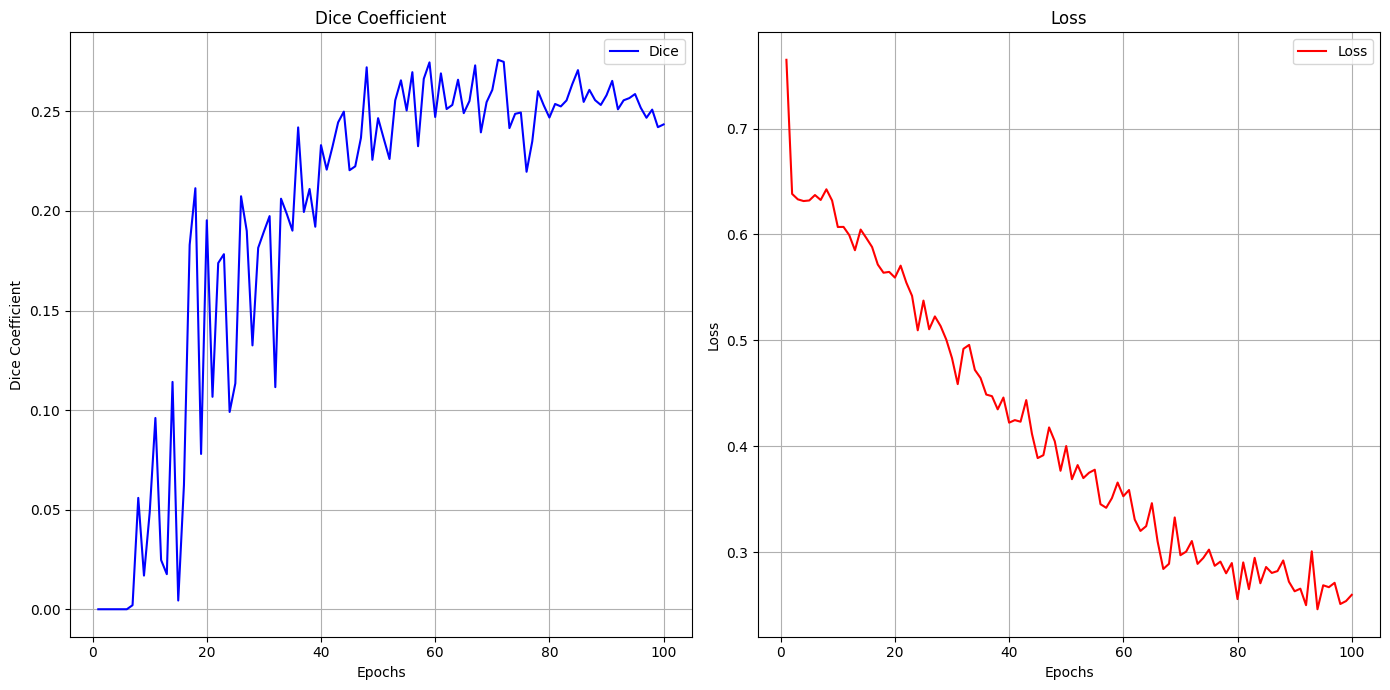

In [9]:
epochs = np.arange(1, len(model_result["dice_tumor"]) + 1)
plt.figure(figsize=(14, 7))

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_result["dice_tumor"], label="Dice", color='blue')
plt.title("Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_result["loss"], label="Loss", color='red')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()